# 20 Segmentation map으로 도로 이미지 만들기

## 20.1 TensorFlow 및 기타 라이브러리 가져오기

In [1]:
# 모듈 import

import tensorflow as tf
import os
import time
import cv2
import numpy as np

from matplotlib import pyplot as plt
from IPython import display


In [2]:
# dataset load

path = os.getenv('HOME') + '/aiffel/conditional_generation/cityscapes/train/'


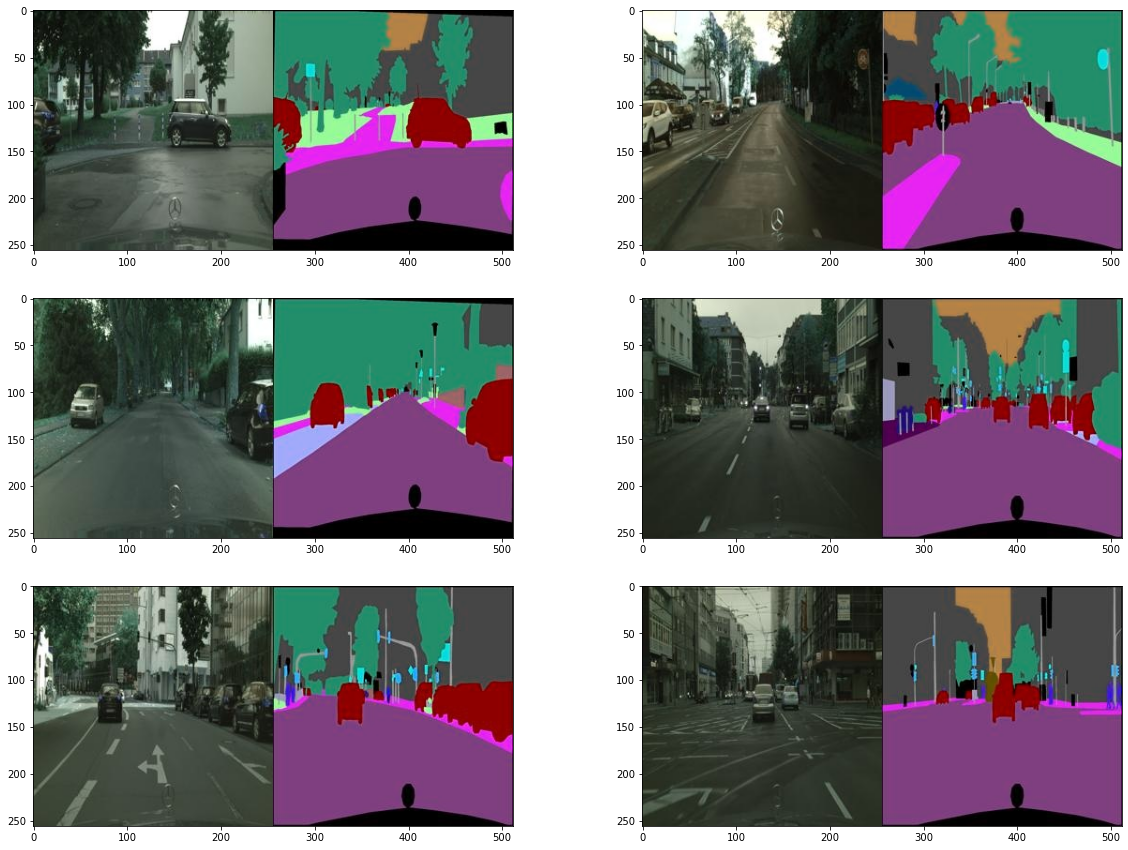

In [3]:
# 이미지 샘플 시각화

plt.figure(figsize=(20,15))
for i in range(1,7):
    f = path + os.listdir(path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
# imge size 확인

f = path + os.listdir(path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


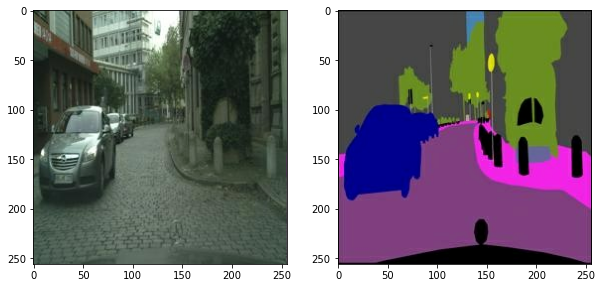

In [5]:
# 이미지 분할 및 normalization

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = path + os.listdir(path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))


## 20.2 augmentation 적용

In [6]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out) # 랜덤 좌우반전
    out = image.random_flip_up_down(out) # 랜덤 상하반전
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree) # 랜덤 회전
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


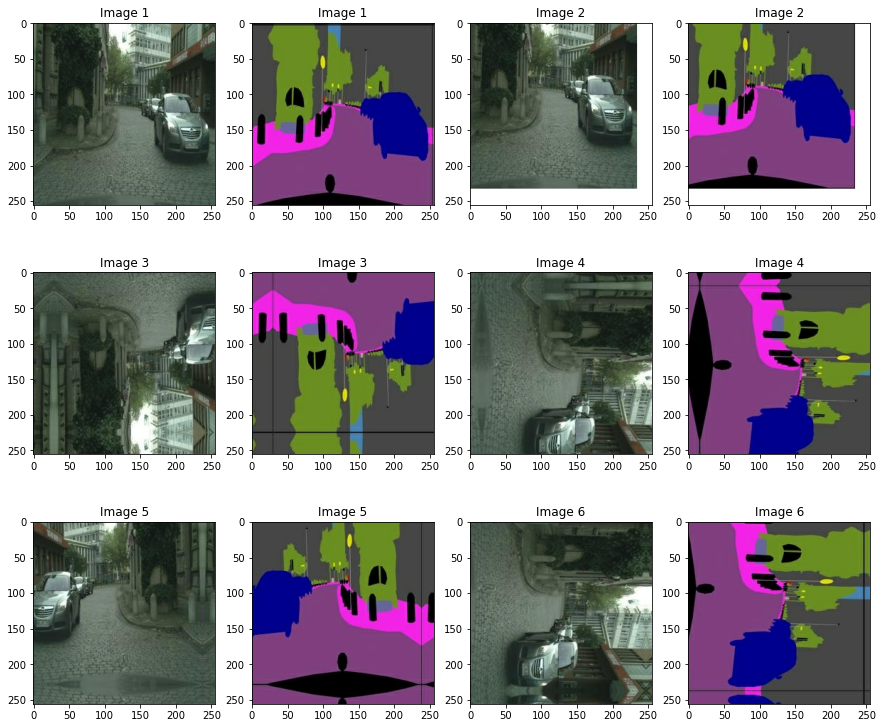

In [7]:
# 시각화

plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

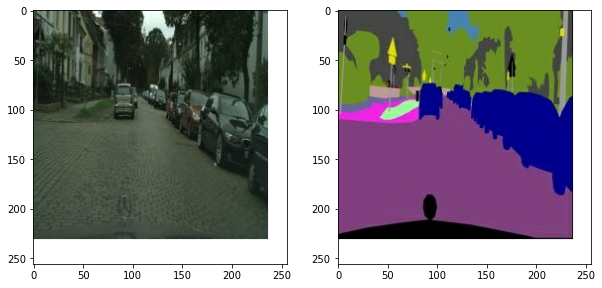

In [8]:
# 학습데이터에 적용 후 샘플 시각화

from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 20.3 U-Net Generator 구현

In [9]:
# Encoder Block 및 Decoder Block  구현

from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [10]:
# U-Net Generator 정의

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [11]:
# 출력 확인

UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## 20.4 Discriminator 구성

In [12]:
# discblock 구현

class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [13]:
# 출력 확인

inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [14]:
# discriminator 구현

class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [15]:
# 모델 확인

Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

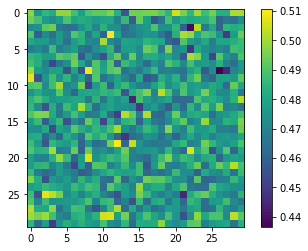

In [16]:
# 샘플 출력

x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 20.5 학습 및 테스트

In [17]:
# 손실함수 정의

from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [18]:
# optimizer 설정

from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [19]:
# 가중치 업데이트

@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [20]:
# 학습 진행

EPOCHS = 500

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9948                     
L1_loss:0.3026                     
Discriminator_loss:1.4232

EPOCH[1] - STEP[20]                     
Generator_loss:1.0655                     
L1_loss:0.3117                     
Discriminator_loss:1.1410

EPOCH[1] - STEP[30]                     
Generator_loss:1.0816                     
L1_loss:0.2404                     
Discriminator_loss:1.1051

EPOCH[1] - STEP[40]                     
Generator_loss:0.7746                     
L1_loss:0.2656                     
Discriminator_loss:1.4039

EPOCH[1] - STEP[50]                     
Generator_loss:1.4416                     
L1_loss:0.2703                     
Discriminator_loss:0.8014

EPOCH[1] - STEP[60]                     
Generator_loss:1.7082                     
L1_loss:0.2447                     
Discriminator_loss:1.0438

EPOCH[1] - STEP[70]                     
Generator_loss:1.9835                     
L1_loss:0.2500                    

EPOCH[3] - STEP[70]                     
Generator_loss:2.0075                     
L1_loss:0.1799                     
Discriminator_loss:0.7136

EPOCH[3] - STEP[80]                     
Generator_loss:3.1226                     
L1_loss:0.1985                     
Discriminator_loss:0.9671

EPOCH[3] - STEP[90]                     
Generator_loss:1.7454                     
L1_loss:0.2228                     
Discriminator_loss:0.4903

EPOCH[3] - STEP[100]                     
Generator_loss:2.3688                     
L1_loss:0.1961                     
Discriminator_loss:0.8690

EPOCH[3] - STEP[110]                     
Generator_loss:1.5391                     
L1_loss:0.1815                     
Discriminator_loss:0.4008

EPOCH[3] - STEP[120]                     
Generator_loss:1.0439                     
L1_loss:0.1942                     
Discriminator_loss:1.0639

EPOCH[3] - STEP[130]                     
Generator_loss:2.2461                     
L1_loss:0.1678                

EPOCH[5] - STEP[130]                     
Generator_loss:3.8128                     
L1_loss:0.1983                     
Discriminator_loss:0.9225

EPOCH[5] - STEP[140]                     
Generator_loss:1.3740                     
L1_loss:0.2008                     
Discriminator_loss:0.8347

EPOCH[5] - STEP[150]                     
Generator_loss:0.7864                     
L1_loss:0.1726                     
Discriminator_loss:0.8259

EPOCH[5] - STEP[160]                     
Generator_loss:2.4368                     
L1_loss:0.1967                     
Discriminator_loss:0.7457

EPOCH[5] - STEP[170]                     
Generator_loss:2.2231                     
L1_loss:0.1946                     
Discriminator_loss:1.3643

EPOCH[5] - STEP[180]                     
Generator_loss:0.6580                     
L1_loss:0.2168                     
Discriminator_loss:1.0025

EPOCH[5] - STEP[190]                     
Generator_loss:2.0929                     
L1_loss:0.1702             

EPOCH[7] - STEP[190]                     
Generator_loss:1.7708                     
L1_loss:0.2067                     
Discriminator_loss:0.8421

EPOCH[7] - STEP[200]                     
Generator_loss:1.0995                     
L1_loss:0.1564                     
Discriminator_loss:0.9173

EPOCH[7] - STEP[210]                     
Generator_loss:2.7488                     
L1_loss:0.1857                     
Discriminator_loss:0.3805

EPOCH[7] - STEP[220]                     
Generator_loss:1.0210                     
L1_loss:0.1934                     
Discriminator_loss:0.7827

EPOCH[7] - STEP[230]                     
Generator_loss:1.7975                     
L1_loss:0.1717                     
Discriminator_loss:1.0563

EPOCH[7] - STEP[240]                     
Generator_loss:1.4290                     
L1_loss:0.1609                     
Discriminator_loss:0.8561

EPOCH[7] - STEP[250]                     
Generator_loss:1.5145                     
L1_loss:0.1801             

EPOCH[9] - STEP[250]                     
Generator_loss:0.8662                     
L1_loss:0.1597                     
Discriminator_loss:0.9106

EPOCH[10] - STEP[10]                     
Generator_loss:0.5303                     
L1_loss:0.1963                     
Discriminator_loss:1.1618

EPOCH[10] - STEP[20]                     
Generator_loss:1.1148                     
L1_loss:0.2026                     
Discriminator_loss:0.6919

EPOCH[10] - STEP[30]                     
Generator_loss:2.2564                     
L1_loss:0.1567                     
Discriminator_loss:1.7133

EPOCH[10] - STEP[40]                     
Generator_loss:1.0101                     
L1_loss:0.1694                     
Discriminator_loss:0.8762

EPOCH[10] - STEP[50]                     
Generator_loss:1.5876                     
L1_loss:0.1783                     
Discriminator_loss:0.3446

EPOCH[10] - STEP[60]                     
Generator_loss:0.7948                     
L1_loss:0.1711             

EPOCH[12] - STEP[60]                     
Generator_loss:0.5094                     
L1_loss:0.1623                     
Discriminator_loss:1.1842

EPOCH[12] - STEP[70]                     
Generator_loss:1.6672                     
L1_loss:0.1528                     
Discriminator_loss:0.3643

EPOCH[12] - STEP[80]                     
Generator_loss:1.6542                     
L1_loss:0.1607                     
Discriminator_loss:0.3322

EPOCH[12] - STEP[90]                     
Generator_loss:1.5367                     
L1_loss:0.1154                     
Discriminator_loss:0.6532

EPOCH[12] - STEP[100]                     
Generator_loss:1.2485                     
L1_loss:0.1666                     
Discriminator_loss:0.6273

EPOCH[12] - STEP[110]                     
Generator_loss:1.5142                     
L1_loss:0.1583                     
Discriminator_loss:0.6492

EPOCH[12] - STEP[120]                     
Generator_loss:0.4124                     
L1_loss:0.1710          

EPOCH[14] - STEP[120]                     
Generator_loss:3.1991                     
L1_loss:0.1339                     
Discriminator_loss:0.7708

EPOCH[14] - STEP[130]                     
Generator_loss:4.2498                     
L1_loss:0.1587                     
Discriminator_loss:1.2264

EPOCH[14] - STEP[140]                     
Generator_loss:1.2585                     
L1_loss:0.1746                     
Discriminator_loss:0.5688

EPOCH[14] - STEP[150]                     
Generator_loss:3.4572                     
L1_loss:0.1552                     
Discriminator_loss:1.6009

EPOCH[14] - STEP[160]                     
Generator_loss:0.3734                     
L1_loss:0.1353                     
Discriminator_loss:1.6849

EPOCH[14] - STEP[170]                     
Generator_loss:0.4053                     
L1_loss:0.1739                     
Discriminator_loss:1.5079

EPOCH[14] - STEP[180]                     
Generator_loss:3.2040                     
L1_loss:0.1545      

EPOCH[16] - STEP[180]                     
Generator_loss:1.5971                     
L1_loss:0.1754                     
Discriminator_loss:0.3583

EPOCH[16] - STEP[190]                     
Generator_loss:1.6314                     
L1_loss:0.1259                     
Discriminator_loss:1.5551

EPOCH[16] - STEP[200]                     
Generator_loss:1.0843                     
L1_loss:0.1801                     
Discriminator_loss:0.6310

EPOCH[16] - STEP[210]                     
Generator_loss:1.6397                     
L1_loss:0.2272                     
Discriminator_loss:0.3213

EPOCH[16] - STEP[220]                     
Generator_loss:1.4971                     
L1_loss:0.1591                     
Discriminator_loss:0.5097

EPOCH[16] - STEP[230]                     
Generator_loss:3.8038                     
L1_loss:0.1552                     
Discriminator_loss:0.8299

EPOCH[16] - STEP[240]                     
Generator_loss:1.5518                     
L1_loss:0.1392      

EPOCH[18] - STEP[240]                     
Generator_loss:1.7475                     
L1_loss:0.1728                     
Discriminator_loss:0.2945

EPOCH[18] - STEP[250]                     
Generator_loss:1.4460                     
L1_loss:0.1739                     
Discriminator_loss:0.5013

EPOCH[19] - STEP[10]                     
Generator_loss:2.3429                     
L1_loss:0.1661                     
Discriminator_loss:0.4916

EPOCH[19] - STEP[20]                     
Generator_loss:1.3974                     
L1_loss:0.1801                     
Discriminator_loss:0.4656

EPOCH[19] - STEP[30]                     
Generator_loss:1.7569                     
L1_loss:0.1472                     
Discriminator_loss:0.6999

EPOCH[19] - STEP[40]                     
Generator_loss:4.1046                     
L1_loss:0.1675                     
Discriminator_loss:2.3896

EPOCH[19] - STEP[50]                     
Generator_loss:2.5518                     
L1_loss:0.1516           

EPOCH[21] - STEP[50]                     
Generator_loss:1.6848                     
L1_loss:0.1491                     
Discriminator_loss:0.3117

EPOCH[21] - STEP[60]                     
Generator_loss:1.6991                     
L1_loss:0.1736                     
Discriminator_loss:0.4746

EPOCH[21] - STEP[70]                     
Generator_loss:0.8770                     
L1_loss:0.1640                     
Discriminator_loss:0.8698

EPOCH[21] - STEP[80]                     
Generator_loss:1.8620                     
L1_loss:0.1848                     
Discriminator_loss:0.4033

EPOCH[21] - STEP[90]                     
Generator_loss:1.4844                     
L1_loss:0.1535                     
Discriminator_loss:0.5287

EPOCH[21] - STEP[100]                     
Generator_loss:2.3017                     
L1_loss:0.1726                     
Discriminator_loss:0.8065

EPOCH[21] - STEP[110]                     
Generator_loss:1.2708                     
L1_loss:0.1674           

EPOCH[23] - STEP[110]                     
Generator_loss:1.3492                     
L1_loss:0.1729                     
Discriminator_loss:0.5033

EPOCH[23] - STEP[120]                     
Generator_loss:1.5343                     
L1_loss:0.1638                     
Discriminator_loss:0.4452

EPOCH[23] - STEP[130]                     
Generator_loss:3.0138                     
L1_loss:0.1663                     
Discriminator_loss:0.4422

EPOCH[23] - STEP[140]                     
Generator_loss:1.2168                     
L1_loss:0.1463                     
Discriminator_loss:0.7067

EPOCH[23] - STEP[150]                     
Generator_loss:1.1063                     
L1_loss:0.2006                     
Discriminator_loss:0.6026

EPOCH[23] - STEP[160]                     
Generator_loss:1.2881                     
L1_loss:0.1396                     
Discriminator_loss:0.4758

EPOCH[23] - STEP[170]                     
Generator_loss:0.5488                     
L1_loss:0.1558      

EPOCH[25] - STEP[170]                     
Generator_loss:1.5996                     
L1_loss:0.1404                     
Discriminator_loss:0.5829

EPOCH[25] - STEP[180]                     
Generator_loss:1.2287                     
L1_loss:0.1287                     
Discriminator_loss:0.5498

EPOCH[25] - STEP[190]                     
Generator_loss:1.4137                     
L1_loss:0.1362                     
Discriminator_loss:0.7960

EPOCH[25] - STEP[200]                     
Generator_loss:2.1690                     
L1_loss:0.1468                     
Discriminator_loss:0.4925

EPOCH[25] - STEP[210]                     
Generator_loss:1.9293                     
L1_loss:0.1491                     
Discriminator_loss:0.3030

EPOCH[25] - STEP[220]                     
Generator_loss:4.4018                     
L1_loss:0.1909                     
Discriminator_loss:0.2332

EPOCH[25] - STEP[230]                     
Generator_loss:2.9682                     
L1_loss:0.1394      

EPOCH[27] - STEP[230]                     
Generator_loss:1.7609                     
L1_loss:0.1327                     
Discriminator_loss:0.6775

EPOCH[27] - STEP[240]                     
Generator_loss:2.5924                     
L1_loss:0.1398                     
Discriminator_loss:0.5700

EPOCH[27] - STEP[250]                     
Generator_loss:2.5534                     
L1_loss:0.1527                     
Discriminator_loss:0.7175

EPOCH[28] - STEP[10]                     
Generator_loss:0.7284                     
L1_loss:0.1460                     
Discriminator_loss:1.3132

EPOCH[28] - STEP[20]                     
Generator_loss:1.4053                     
L1_loss:0.1983                     
Discriminator_loss:0.4668

EPOCH[28] - STEP[30]                     
Generator_loss:0.7967                     
L1_loss:0.1600                     
Discriminator_loss:0.9431

EPOCH[28] - STEP[40]                     
Generator_loss:0.6842                     
L1_loss:0.1753          

EPOCH[30] - STEP[40]                     
Generator_loss:1.0175                     
L1_loss:0.1625                     
Discriminator_loss:1.4981

EPOCH[30] - STEP[50]                     
Generator_loss:1.2779                     
L1_loss:0.1304                     
Discriminator_loss:0.5665

EPOCH[30] - STEP[60]                     
Generator_loss:2.6325                     
L1_loss:0.2140                     
Discriminator_loss:0.1437

EPOCH[30] - STEP[70]                     
Generator_loss:4.0209                     
L1_loss:0.1502                     
Discriminator_loss:0.4690

EPOCH[30] - STEP[80]                     
Generator_loss:1.3497                     
L1_loss:0.1684                     
Discriminator_loss:0.4502

EPOCH[30] - STEP[90]                     
Generator_loss:2.2940                     
L1_loss:0.1560                     
Discriminator_loss:1.0705

EPOCH[30] - STEP[100]                     
Generator_loss:4.9029                     
L1_loss:0.2022            

EPOCH[32] - STEP[100]                     
Generator_loss:2.8336                     
L1_loss:0.1517                     
Discriminator_loss:0.3521

EPOCH[32] - STEP[110]                     
Generator_loss:3.2137                     
L1_loss:0.1589                     
Discriminator_loss:0.1998

EPOCH[32] - STEP[120]                     
Generator_loss:2.5481                     
L1_loss:0.1341                     
Discriminator_loss:0.7068

EPOCH[32] - STEP[130]                     
Generator_loss:1.2232                     
L1_loss:0.1272                     
Discriminator_loss:1.0216

EPOCH[32] - STEP[140]                     
Generator_loss:2.3704                     
L1_loss:0.1823                     
Discriminator_loss:0.2002

EPOCH[32] - STEP[150]                     
Generator_loss:2.6719                     
L1_loss:0.1578                     
Discriminator_loss:0.2728

EPOCH[32] - STEP[160]                     
Generator_loss:2.2055                     
L1_loss:0.1228      

EPOCH[34] - STEP[160]                     
Generator_loss:2.9568                     
L1_loss:0.1416                     
Discriminator_loss:0.4642

EPOCH[34] - STEP[170]                     
Generator_loss:1.3939                     
L1_loss:0.1639                     
Discriminator_loss:0.4740

EPOCH[34] - STEP[180]                     
Generator_loss:1.1325                     
L1_loss:0.1505                     
Discriminator_loss:0.5913

EPOCH[34] - STEP[190]                     
Generator_loss:2.3908                     
L1_loss:0.1183                     
Discriminator_loss:0.9856

EPOCH[34] - STEP[200]                     
Generator_loss:2.5782                     
L1_loss:0.1810                     
Discriminator_loss:0.1360

EPOCH[34] - STEP[210]                     
Generator_loss:3.2935                     
L1_loss:0.1741                     
Discriminator_loss:0.6207

EPOCH[34] - STEP[220]                     
Generator_loss:1.7919                     
L1_loss:0.1856      

EPOCH[36] - STEP[220]                     
Generator_loss:0.1652                     
L1_loss:0.1334                     
Discriminator_loss:2.1746

EPOCH[36] - STEP[230]                     
Generator_loss:1.6942                     
L1_loss:0.1381                     
Discriminator_loss:0.4758

EPOCH[36] - STEP[240]                     
Generator_loss:2.1752                     
L1_loss:0.1619                     
Discriminator_loss:0.3042

EPOCH[36] - STEP[250]                     
Generator_loss:1.7509                     
L1_loss:0.1525                     
Discriminator_loss:0.5081

EPOCH[37] - STEP[10]                     
Generator_loss:2.9732                     
L1_loss:0.1958                     
Discriminator_loss:0.0933

EPOCH[37] - STEP[20]                     
Generator_loss:0.6480                     
L1_loss:0.1664                     
Discriminator_loss:0.9216

EPOCH[37] - STEP[30]                     
Generator_loss:0.4612                     
L1_loss:0.1600         

EPOCH[39] - STEP[30]                     
Generator_loss:1.6890                     
L1_loss:0.1469                     
Discriminator_loss:0.7245

EPOCH[39] - STEP[40]                     
Generator_loss:4.2847                     
L1_loss:0.1471                     
Discriminator_loss:0.7583

EPOCH[39] - STEP[50]                     
Generator_loss:1.9459                     
L1_loss:0.1507                     
Discriminator_loss:0.2840

EPOCH[39] - STEP[60]                     
Generator_loss:0.4377                     
L1_loss:0.1646                     
Discriminator_loss:1.3292

EPOCH[39] - STEP[70]                     
Generator_loss:2.1803                     
L1_loss:0.1418                     
Discriminator_loss:0.3984

EPOCH[39] - STEP[80]                     
Generator_loss:0.2670                     
L1_loss:0.1222                     
Discriminator_loss:1.9592

EPOCH[39] - STEP[90]                     
Generator_loss:3.2253                     
L1_loss:0.1403             

EPOCH[41] - STEP[90]                     
Generator_loss:2.2751                     
L1_loss:0.1237                     
Discriminator_loss:0.8534

EPOCH[41] - STEP[100]                     
Generator_loss:4.8679                     
L1_loss:0.1265                     
Discriminator_loss:0.4033

EPOCH[41] - STEP[110]                     
Generator_loss:4.0027                     
L1_loss:0.1584                     
Discriminator_loss:0.4439

EPOCH[41] - STEP[120]                     
Generator_loss:0.1995                     
L1_loss:0.1259                     
Discriminator_loss:2.0564

EPOCH[41] - STEP[130]                     
Generator_loss:2.6021                     
L1_loss:0.1514                     
Discriminator_loss:0.2710

EPOCH[41] - STEP[140]                     
Generator_loss:1.3803                     
L1_loss:0.1305                     
Discriminator_loss:0.4896

EPOCH[41] - STEP[150]                     
Generator_loss:2.2316                     
L1_loss:0.1889       

EPOCH[43] - STEP[150]                     
Generator_loss:0.2673                     
L1_loss:0.1646                     
Discriminator_loss:1.7863

EPOCH[43] - STEP[160]                     
Generator_loss:1.8689                     
L1_loss:0.1764                     
Discriminator_loss:0.3062

EPOCH[43] - STEP[170]                     
Generator_loss:2.7519                     
L1_loss:0.1483                     
Discriminator_loss:0.9358

EPOCH[43] - STEP[180]                     
Generator_loss:2.0895                     
L1_loss:0.1264                     
Discriminator_loss:0.3674

EPOCH[43] - STEP[190]                     
Generator_loss:3.3848                     
L1_loss:0.1522                     
Discriminator_loss:0.2752

EPOCH[43] - STEP[200]                     
Generator_loss:1.2666                     
L1_loss:0.1773                     
Discriminator_loss:0.5245

EPOCH[43] - STEP[210]                     
Generator_loss:2.7148                     
L1_loss:0.1143      

EPOCH[45] - STEP[210]                     
Generator_loss:1.3023                     
L1_loss:0.1617                     
Discriminator_loss:0.4703

EPOCH[45] - STEP[220]                     
Generator_loss:1.6746                     
L1_loss:0.1889                     
Discriminator_loss:0.3047

EPOCH[45] - STEP[230]                     
Generator_loss:1.3321                     
L1_loss:0.1256                     
Discriminator_loss:0.6431

EPOCH[45] - STEP[240]                     
Generator_loss:1.0466                     
L1_loss:0.1578                     
Discriminator_loss:1.1925

EPOCH[45] - STEP[250]                     
Generator_loss:1.1223                     
L1_loss:0.1744                     
Discriminator_loss:0.6433

EPOCH[46] - STEP[10]                     
Generator_loss:1.6437                     
L1_loss:0.1494                     
Discriminator_loss:0.5666

EPOCH[46] - STEP[20]                     
Generator_loss:3.5553                     
L1_loss:0.1628        

EPOCH[48] - STEP[20]                     
Generator_loss:3.0038                     
L1_loss:0.1277                     
Discriminator_loss:0.2124

EPOCH[48] - STEP[30]                     
Generator_loss:2.4431                     
L1_loss:0.1319                     
Discriminator_loss:0.3142

EPOCH[48] - STEP[40]                     
Generator_loss:1.7965                     
L1_loss:0.1215                     
Discriminator_loss:0.5125

EPOCH[48] - STEP[50]                     
Generator_loss:2.3571                     
L1_loss:0.1342                     
Discriminator_loss:0.4045

EPOCH[48] - STEP[60]                     
Generator_loss:2.1667                     
L1_loss:0.1311                     
Discriminator_loss:0.4029

EPOCH[48] - STEP[70]                     
Generator_loss:2.6470                     
L1_loss:0.1554                     
Discriminator_loss:0.1461

EPOCH[48] - STEP[80]                     
Generator_loss:2.3388                     
L1_loss:0.1334             

EPOCH[50] - STEP[80]                     
Generator_loss:1.2621                     
L1_loss:0.1168                     
Discriminator_loss:0.6549

EPOCH[50] - STEP[90]                     
Generator_loss:3.7054                     
L1_loss:0.1229                     
Discriminator_loss:2.5753

EPOCH[50] - STEP[100]                     
Generator_loss:1.9798                     
L1_loss:0.1288                     
Discriminator_loss:0.4476

EPOCH[50] - STEP[110]                     
Generator_loss:0.8710                     
L1_loss:0.1522                     
Discriminator_loss:0.8025

EPOCH[50] - STEP[120]                     
Generator_loss:1.0103                     
L1_loss:0.1529                     
Discriminator_loss:0.7614

EPOCH[50] - STEP[130]                     
Generator_loss:3.5139                     
L1_loss:0.1623                     
Discriminator_loss:0.1313

EPOCH[50] - STEP[140]                     
Generator_loss:1.1874                     
L1_loss:0.1450        

EPOCH[52] - STEP[140]                     
Generator_loss:1.3979                     
L1_loss:0.1389                     
Discriminator_loss:0.6846

EPOCH[52] - STEP[150]                     
Generator_loss:2.6998                     
L1_loss:0.1461                     
Discriminator_loss:0.1462

EPOCH[52] - STEP[160]                     
Generator_loss:2.3112                     
L1_loss:0.1488                     
Discriminator_loss:0.2909

EPOCH[52] - STEP[170]                     
Generator_loss:4.7863                     
L1_loss:0.1313                     
Discriminator_loss:0.4927

EPOCH[52] - STEP[180]                     
Generator_loss:3.8874                     
L1_loss:0.1770                     
Discriminator_loss:0.0404

EPOCH[52] - STEP[190]                     
Generator_loss:1.3858                     
L1_loss:0.1305                     
Discriminator_loss:0.6629

EPOCH[52] - STEP[200]                     
Generator_loss:4.2196                     
L1_loss:0.1485      

EPOCH[54] - STEP[200]                     
Generator_loss:2.2312                     
L1_loss:0.1283                     
Discriminator_loss:0.6969

EPOCH[54] - STEP[210]                     
Generator_loss:1.4824                     
L1_loss:0.1482                     
Discriminator_loss:1.1168

EPOCH[54] - STEP[220]                     
Generator_loss:3.8291                     
L1_loss:0.1406                     
Discriminator_loss:0.2254

EPOCH[54] - STEP[230]                     
Generator_loss:4.7221                     
L1_loss:0.1403                     
Discriminator_loss:0.2195

EPOCH[54] - STEP[240]                     
Generator_loss:1.0909                     
L1_loss:0.1762                     
Discriminator_loss:0.8553

EPOCH[54] - STEP[250]                     
Generator_loss:5.9747                     
L1_loss:0.1521                     
Discriminator_loss:0.1919

EPOCH[55] - STEP[10]                     
Generator_loss:2.0793                     
L1_loss:0.1331       

EPOCH[57] - STEP[10]                     
Generator_loss:4.4617                     
L1_loss:0.1265                     
Discriminator_loss:0.2414

EPOCH[57] - STEP[20]                     
Generator_loss:3.8149                     
L1_loss:0.1628                     
Discriminator_loss:0.0508

EPOCH[57] - STEP[30]                     
Generator_loss:2.9506                     
L1_loss:0.1435                     
Discriminator_loss:0.1740

EPOCH[57] - STEP[40]                     
Generator_loss:2.5976                     
L1_loss:0.1223                     
Discriminator_loss:1.0803

EPOCH[57] - STEP[50]                     
Generator_loss:4.1477                     
L1_loss:0.1272                     
Discriminator_loss:0.4118

EPOCH[57] - STEP[60]                     
Generator_loss:5.5419                     
L1_loss:0.1353                     
Discriminator_loss:1.2101

EPOCH[57] - STEP[70]                     
Generator_loss:4.1121                     
L1_loss:0.1689             

EPOCH[59] - STEP[70]                     
Generator_loss:3.0833                     
L1_loss:0.1389                     
Discriminator_loss:0.7068

EPOCH[59] - STEP[80]                     
Generator_loss:1.8537                     
L1_loss:0.1125                     
Discriminator_loss:0.3271

EPOCH[59] - STEP[90]                     
Generator_loss:2.0106                     
L1_loss:0.1284                     
Discriminator_loss:0.3928

EPOCH[59] - STEP[100]                     
Generator_loss:1.5455                     
L1_loss:0.1262                     
Discriminator_loss:0.5171

EPOCH[59] - STEP[110]                     
Generator_loss:2.1024                     
L1_loss:0.1567                     
Discriminator_loss:0.2559

EPOCH[59] - STEP[120]                     
Generator_loss:1.6663                     
L1_loss:0.1119                     
Discriminator_loss:1.5981

EPOCH[59] - STEP[130]                     
Generator_loss:4.1631                     
L1_loss:0.1893         

EPOCH[61] - STEP[130]                     
Generator_loss:5.8649                     
L1_loss:0.1405                     
Discriminator_loss:0.4320

EPOCH[61] - STEP[140]                     
Generator_loss:2.1570                     
L1_loss:0.1344                     
Discriminator_loss:0.4092

EPOCH[61] - STEP[150]                     
Generator_loss:1.7115                     
L1_loss:0.1415                     
Discriminator_loss:0.4256

EPOCH[61] - STEP[160]                     
Generator_loss:0.5566                     
L1_loss:0.1436                     
Discriminator_loss:1.4583

EPOCH[61] - STEP[170]                     
Generator_loss:5.7270                     
L1_loss:0.1344                     
Discriminator_loss:0.9880

EPOCH[61] - STEP[180]                     
Generator_loss:3.7094                     
L1_loss:0.1319                     
Discriminator_loss:0.8292

EPOCH[61] - STEP[190]                     
Generator_loss:1.5021                     
L1_loss:0.1350      

EPOCH[63] - STEP[190]                     
Generator_loss:1.1841                     
L1_loss:0.1193                     
Discriminator_loss:0.6903

EPOCH[63] - STEP[200]                     
Generator_loss:2.4948                     
L1_loss:0.1471                     
Discriminator_loss:0.4425

EPOCH[63] - STEP[210]                     
Generator_loss:3.9737                     
L1_loss:0.1527                     
Discriminator_loss:0.1177

EPOCH[63] - STEP[220]                     
Generator_loss:2.0253                     
L1_loss:0.1216                     
Discriminator_loss:0.4135

EPOCH[63] - STEP[230]                     
Generator_loss:3.0803                     
L1_loss:0.1235                     
Discriminator_loss:0.2385

EPOCH[63] - STEP[240]                     
Generator_loss:2.6529                     
L1_loss:0.1452                     
Discriminator_loss:0.2522

EPOCH[63] - STEP[250]                     
Generator_loss:4.2438                     
L1_loss:0.1487      

EPOCH[65] - STEP[250]                     
Generator_loss:1.6889                     
L1_loss:0.1624                     
Discriminator_loss:0.3364

EPOCH[66] - STEP[10]                     
Generator_loss:3.2669                     
L1_loss:0.1156                     
Discriminator_loss:0.8020

EPOCH[66] - STEP[20]                     
Generator_loss:1.5163                     
L1_loss:0.1175                     
Discriminator_loss:0.3691

EPOCH[66] - STEP[30]                     
Generator_loss:1.8456                     
L1_loss:0.1236                     
Discriminator_loss:0.4211

EPOCH[66] - STEP[40]                     
Generator_loss:2.5266                     
L1_loss:0.1500                     
Discriminator_loss:0.2445

EPOCH[66] - STEP[50]                     
Generator_loss:2.5339                     
L1_loss:0.1221                     
Discriminator_loss:0.4185

EPOCH[66] - STEP[60]                     
Generator_loss:4.8535                     
L1_loss:0.1183            

EPOCH[68] - STEP[60]                     
Generator_loss:4.7711                     
L1_loss:0.1361                     
Discriminator_loss:0.0455

EPOCH[68] - STEP[70]                     
Generator_loss:2.5849                     
L1_loss:0.1383                     
Discriminator_loss:0.1589

EPOCH[68] - STEP[80]                     
Generator_loss:2.9765                     
L1_loss:0.1606                     
Discriminator_loss:0.1750

EPOCH[68] - STEP[90]                     
Generator_loss:3.4861                     
L1_loss:0.1487                     
Discriminator_loss:0.1698

EPOCH[68] - STEP[100]                     
Generator_loss:5.0303                     
L1_loss:0.1434                     
Discriminator_loss:0.9471

EPOCH[68] - STEP[110]                     
Generator_loss:3.0540                     
L1_loss:0.2025                     
Discriminator_loss:0.1110

EPOCH[68] - STEP[120]                     
Generator_loss:0.5199                     
L1_loss:0.1125          

EPOCH[70] - STEP[120]                     
Generator_loss:1.9656                     
L1_loss:0.1260                     
Discriminator_loss:0.5529

EPOCH[70] - STEP[130]                     
Generator_loss:4.9052                     
L1_loss:0.1178                     
Discriminator_loss:1.5104

EPOCH[70] - STEP[140]                     
Generator_loss:3.5504                     
L1_loss:0.1297                     
Discriminator_loss:0.1230

EPOCH[70] - STEP[150]                     
Generator_loss:1.8125                     
L1_loss:0.1333                     
Discriminator_loss:0.3254

EPOCH[70] - STEP[160]                     
Generator_loss:2.3638                     
L1_loss:0.1779                     
Discriminator_loss:0.2312

EPOCH[70] - STEP[170]                     
Generator_loss:2.9684                     
L1_loss:0.1283                     
Discriminator_loss:0.1646

EPOCH[70] - STEP[180]                     
Generator_loss:0.5652                     
L1_loss:0.1236      

EPOCH[72] - STEP[180]                     
Generator_loss:2.0230                     
L1_loss:0.1416                     
Discriminator_loss:0.2988

EPOCH[72] - STEP[190]                     
Generator_loss:3.6800                     
L1_loss:0.1699                     
Discriminator_loss:0.1493

EPOCH[72] - STEP[200]                     
Generator_loss:1.4711                     
L1_loss:0.1095                     
Discriminator_loss:1.4739

EPOCH[72] - STEP[210]                     
Generator_loss:2.9691                     
L1_loss:0.1323                     
Discriminator_loss:0.4792

EPOCH[72] - STEP[220]                     
Generator_loss:4.8832                     
L1_loss:0.1396                     
Discriminator_loss:0.3505

EPOCH[72] - STEP[230]                     
Generator_loss:4.0155                     
L1_loss:0.1545                     
Discriminator_loss:0.7957

EPOCH[72] - STEP[240]                     
Generator_loss:2.0183                     
L1_loss:0.1449      

EPOCH[74] - STEP[240]                     
Generator_loss:0.3344                     
L1_loss:0.1277                     
Discriminator_loss:2.1353

EPOCH[74] - STEP[250]                     
Generator_loss:1.1434                     
L1_loss:0.1463                     
Discriminator_loss:0.6902

EPOCH[75] - STEP[10]                     
Generator_loss:2.9254                     
L1_loss:0.1172                     
Discriminator_loss:0.9179

EPOCH[75] - STEP[20]                     
Generator_loss:3.1706                     
L1_loss:0.1615                     
Discriminator_loss:0.1854

EPOCH[75] - STEP[30]                     
Generator_loss:4.2230                     
L1_loss:0.1266                     
Discriminator_loss:0.3000

EPOCH[75] - STEP[40]                     
Generator_loss:3.2623                     
L1_loss:0.1434                     
Discriminator_loss:0.0868

EPOCH[75] - STEP[50]                     
Generator_loss:3.6804                     
L1_loss:0.1366           

EPOCH[77] - STEP[50]                     
Generator_loss:2.1932                     
L1_loss:0.1444                     
Discriminator_loss:0.3421

EPOCH[77] - STEP[60]                     
Generator_loss:3.0315                     
L1_loss:0.1367                     
Discriminator_loss:0.1071

EPOCH[77] - STEP[70]                     
Generator_loss:2.8141                     
L1_loss:0.1142                     
Discriminator_loss:0.2924

EPOCH[77] - STEP[80]                     
Generator_loss:0.9608                     
L1_loss:0.1424                     
Discriminator_loss:0.8110

EPOCH[77] - STEP[90]                     
Generator_loss:3.2377                     
L1_loss:0.1854                     
Discriminator_loss:0.0767

EPOCH[77] - STEP[100]                     
Generator_loss:4.7650                     
L1_loss:0.1151                     
Discriminator_loss:0.6800

EPOCH[77] - STEP[110]                     
Generator_loss:1.9724                     
L1_loss:0.1617           

EPOCH[79] - STEP[110]                     
Generator_loss:1.1393                     
L1_loss:0.1214                     
Discriminator_loss:0.6432

EPOCH[79] - STEP[120]                     
Generator_loss:0.5321                     
L1_loss:0.1361                     
Discriminator_loss:1.2547

EPOCH[79] - STEP[130]                     
Generator_loss:1.8777                     
L1_loss:0.1307                     
Discriminator_loss:0.4529

EPOCH[79] - STEP[140]                     
Generator_loss:1.2685                     
L1_loss:0.1361                     
Discriminator_loss:0.8467

EPOCH[79] - STEP[150]                     
Generator_loss:4.2582                     
L1_loss:0.1209                     
Discriminator_loss:2.0398

EPOCH[79] - STEP[160]                     
Generator_loss:4.1508                     
L1_loss:0.1328                     
Discriminator_loss:0.7304

EPOCH[79] - STEP[170]                     
Generator_loss:5.7522                     
L1_loss:0.1362      

EPOCH[81] - STEP[170]                     
Generator_loss:5.9138                     
L1_loss:0.1508                     
Discriminator_loss:0.3248

EPOCH[81] - STEP[180]                     
Generator_loss:4.8986                     
L1_loss:0.1114                     
Discriminator_loss:1.3395

EPOCH[81] - STEP[190]                     
Generator_loss:1.6541                     
L1_loss:0.1388                     
Discriminator_loss:0.3584

EPOCH[81] - STEP[200]                     
Generator_loss:3.1075                     
L1_loss:0.1519                     
Discriminator_loss:0.1264

EPOCH[81] - STEP[210]                     
Generator_loss:0.5015                     
L1_loss:0.1474                     
Discriminator_loss:1.3738

EPOCH[81] - STEP[220]                     
Generator_loss:1.7956                     
L1_loss:0.1073                     
Discriminator_loss:0.6814

EPOCH[81] - STEP[230]                     
Generator_loss:2.6520                     
L1_loss:0.1478      

EPOCH[83] - STEP[230]                     
Generator_loss:5.5985                     
L1_loss:0.1063                     
Discriminator_loss:0.3891

EPOCH[83] - STEP[240]                     
Generator_loss:3.4831                     
L1_loss:0.1474                     
Discriminator_loss:0.5977

EPOCH[83] - STEP[250]                     
Generator_loss:1.5859                     
L1_loss:0.1022                     
Discriminator_loss:0.6018

EPOCH[84] - STEP[10]                     
Generator_loss:4.6180                     
L1_loss:0.1121                     
Discriminator_loss:0.8121

EPOCH[84] - STEP[20]                     
Generator_loss:1.3193                     
L1_loss:0.1457                     
Discriminator_loss:0.5190

EPOCH[84] - STEP[30]                     
Generator_loss:1.4678                     
L1_loss:0.1066                     
Discriminator_loss:0.5339

EPOCH[84] - STEP[40]                     
Generator_loss:1.4056                     
L1_loss:0.1189          

EPOCH[86] - STEP[40]                     
Generator_loss:1.1763                     
L1_loss:0.1516                     
Discriminator_loss:0.8157

EPOCH[86] - STEP[50]                     
Generator_loss:3.1511                     
L1_loss:0.1077                     
Discriminator_loss:0.1247

EPOCH[86] - STEP[60]                     
Generator_loss:1.3941                     
L1_loss:0.1225                     
Discriminator_loss:0.5481

EPOCH[86] - STEP[70]                     
Generator_loss:0.9670                     
L1_loss:0.1057                     
Discriminator_loss:0.9294

EPOCH[86] - STEP[80]                     
Generator_loss:2.1696                     
L1_loss:0.1060                     
Discriminator_loss:0.3075

EPOCH[86] - STEP[90]                     
Generator_loss:3.9660                     
L1_loss:0.1119                     
Discriminator_loss:0.0697

EPOCH[86] - STEP[100]                     
Generator_loss:3.3498                     
L1_loss:0.1110            

EPOCH[88] - STEP[100]                     
Generator_loss:1.3949                     
L1_loss:0.1069                     
Discriminator_loss:0.9560

EPOCH[88] - STEP[110]                     
Generator_loss:2.8053                     
L1_loss:0.1167                     
Discriminator_loss:0.2616

EPOCH[88] - STEP[120]                     
Generator_loss:3.8352                     
L1_loss:0.1512                     
Discriminator_loss:0.4342

EPOCH[88] - STEP[130]                     
Generator_loss:2.2215                     
L1_loss:0.1496                     
Discriminator_loss:0.2690

EPOCH[88] - STEP[140]                     
Generator_loss:3.3163                     
L1_loss:0.1228                     
Discriminator_loss:0.4045

EPOCH[88] - STEP[150]                     
Generator_loss:3.7097                     
L1_loss:0.1437                     
Discriminator_loss:0.0750

EPOCH[88] - STEP[160]                     
Generator_loss:1.9194                     
L1_loss:0.2068      

EPOCH[90] - STEP[160]                     
Generator_loss:3.0359                     
L1_loss:0.1348                     
Discriminator_loss:0.1222

EPOCH[90] - STEP[170]                     
Generator_loss:2.9678                     
L1_loss:0.1216                     
Discriminator_loss:0.2961

EPOCH[90] - STEP[180]                     
Generator_loss:1.9216                     
L1_loss:0.1335                     
Discriminator_loss:0.4725

EPOCH[90] - STEP[190]                     
Generator_loss:2.2700                     
L1_loss:0.1468                     
Discriminator_loss:0.2143

EPOCH[90] - STEP[200]                     
Generator_loss:2.4303                     
L1_loss:0.1141                     
Discriminator_loss:0.3196

EPOCH[90] - STEP[210]                     
Generator_loss:3.7521                     
L1_loss:0.1298                     
Discriminator_loss:0.1282

EPOCH[90] - STEP[220]                     
Generator_loss:4.0824                     
L1_loss:0.1676      

EPOCH[92] - STEP[220]                     
Generator_loss:4.4187                     
L1_loss:0.1203                     
Discriminator_loss:0.8917

EPOCH[92] - STEP[230]                     
Generator_loss:3.0487                     
L1_loss:0.1282                     
Discriminator_loss:0.0746

EPOCH[92] - STEP[240]                     
Generator_loss:1.9863                     
L1_loss:0.1105                     
Discriminator_loss:0.2856

EPOCH[92] - STEP[250]                     
Generator_loss:2.8078                     
L1_loss:0.1300                     
Discriminator_loss:0.2454

EPOCH[93] - STEP[10]                     
Generator_loss:2.2372                     
L1_loss:0.1081                     
Discriminator_loss:0.8518

EPOCH[93] - STEP[20]                     
Generator_loss:2.9659                     
L1_loss:0.1308                     
Discriminator_loss:0.2270

EPOCH[93] - STEP[30]                     
Generator_loss:1.1608                     
L1_loss:0.1210         

EPOCH[95] - STEP[30]                     
Generator_loss:3.2991                     
L1_loss:0.1185                     
Discriminator_loss:0.7214

EPOCH[95] - STEP[40]                     
Generator_loss:3.4493                     
L1_loss:0.1208                     
Discriminator_loss:0.3888

EPOCH[95] - STEP[50]                     
Generator_loss:2.1917                     
L1_loss:0.1232                     
Discriminator_loss:0.2758

EPOCH[95] - STEP[60]                     
Generator_loss:5.3147                     
L1_loss:0.1361                     
Discriminator_loss:0.5886

EPOCH[95] - STEP[70]                     
Generator_loss:3.1674                     
L1_loss:0.1235                     
Discriminator_loss:0.1589

EPOCH[95] - STEP[80]                     
Generator_loss:1.8900                     
L1_loss:0.1218                     
Discriminator_loss:0.4263

EPOCH[95] - STEP[90]                     
Generator_loss:1.3526                     
L1_loss:0.1218             

EPOCH[97] - STEP[90]                     
Generator_loss:4.1042                     
L1_loss:0.1398                     
Discriminator_loss:0.1581

EPOCH[97] - STEP[100]                     
Generator_loss:2.6339                     
L1_loss:0.1310                     
Discriminator_loss:0.2295

EPOCH[97] - STEP[110]                     
Generator_loss:5.4768                     
L1_loss:0.1397                     
Discriminator_loss:0.4453

EPOCH[97] - STEP[120]                     
Generator_loss:5.5626                     
L1_loss:0.1475                     
Discriminator_loss:0.1865

EPOCH[97] - STEP[130]                     
Generator_loss:2.0895                     
L1_loss:0.1400                     
Discriminator_loss:0.2571

EPOCH[97] - STEP[140]                     
Generator_loss:4.2778                     
L1_loss:0.1579                     
Discriminator_loss:0.1206

EPOCH[97] - STEP[150]                     
Generator_loss:0.7479                     
L1_loss:0.1312       

EPOCH[99] - STEP[150]                     
Generator_loss:3.9958                     
L1_loss:0.1429                     
Discriminator_loss:0.0594

EPOCH[99] - STEP[160]                     
Generator_loss:3.1604                     
L1_loss:0.1297                     
Discriminator_loss:0.1266

EPOCH[99] - STEP[170]                     
Generator_loss:2.9856                     
L1_loss:0.1123                     
Discriminator_loss:0.9593

EPOCH[99] - STEP[180]                     
Generator_loss:0.7406                     
L1_loss:0.0995                     
Discriminator_loss:1.8342

EPOCH[99] - STEP[190]                     
Generator_loss:4.2599                     
L1_loss:0.1568                     
Discriminator_loss:0.2471

EPOCH[99] - STEP[200]                     
Generator_loss:2.4630                     
L1_loss:0.1205                     
Discriminator_loss:0.1624

EPOCH[99] - STEP[210]                     
Generator_loss:2.9307                     
L1_loss:0.1262      

EPOCH[101] - STEP[200]                     
Generator_loss:0.8645                     
L1_loss:0.0982                     
Discriminator_loss:0.8589

EPOCH[101] - STEP[210]                     
Generator_loss:3.2285                     
L1_loss:0.1454                     
Discriminator_loss:0.0751

EPOCH[101] - STEP[220]                     
Generator_loss:5.6196                     
L1_loss:0.1288                     
Discriminator_loss:0.1297

EPOCH[101] - STEP[230]                     
Generator_loss:2.2187                     
L1_loss:0.1546                     
Discriminator_loss:0.9372

EPOCH[101] - STEP[240]                     
Generator_loss:3.5470                     
L1_loss:0.1106                     
Discriminator_loss:0.1633

EPOCH[101] - STEP[250]                     
Generator_loss:3.3271                     
L1_loss:0.1435                     
Discriminator_loss:0.1025

EPOCH[102] - STEP[10]                     
Generator_loss:2.3675                     
L1_loss:0.1070

EPOCH[103] - STEP[250]                     
Generator_loss:5.7017                     
L1_loss:0.1219                     
Discriminator_loss:1.7163

EPOCH[104] - STEP[10]                     
Generator_loss:3.3832                     
L1_loss:0.1200                     
Discriminator_loss:0.1138

EPOCH[104] - STEP[20]                     
Generator_loss:3.8035                     
L1_loss:0.1205                     
Discriminator_loss:0.3303

EPOCH[104] - STEP[30]                     
Generator_loss:2.6451                     
L1_loss:0.1294                     
Discriminator_loss:0.1537

EPOCH[104] - STEP[40]                     
Generator_loss:2.3302                     
L1_loss:0.1270                     
Discriminator_loss:0.2295

EPOCH[104] - STEP[50]                     
Generator_loss:3.7537                     
L1_loss:0.1559                     
Discriminator_loss:0.0885

EPOCH[104] - STEP[60]                     
Generator_loss:5.7396                     
L1_loss:0.1241     

EPOCH[106] - STEP[50]                     
Generator_loss:1.1427                     
L1_loss:0.1020                     
Discriminator_loss:0.7192

EPOCH[106] - STEP[60]                     
Generator_loss:3.7576                     
L1_loss:0.1548                     
Discriminator_loss:0.0792

EPOCH[106] - STEP[70]                     
Generator_loss:1.6798                     
L1_loss:0.1384                     
Discriminator_loss:0.5572

EPOCH[106] - STEP[80]                     
Generator_loss:1.2311                     
L1_loss:0.1073                     
Discriminator_loss:0.8685

EPOCH[106] - STEP[90]                     
Generator_loss:3.2136                     
L1_loss:0.1255                     
Discriminator_loss:0.0896

EPOCH[106] - STEP[100]                     
Generator_loss:3.9208                     
L1_loss:0.1393                     
Discriminator_loss:0.1698

EPOCH[106] - STEP[110]                     
Generator_loss:3.4872                     
L1_loss:0.1077    

EPOCH[108] - STEP[100]                     
Generator_loss:0.3961                     
L1_loss:0.1524                     
Discriminator_loss:1.7114

EPOCH[108] - STEP[110]                     
Generator_loss:2.6998                     
L1_loss:0.1241                     
Discriminator_loss:0.1941

EPOCH[108] - STEP[120]                     
Generator_loss:4.7380                     
L1_loss:0.1326                     
Discriminator_loss:2.7655

EPOCH[108] - STEP[130]                     
Generator_loss:4.2269                     
L1_loss:0.1293                     
Discriminator_loss:0.1390

EPOCH[108] - STEP[140]                     
Generator_loss:2.0757                     
L1_loss:0.1382                     
Discriminator_loss:0.3062

EPOCH[108] - STEP[150]                     
Generator_loss:2.4672                     
L1_loss:0.1249                     
Discriminator_loss:0.2430

EPOCH[108] - STEP[160]                     
Generator_loss:3.0871                     
L1_loss:0.118

EPOCH[110] - STEP[150]                     
Generator_loss:3.9456                     
L1_loss:0.1885                     
Discriminator_loss:0.0898

EPOCH[110] - STEP[160]                     
Generator_loss:3.7941                     
L1_loss:0.1282                     
Discriminator_loss:0.0595

EPOCH[110] - STEP[170]                     
Generator_loss:2.0854                     
L1_loss:0.1199                     
Discriminator_loss:0.3588

EPOCH[110] - STEP[180]                     
Generator_loss:1.6627                     
L1_loss:0.1155                     
Discriminator_loss:0.4268

EPOCH[110] - STEP[190]                     
Generator_loss:1.1058                     
L1_loss:0.1245                     
Discriminator_loss:0.6093

EPOCH[110] - STEP[200]                     
Generator_loss:1.9131                     
L1_loss:0.1459                     
Discriminator_loss:0.4991

EPOCH[110] - STEP[210]                     
Generator_loss:2.7393                     
L1_loss:0.174

EPOCH[112] - STEP[200]                     
Generator_loss:1.6406                     
L1_loss:0.1239                     
Discriminator_loss:0.4200

EPOCH[112] - STEP[210]                     
Generator_loss:2.8132                     
L1_loss:0.1247                     
Discriminator_loss:0.3952

EPOCH[112] - STEP[220]                     
Generator_loss:2.6798                     
L1_loss:0.1135                     
Discriminator_loss:0.3941

EPOCH[112] - STEP[230]                     
Generator_loss:3.6792                     
L1_loss:0.1289                     
Discriminator_loss:0.4802

EPOCH[112] - STEP[240]                     
Generator_loss:1.5971                     
L1_loss:0.1427                     
Discriminator_loss:0.3744

EPOCH[112] - STEP[250]                     
Generator_loss:5.5187                     
L1_loss:0.1363                     
Discriminator_loss:0.1789

EPOCH[113] - STEP[10]                     
Generator_loss:3.8852                     
L1_loss:0.1327

EPOCH[114] - STEP[250]                     
Generator_loss:5.0952                     
L1_loss:0.1470                     
Discriminator_loss:0.1090

EPOCH[115] - STEP[10]                     
Generator_loss:2.5258                     
L1_loss:0.1215                     
Discriminator_loss:0.1447

EPOCH[115] - STEP[20]                     
Generator_loss:1.6547                     
L1_loss:0.1055                     
Discriminator_loss:0.4726

EPOCH[115] - STEP[30]                     
Generator_loss:1.0627                     
L1_loss:0.1174                     
Discriminator_loss:1.0522

EPOCH[115] - STEP[40]                     
Generator_loss:4.3745                     
L1_loss:0.1168                     
Discriminator_loss:0.0447

EPOCH[115] - STEP[50]                     
Generator_loss:3.0442                     
L1_loss:0.1477                     
Discriminator_loss:0.3430

EPOCH[115] - STEP[60]                     
Generator_loss:1.6046                     
L1_loss:0.1312     

EPOCH[117] - STEP[50]                     
Generator_loss:3.3164                     
L1_loss:0.1456                     
Discriminator_loss:0.2284

EPOCH[117] - STEP[60]                     
Generator_loss:1.2578                     
L1_loss:0.1605                     
Discriminator_loss:0.6054

EPOCH[117] - STEP[70]                     
Generator_loss:3.4631                     
L1_loss:0.1502                     
Discriminator_loss:0.1367

EPOCH[117] - STEP[80]                     
Generator_loss:4.0749                     
L1_loss:0.1204                     
Discriminator_loss:0.2350

EPOCH[117] - STEP[90]                     
Generator_loss:5.3957                     
L1_loss:0.1213                     
Discriminator_loss:0.8806

EPOCH[117] - STEP[100]                     
Generator_loss:3.4355                     
L1_loss:0.1453                     
Discriminator_loss:0.1951

EPOCH[117] - STEP[110]                     
Generator_loss:3.9183                     
L1_loss:0.1338    

EPOCH[119] - STEP[100]                     
Generator_loss:1.6053                     
L1_loss:0.1200                     
Discriminator_loss:0.4422

EPOCH[119] - STEP[110]                     
Generator_loss:5.3562                     
L1_loss:0.1158                     
Discriminator_loss:0.0991

EPOCH[119] - STEP[120]                     
Generator_loss:4.3758                     
L1_loss:0.1497                     
Discriminator_loss:0.0756

EPOCH[119] - STEP[130]                     
Generator_loss:7.2190                     
L1_loss:0.1217                     
Discriminator_loss:0.1926

EPOCH[119] - STEP[140]                     
Generator_loss:2.5475                     
L1_loss:0.1166                     
Discriminator_loss:0.1902

EPOCH[119] - STEP[150]                     
Generator_loss:2.4215                     
L1_loss:0.1086                     
Discriminator_loss:0.2605

EPOCH[119] - STEP[160]                     
Generator_loss:5.5271                     
L1_loss:0.117

EPOCH[121] - STEP[150]                     
Generator_loss:4.2839                     
L1_loss:0.1550                     
Discriminator_loss:0.0495

EPOCH[121] - STEP[160]                     
Generator_loss:3.5596                     
L1_loss:0.1351                     
Discriminator_loss:0.2096

EPOCH[121] - STEP[170]                     
Generator_loss:3.9375                     
L1_loss:0.1491                     
Discriminator_loss:0.1003

EPOCH[121] - STEP[180]                     
Generator_loss:3.1731                     
L1_loss:0.1394                     
Discriminator_loss:0.1585

EPOCH[121] - STEP[190]                     
Generator_loss:2.1831                     
L1_loss:0.1124                     
Discriminator_loss:0.4517

EPOCH[121] - STEP[200]                     
Generator_loss:4.3313                     
L1_loss:0.1301                     
Discriminator_loss:0.0408

EPOCH[121] - STEP[210]                     
Generator_loss:2.1630                     
L1_loss:0.161

EPOCH[123] - STEP[200]                     
Generator_loss:3.6343                     
L1_loss:0.1401                     
Discriminator_loss:0.0845

EPOCH[123] - STEP[210]                     
Generator_loss:1.7630                     
L1_loss:0.1150                     
Discriminator_loss:0.4627

EPOCH[123] - STEP[220]                     
Generator_loss:7.4087                     
L1_loss:0.1183                     
Discriminator_loss:0.5213

EPOCH[123] - STEP[230]                     
Generator_loss:5.6328                     
L1_loss:0.1267                     
Discriminator_loss:0.0297

EPOCH[123] - STEP[240]                     
Generator_loss:3.7475                     
L1_loss:0.1135                     
Discriminator_loss:0.2982

EPOCH[123] - STEP[250]                     
Generator_loss:2.5228                     
L1_loss:0.1114                     
Discriminator_loss:0.3932

EPOCH[124] - STEP[10]                     
Generator_loss:3.2659                     
L1_loss:0.1068

EPOCH[125] - STEP[250]                     
Generator_loss:6.2598                     
L1_loss:0.1510                     
Discriminator_loss:0.2990

EPOCH[126] - STEP[10]                     
Generator_loss:3.2797                     
L1_loss:0.1177                     
Discriminator_loss:0.0839

EPOCH[126] - STEP[20]                     
Generator_loss:3.9923                     
L1_loss:0.1137                     
Discriminator_loss:0.0647

EPOCH[126] - STEP[30]                     
Generator_loss:2.1532                     
L1_loss:0.1563                     
Discriminator_loss:0.4474

EPOCH[126] - STEP[40]                     
Generator_loss:2.6875                     
L1_loss:0.1203                     
Discriminator_loss:0.1375

EPOCH[126] - STEP[50]                     
Generator_loss:0.6650                     
L1_loss:0.0974                     
Discriminator_loss:0.9788

EPOCH[126] - STEP[60]                     
Generator_loss:4.5907                     
L1_loss:0.1247     

EPOCH[128] - STEP[50]                     
Generator_loss:1.4779                     
L1_loss:0.1149                     
Discriminator_loss:0.4610

EPOCH[128] - STEP[60]                     
Generator_loss:6.4354                     
L1_loss:0.1273                     
Discriminator_loss:0.0149

EPOCH[128] - STEP[70]                     
Generator_loss:3.7257                     
L1_loss:0.1274                     
Discriminator_loss:0.1079

EPOCH[128] - STEP[80]                     
Generator_loss:3.1305                     
L1_loss:0.1350                     
Discriminator_loss:0.2480

EPOCH[128] - STEP[90]                     
Generator_loss:4.3821                     
L1_loss:0.1183                     
Discriminator_loss:0.0451

EPOCH[128] - STEP[100]                     
Generator_loss:5.3092                     
L1_loss:0.1318                     
Discriminator_loss:0.0225

EPOCH[128] - STEP[110]                     
Generator_loss:6.6496                     
L1_loss:0.1816    

EPOCH[130] - STEP[100]                     
Generator_loss:6.6662                     
L1_loss:0.1369                     
Discriminator_loss:0.1285

EPOCH[130] - STEP[110]                     
Generator_loss:1.8854                     
L1_loss:0.1048                     
Discriminator_loss:0.7151

EPOCH[130] - STEP[120]                     
Generator_loss:5.7410                     
L1_loss:0.1564                     
Discriminator_loss:0.0319

EPOCH[130] - STEP[130]                     
Generator_loss:4.3320                     
L1_loss:0.1533                     
Discriminator_loss:0.0777

EPOCH[130] - STEP[140]                     
Generator_loss:3.4342                     
L1_loss:0.1297                     
Discriminator_loss:0.0964

EPOCH[130] - STEP[150]                     
Generator_loss:4.3315                     
L1_loss:0.1042                     
Discriminator_loss:0.9964

EPOCH[130] - STEP[160]                     
Generator_loss:2.3675                     
L1_loss:0.125

EPOCH[132] - STEP[150]                     
Generator_loss:3.2037                     
L1_loss:0.1352                     
Discriminator_loss:0.1630

EPOCH[132] - STEP[160]                     
Generator_loss:3.4738                     
L1_loss:0.1127                     
Discriminator_loss:1.0178

EPOCH[132] - STEP[170]                     
Generator_loss:4.8468                     
L1_loss:0.1062                     
Discriminator_loss:0.8774

EPOCH[132] - STEP[180]                     
Generator_loss:4.7724                     
L1_loss:0.1586                     
Discriminator_loss:0.2697

EPOCH[132] - STEP[190]                     
Generator_loss:2.6629                     
L1_loss:0.1123                     
Discriminator_loss:0.3188

EPOCH[132] - STEP[200]                     
Generator_loss:3.0899                     
L1_loss:0.1239                     
Discriminator_loss:0.4025

EPOCH[132] - STEP[210]                     
Generator_loss:5.2651                     
L1_loss:0.102

EPOCH[134] - STEP[200]                     
Generator_loss:3.6510                     
L1_loss:0.1417                     
Discriminator_loss:0.1547

EPOCH[134] - STEP[210]                     
Generator_loss:1.7888                     
L1_loss:0.1258                     
Discriminator_loss:0.3627

EPOCH[134] - STEP[220]                     
Generator_loss:3.2527                     
L1_loss:0.1106                     
Discriminator_loss:2.0110

EPOCH[134] - STEP[230]                     
Generator_loss:1.7635                     
L1_loss:0.1337                     
Discriminator_loss:0.4122

EPOCH[134] - STEP[240]                     
Generator_loss:2.1093                     
L1_loss:0.1243                     
Discriminator_loss:0.2541

EPOCH[134] - STEP[250]                     
Generator_loss:6.6590                     
L1_loss:0.1405                     
Discriminator_loss:0.0182

EPOCH[135] - STEP[10]                     
Generator_loss:4.1228                     
L1_loss:0.1196

EPOCH[136] - STEP[250]                     
Generator_loss:5.5715                     
L1_loss:0.1250                     
Discriminator_loss:0.1632

EPOCH[137] - STEP[10]                     
Generator_loss:2.9789                     
L1_loss:0.1086                     
Discriminator_loss:0.5129

EPOCH[137] - STEP[20]                     
Generator_loss:2.8344                     
L1_loss:0.1481                     
Discriminator_loss:0.1303

EPOCH[137] - STEP[30]                     
Generator_loss:1.8521                     
L1_loss:0.1283                     
Discriminator_loss:1.1025

EPOCH[137] - STEP[40]                     
Generator_loss:3.3086                     
L1_loss:0.1381                     
Discriminator_loss:0.1065

EPOCH[137] - STEP[50]                     
Generator_loss:4.4878                     
L1_loss:0.1529                     
Discriminator_loss:1.2869

EPOCH[137] - STEP[60]                     
Generator_loss:4.1121                     
L1_loss:0.1262     

EPOCH[139] - STEP[50]                     
Generator_loss:5.9913                     
L1_loss:0.1295                     
Discriminator_loss:0.0410

EPOCH[139] - STEP[60]                     
Generator_loss:0.7706                     
L1_loss:0.1217                     
Discriminator_loss:1.1892

EPOCH[139] - STEP[70]                     
Generator_loss:1.8174                     
L1_loss:0.1176                     
Discriminator_loss:0.3387

EPOCH[139] - STEP[80]                     
Generator_loss:2.3394                     
L1_loss:0.1674                     
Discriminator_loss:0.1777

EPOCH[139] - STEP[90]                     
Generator_loss:2.7680                     
L1_loss:0.1166                     
Discriminator_loss:0.1200

EPOCH[139] - STEP[100]                     
Generator_loss:2.1597                     
L1_loss:0.1160                     
Discriminator_loss:0.3243

EPOCH[139] - STEP[110]                     
Generator_loss:2.8177                     
L1_loss:0.1528    

EPOCH[141] - STEP[100]                     
Generator_loss:3.8634                     
L1_loss:0.1325                     
Discriminator_loss:0.0714

EPOCH[141] - STEP[110]                     
Generator_loss:3.5672                     
L1_loss:0.1297                     
Discriminator_loss:0.1266

EPOCH[141] - STEP[120]                     
Generator_loss:3.9865                     
L1_loss:0.1007                     
Discriminator_loss:0.3703

EPOCH[141] - STEP[130]                     
Generator_loss:5.5171                     
L1_loss:0.1039                     
Discriminator_loss:0.9513

EPOCH[141] - STEP[140]                     
Generator_loss:2.5544                     
L1_loss:0.1148                     
Discriminator_loss:0.3029

EPOCH[141] - STEP[150]                     
Generator_loss:2.8851                     
L1_loss:0.1105                     
Discriminator_loss:0.6534

EPOCH[141] - STEP[160]                     
Generator_loss:2.8674                     
L1_loss:0.122

EPOCH[143] - STEP[150]                     
Generator_loss:6.1696                     
L1_loss:0.1426                     
Discriminator_loss:0.1125

EPOCH[143] - STEP[160]                     
Generator_loss:7.5651                     
L1_loss:0.1260                     
Discriminator_loss:0.0223

EPOCH[143] - STEP[170]                     
Generator_loss:3.3833                     
L1_loss:0.1399                     
Discriminator_loss:0.0707

EPOCH[143] - STEP[180]                     
Generator_loss:4.1917                     
L1_loss:0.1364                     
Discriminator_loss:0.0542

EPOCH[143] - STEP[190]                     
Generator_loss:7.7251                     
L1_loss:0.1698                     
Discriminator_loss:0.0672

EPOCH[143] - STEP[200]                     
Generator_loss:1.2570                     
L1_loss:0.1172                     
Discriminator_loss:0.5485

EPOCH[143] - STEP[210]                     
Generator_loss:2.5037                     
L1_loss:0.114

EPOCH[145] - STEP[200]                     
Generator_loss:4.6947                     
L1_loss:0.1088                     
Discriminator_loss:0.0177

EPOCH[145] - STEP[210]                     
Generator_loss:2.7775                     
L1_loss:0.1268                     
Discriminator_loss:0.2123

EPOCH[145] - STEP[220]                     
Generator_loss:1.6079                     
L1_loss:0.1315                     
Discriminator_loss:0.3719

EPOCH[145] - STEP[230]                     
Generator_loss:1.1260                     
L1_loss:0.1105                     
Discriminator_loss:0.6563

EPOCH[145] - STEP[240]                     
Generator_loss:0.4133                     
L1_loss:0.1407                     
Discriminator_loss:1.5464

EPOCH[145] - STEP[250]                     
Generator_loss:0.7882                     
L1_loss:0.0996                     
Discriminator_loss:1.2033

EPOCH[146] - STEP[10]                     
Generator_loss:3.8756                     
L1_loss:0.1006

EPOCH[147] - STEP[250]                     
Generator_loss:4.6803                     
L1_loss:0.1193                     
Discriminator_loss:0.0522

EPOCH[148] - STEP[10]                     
Generator_loss:3.4843                     
L1_loss:0.1026                     
Discriminator_loss:0.2939

EPOCH[148] - STEP[20]                     
Generator_loss:2.5299                     
L1_loss:0.1272                     
Discriminator_loss:0.1850

EPOCH[148] - STEP[30]                     
Generator_loss:4.8352                     
L1_loss:0.1497                     
Discriminator_loss:0.0230

EPOCH[148] - STEP[40]                     
Generator_loss:4.2160                     
L1_loss:0.1300                     
Discriminator_loss:0.0366

EPOCH[148] - STEP[50]                     
Generator_loss:6.4536                     
L1_loss:0.1074                     
Discriminator_loss:0.3495

EPOCH[148] - STEP[60]                     
Generator_loss:7.2994                     
L1_loss:0.1079     

EPOCH[150] - STEP[50]                     
Generator_loss:2.3831                     
L1_loss:0.1135                     
Discriminator_loss:0.5197

EPOCH[150] - STEP[60]                     
Generator_loss:1.0479                     
L1_loss:0.1326                     
Discriminator_loss:1.0407

EPOCH[150] - STEP[70]                     
Generator_loss:2.4823                     
L1_loss:0.1100                     
Discriminator_loss:0.2912

EPOCH[150] - STEP[80]                     
Generator_loss:6.8006                     
L1_loss:0.1154                     
Discriminator_loss:0.0231

EPOCH[150] - STEP[90]                     
Generator_loss:2.3223                     
L1_loss:0.1239                     
Discriminator_loss:1.3609

EPOCH[150] - STEP[100]                     
Generator_loss:4.7284                     
L1_loss:0.1309                     
Discriminator_loss:0.0479

EPOCH[150] - STEP[110]                     
Generator_loss:4.4395                     
L1_loss:0.1083    

EPOCH[152] - STEP[100]                     
Generator_loss:0.6920                     
L1_loss:0.1051                     
Discriminator_loss:2.0168

EPOCH[152] - STEP[110]                     
Generator_loss:5.7808                     
L1_loss:0.1127                     
Discriminator_loss:0.0319

EPOCH[152] - STEP[120]                     
Generator_loss:4.5424                     
L1_loss:0.1191                     
Discriminator_loss:0.2763

EPOCH[152] - STEP[130]                     
Generator_loss:3.8417                     
L1_loss:0.1195                     
Discriminator_loss:0.0633

EPOCH[152] - STEP[140]                     
Generator_loss:4.6326                     
L1_loss:0.1326                     
Discriminator_loss:0.0360

EPOCH[152] - STEP[150]                     
Generator_loss:3.0290                     
L1_loss:0.1252                     
Discriminator_loss:0.1512

EPOCH[152] - STEP[160]                     
Generator_loss:3.5424                     
L1_loss:0.117

EPOCH[154] - STEP[150]                     
Generator_loss:1.9806                     
L1_loss:0.1049                     
Discriminator_loss:0.5688

EPOCH[154] - STEP[160]                     
Generator_loss:6.7039                     
L1_loss:0.1183                     
Discriminator_loss:0.0115

EPOCH[154] - STEP[170]                     
Generator_loss:2.9358                     
L1_loss:0.0935                     
Discriminator_loss:0.3037

EPOCH[154] - STEP[180]                     
Generator_loss:4.9635                     
L1_loss:0.1155                     
Discriminator_loss:1.7636

EPOCH[154] - STEP[190]                     
Generator_loss:5.8099                     
L1_loss:0.1430                     
Discriminator_loss:0.1153

EPOCH[154] - STEP[200]                     
Generator_loss:2.0143                     
L1_loss:0.1018                     
Discriminator_loss:0.3691

EPOCH[154] - STEP[210]                     
Generator_loss:5.1450                     
L1_loss:0.121

EPOCH[156] - STEP[200]                     
Generator_loss:4.4898                     
L1_loss:0.1291                     
Discriminator_loss:0.1253

EPOCH[156] - STEP[210]                     
Generator_loss:7.7916                     
L1_loss:0.1437                     
Discriminator_loss:0.0614

EPOCH[156] - STEP[220]                     
Generator_loss:2.5162                     
L1_loss:0.1213                     
Discriminator_loss:0.2318

EPOCH[156] - STEP[230]                     
Generator_loss:5.7693                     
L1_loss:0.1276                     
Discriminator_loss:0.2497

EPOCH[156] - STEP[240]                     
Generator_loss:2.0262                     
L1_loss:0.1040                     
Discriminator_loss:0.3641

EPOCH[156] - STEP[250]                     
Generator_loss:4.3126                     
L1_loss:0.1108                     
Discriminator_loss:2.1422

EPOCH[157] - STEP[10]                     
Generator_loss:5.3971                     
L1_loss:0.1592

EPOCH[158] - STEP[250]                     
Generator_loss:3.6942                     
L1_loss:0.1115                     
Discriminator_loss:0.2215

EPOCH[159] - STEP[10]                     
Generator_loss:6.6997                     
L1_loss:0.1237                     
Discriminator_loss:0.1706

EPOCH[159] - STEP[20]                     
Generator_loss:2.4536                     
L1_loss:0.0982                     
Discriminator_loss:0.1725

EPOCH[159] - STEP[30]                     
Generator_loss:6.0139                     
L1_loss:0.1149                     
Discriminator_loss:0.0233

EPOCH[159] - STEP[40]                     
Generator_loss:2.9809                     
L1_loss:0.1197                     
Discriminator_loss:0.0998

EPOCH[159] - STEP[50]                     
Generator_loss:5.0172                     
L1_loss:0.1286                     
Discriminator_loss:1.4560

EPOCH[159] - STEP[60]                     
Generator_loss:2.0929                     
L1_loss:0.1258     

EPOCH[161] - STEP[50]                     
Generator_loss:2.3971                     
L1_loss:0.1303                     
Discriminator_loss:0.1629

EPOCH[161] - STEP[60]                     
Generator_loss:4.6626                     
L1_loss:0.1163                     
Discriminator_loss:0.0208

EPOCH[161] - STEP[70]                     
Generator_loss:2.0071                     
L1_loss:0.1073                     
Discriminator_loss:0.3268

EPOCH[161] - STEP[80]                     
Generator_loss:7.0925                     
L1_loss:0.1191                     
Discriminator_loss:0.3248

EPOCH[161] - STEP[90]                     
Generator_loss:5.1655                     
L1_loss:0.1234                     
Discriminator_loss:0.1795

EPOCH[161] - STEP[100]                     
Generator_loss:3.5862                     
L1_loss:0.1098                     
Discriminator_loss:0.0629

EPOCH[161] - STEP[110]                     
Generator_loss:3.4697                     
L1_loss:0.1154    

EPOCH[163] - STEP[100]                     
Generator_loss:5.8577                     
L1_loss:0.1336                     
Discriminator_loss:0.1068

EPOCH[163] - STEP[110]                     
Generator_loss:3.0247                     
L1_loss:0.1457                     
Discriminator_loss:0.1003

EPOCH[163] - STEP[120]                     
Generator_loss:3.8514                     
L1_loss:0.1358                     
Discriminator_loss:0.1830

EPOCH[163] - STEP[130]                     
Generator_loss:3.8909                     
L1_loss:0.1230                     
Discriminator_loss:0.0700

EPOCH[163] - STEP[140]                     
Generator_loss:3.5663                     
L1_loss:0.1235                     
Discriminator_loss:0.1344

EPOCH[163] - STEP[150]                     
Generator_loss:7.5592                     
L1_loss:0.1284                     
Discriminator_loss:0.5572

EPOCH[163] - STEP[160]                     
Generator_loss:2.3764                     
L1_loss:0.123

EPOCH[165] - STEP[150]                     
Generator_loss:4.0826                     
L1_loss:0.1119                     
Discriminator_loss:0.3854

EPOCH[165] - STEP[160]                     
Generator_loss:3.6302                     
L1_loss:0.1145                     
Discriminator_loss:0.1257

EPOCH[165] - STEP[170]                     
Generator_loss:5.3184                     
L1_loss:0.1049                     
Discriminator_loss:0.4518

EPOCH[165] - STEP[180]                     
Generator_loss:0.9139                     
L1_loss:0.1054                     
Discriminator_loss:1.1160

EPOCH[165] - STEP[190]                     
Generator_loss:4.9088                     
L1_loss:0.0982                     
Discriminator_loss:0.9186

EPOCH[165] - STEP[200]                     
Generator_loss:3.3542                     
L1_loss:0.1266                     
Discriminator_loss:0.0862

EPOCH[165] - STEP[210]                     
Generator_loss:2.1648                     
L1_loss:0.103

EPOCH[167] - STEP[200]                     
Generator_loss:6.0654                     
L1_loss:0.1578                     
Discriminator_loss:0.0800

EPOCH[167] - STEP[210]                     
Generator_loss:6.2355                     
L1_loss:0.1360                     
Discriminator_loss:0.2759

EPOCH[167] - STEP[220]                     
Generator_loss:6.2897                     
L1_loss:0.1228                     
Discriminator_loss:1.0390

EPOCH[167] - STEP[230]                     
Generator_loss:4.3624                     
L1_loss:0.1124                     
Discriminator_loss:0.0998

EPOCH[167] - STEP[240]                     
Generator_loss:2.2257                     
L1_loss:0.1198                     
Discriminator_loss:0.2527

EPOCH[167] - STEP[250]                     
Generator_loss:3.6565                     
L1_loss:0.1682                     
Discriminator_loss:0.2342

EPOCH[168] - STEP[10]                     
Generator_loss:5.3602                     
L1_loss:0.0936

EPOCH[169] - STEP[250]                     
Generator_loss:4.9571                     
L1_loss:0.1024                     
Discriminator_loss:0.2469

EPOCH[170] - STEP[10]                     
Generator_loss:6.1253                     
L1_loss:0.1441                     
Discriminator_loss:0.2322

EPOCH[170] - STEP[20]                     
Generator_loss:1.8261                     
L1_loss:0.1141                     
Discriminator_loss:0.3303

EPOCH[170] - STEP[30]                     
Generator_loss:4.0242                     
L1_loss:0.1105                     
Discriminator_loss:0.1413

EPOCH[170] - STEP[40]                     
Generator_loss:3.7181                     
L1_loss:0.1228                     
Discriminator_loss:0.0835

EPOCH[170] - STEP[50]                     
Generator_loss:3.0494                     
L1_loss:0.1417                     
Discriminator_loss:0.0867

EPOCH[170] - STEP[60]                     
Generator_loss:2.2475                     
L1_loss:0.1060     

EPOCH[172] - STEP[50]                     
Generator_loss:2.7627                     
L1_loss:0.1321                     
Discriminator_loss:0.1240

EPOCH[172] - STEP[60]                     
Generator_loss:4.0211                     
L1_loss:0.1292                     
Discriminator_loss:0.0659

EPOCH[172] - STEP[70]                     
Generator_loss:2.9464                     
L1_loss:0.1275                     
Discriminator_loss:0.1414

EPOCH[172] - STEP[80]                     
Generator_loss:1.9649                     
L1_loss:0.1627                     
Discriminator_loss:0.3073

EPOCH[172] - STEP[90]                     
Generator_loss:3.2039                     
L1_loss:0.1327                     
Discriminator_loss:0.1350

EPOCH[172] - STEP[100]                     
Generator_loss:5.5139                     
L1_loss:0.1131                     
Discriminator_loss:0.0459

EPOCH[172] - STEP[110]                     
Generator_loss:8.0334                     
L1_loss:0.1157    

EPOCH[174] - STEP[100]                     
Generator_loss:4.2914                     
L1_loss:0.1070                     
Discriminator_loss:0.1879

EPOCH[174] - STEP[110]                     
Generator_loss:2.5580                     
L1_loss:0.1105                     
Discriminator_loss:0.1903

EPOCH[174] - STEP[120]                     
Generator_loss:6.3138                     
L1_loss:0.1374                     
Discriminator_loss:0.0139

EPOCH[174] - STEP[130]                     
Generator_loss:3.2016                     
L1_loss:0.1239                     
Discriminator_loss:0.4675

EPOCH[174] - STEP[140]                     
Generator_loss:2.3863                     
L1_loss:0.1225                     
Discriminator_loss:0.3230

EPOCH[174] - STEP[150]                     
Generator_loss:0.7779                     
L1_loss:0.1182                     
Discriminator_loss:1.0504

EPOCH[174] - STEP[160]                     
Generator_loss:3.1827                     
L1_loss:0.142

EPOCH[176] - STEP[150]                     
Generator_loss:3.3899                     
L1_loss:0.1243                     
Discriminator_loss:0.3023

EPOCH[176] - STEP[160]                     
Generator_loss:4.9376                     
L1_loss:0.1176                     
Discriminator_loss:0.1172

EPOCH[176] - STEP[170]                     
Generator_loss:2.6731                     
L1_loss:0.1101                     
Discriminator_loss:0.2472

EPOCH[176] - STEP[180]                     
Generator_loss:6.2293                     
L1_loss:0.1251                     
Discriminator_loss:0.0150

EPOCH[176] - STEP[190]                     
Generator_loss:3.7290                     
L1_loss:0.1465                     
Discriminator_loss:0.0669

EPOCH[176] - STEP[200]                     
Generator_loss:3.2012                     
L1_loss:0.1332                     
Discriminator_loss:0.1245

EPOCH[176] - STEP[210]                     
Generator_loss:0.4748                     
L1_loss:0.113

EPOCH[178] - STEP[200]                     
Generator_loss:5.3801                     
L1_loss:0.1279                     
Discriminator_loss:0.6091

EPOCH[178] - STEP[210]                     
Generator_loss:2.7444                     
L1_loss:0.1140                     
Discriminator_loss:0.3769

EPOCH[178] - STEP[220]                     
Generator_loss:5.5017                     
L1_loss:0.1142                     
Discriminator_loss:0.3649

EPOCH[178] - STEP[230]                     
Generator_loss:7.2598                     
L1_loss:0.1276                     
Discriminator_loss:0.0606

EPOCH[178] - STEP[240]                     
Generator_loss:4.0052                     
L1_loss:0.1362                     
Discriminator_loss:0.0373

EPOCH[178] - STEP[250]                     
Generator_loss:3.9169                     
L1_loss:0.1502                     
Discriminator_loss:0.0424

EPOCH[179] - STEP[10]                     
Generator_loss:3.8335                     
L1_loss:0.1244

EPOCH[180] - STEP[250]                     
Generator_loss:6.1378                     
L1_loss:0.1166                     
Discriminator_loss:0.8234

EPOCH[181] - STEP[10]                     
Generator_loss:5.1064                     
L1_loss:0.0980                     
Discriminator_loss:1.5136

EPOCH[181] - STEP[20]                     
Generator_loss:0.3495                     
L1_loss:0.1109                     
Discriminator_loss:1.7821

EPOCH[181] - STEP[30]                     
Generator_loss:1.5164                     
L1_loss:0.1261                     
Discriminator_loss:0.6281

EPOCH[181] - STEP[40]                     
Generator_loss:4.5671                     
L1_loss:0.1126                     
Discriminator_loss:0.1001

EPOCH[181] - STEP[50]                     
Generator_loss:4.1126                     
L1_loss:0.1101                     
Discriminator_loss:0.1623

EPOCH[181] - STEP[60]                     
Generator_loss:2.2459                     
L1_loss:0.0967     

EPOCH[183] - STEP[50]                     
Generator_loss:5.3351                     
L1_loss:0.1652                     
Discriminator_loss:0.0367

EPOCH[183] - STEP[60]                     
Generator_loss:4.8169                     
L1_loss:0.1510                     
Discriminator_loss:0.0524

EPOCH[183] - STEP[70]                     
Generator_loss:6.6579                     
L1_loss:0.1249                     
Discriminator_loss:0.0221

EPOCH[183] - STEP[80]                     
Generator_loss:2.2856                     
L1_loss:0.1298                     
Discriminator_loss:0.2093

EPOCH[183] - STEP[90]                     
Generator_loss:3.4106                     
L1_loss:0.1199                     
Discriminator_loss:0.1535

EPOCH[183] - STEP[100]                     
Generator_loss:1.0131                     
L1_loss:0.1110                     
Discriminator_loss:0.8071

EPOCH[183] - STEP[110]                     
Generator_loss:2.1906                     
L1_loss:0.1055    

EPOCH[185] - STEP[100]                     
Generator_loss:4.0724                     
L1_loss:0.1179                     
Discriminator_loss:0.5222

EPOCH[185] - STEP[110]                     
Generator_loss:1.9614                     
L1_loss:0.1216                     
Discriminator_loss:0.3198

EPOCH[185] - STEP[120]                     
Generator_loss:4.3480                     
L1_loss:0.1054                     
Discriminator_loss:0.2135

EPOCH[185] - STEP[130]                     
Generator_loss:3.0373                     
L1_loss:0.1198                     
Discriminator_loss:0.2173

EPOCH[185] - STEP[140]                     
Generator_loss:6.7969                     
L1_loss:0.1089                     
Discriminator_loss:0.3671

EPOCH[185] - STEP[150]                     
Generator_loss:4.3344                     
L1_loss:0.1280                     
Discriminator_loss:0.3165

EPOCH[185] - STEP[160]                     
Generator_loss:2.1093                     
L1_loss:0.105

EPOCH[187] - STEP[150]                     
Generator_loss:4.5468                     
L1_loss:0.1565                     
Discriminator_loss:0.0477

EPOCH[187] - STEP[160]                     
Generator_loss:2.9813                     
L1_loss:0.1038                     
Discriminator_loss:0.9325

EPOCH[187] - STEP[170]                     
Generator_loss:6.0557                     
L1_loss:0.1560                     
Discriminator_loss:0.0153

EPOCH[187] - STEP[180]                     
Generator_loss:2.8351                     
L1_loss:0.1165                     
Discriminator_loss:0.1298

EPOCH[187] - STEP[190]                     
Generator_loss:6.6565                     
L1_loss:0.1122                     
Discriminator_loss:0.1806

EPOCH[187] - STEP[200]                     
Generator_loss:1.7924                     
L1_loss:0.1244                     
Discriminator_loss:0.4040

EPOCH[187] - STEP[210]                     
Generator_loss:4.1266                     
L1_loss:0.105

EPOCH[189] - STEP[200]                     
Generator_loss:4.5418                     
L1_loss:0.1189                     
Discriminator_loss:0.1231

EPOCH[189] - STEP[210]                     
Generator_loss:4.3080                     
L1_loss:0.1074                     
Discriminator_loss:0.1214

EPOCH[189] - STEP[220]                     
Generator_loss:4.2206                     
L1_loss:0.0986                     
Discriminator_loss:0.3054

EPOCH[189] - STEP[230]                     
Generator_loss:4.9402                     
L1_loss:0.1163                     
Discriminator_loss:0.1768

EPOCH[189] - STEP[240]                     
Generator_loss:4.0403                     
L1_loss:0.1072                     
Discriminator_loss:0.0476

EPOCH[189] - STEP[250]                     
Generator_loss:4.3318                     
L1_loss:0.1126                     
Discriminator_loss:1.2252

EPOCH[190] - STEP[10]                     
Generator_loss:3.3555                     
L1_loss:0.1498

EPOCH[191] - STEP[250]                     
Generator_loss:5.0791                     
L1_loss:0.1583                     
Discriminator_loss:0.0390

EPOCH[192] - STEP[10]                     
Generator_loss:1.8335                     
L1_loss:0.1174                     
Discriminator_loss:0.5258

EPOCH[192] - STEP[20]                     
Generator_loss:5.0826                     
L1_loss:0.0958                     
Discriminator_loss:1.4362

EPOCH[192] - STEP[30]                     
Generator_loss:5.5708                     
L1_loss:0.1283                     
Discriminator_loss:0.0194

EPOCH[192] - STEP[40]                     
Generator_loss:5.5667                     
L1_loss:0.1141                     
Discriminator_loss:1.1648

EPOCH[192] - STEP[50]                     
Generator_loss:2.7347                     
L1_loss:0.0910                     
Discriminator_loss:0.2027

EPOCH[192] - STEP[60]                     
Generator_loss:4.0432                     
L1_loss:0.1567     

EPOCH[194] - STEP[50]                     
Generator_loss:3.9472                     
L1_loss:0.1146                     
Discriminator_loss:0.3026

EPOCH[194] - STEP[60]                     
Generator_loss:5.5697                     
L1_loss:0.1255                     
Discriminator_loss:0.1450

EPOCH[194] - STEP[70]                     
Generator_loss:2.2773                     
L1_loss:0.0987                     
Discriminator_loss:0.3901

EPOCH[194] - STEP[80]                     
Generator_loss:6.3707                     
L1_loss:0.1114                     
Discriminator_loss:0.0412

EPOCH[194] - STEP[90]                     
Generator_loss:3.6274                     
L1_loss:0.1081                     
Discriminator_loss:0.8310

EPOCH[194] - STEP[100]                     
Generator_loss:1.8376                     
L1_loss:0.1057                     
Discriminator_loss:0.8718

EPOCH[194] - STEP[110]                     
Generator_loss:2.0314                     
L1_loss:0.0982    

EPOCH[196] - STEP[100]                     
Generator_loss:5.7123                     
L1_loss:0.1446                     
Discriminator_loss:0.0989

EPOCH[196] - STEP[110]                     
Generator_loss:3.7375                     
L1_loss:0.1168                     
Discriminator_loss:0.2449

EPOCH[196] - STEP[120]                     
Generator_loss:6.1649                     
L1_loss:0.1242                     
Discriminator_loss:0.0121

EPOCH[196] - STEP[130]                     
Generator_loss:3.9444                     
L1_loss:0.1393                     
Discriminator_loss:0.0405

EPOCH[196] - STEP[140]                     
Generator_loss:5.4182                     
L1_loss:0.1097                     
Discriminator_loss:0.2597

EPOCH[196] - STEP[150]                     
Generator_loss:3.2936                     
L1_loss:0.1185                     
Discriminator_loss:0.0782

EPOCH[196] - STEP[160]                     
Generator_loss:4.0576                     
L1_loss:0.126

EPOCH[198] - STEP[150]                     
Generator_loss:2.8542                     
L1_loss:0.1226                     
Discriminator_loss:0.1518

EPOCH[198] - STEP[160]                     
Generator_loss:6.6809                     
L1_loss:0.1382                     
Discriminator_loss:0.4748

EPOCH[198] - STEP[170]                     
Generator_loss:4.5318                     
L1_loss:0.1619                     
Discriminator_loss:0.0732

EPOCH[198] - STEP[180]                     
Generator_loss:1.7584                     
L1_loss:0.1123                     
Discriminator_loss:0.4176

EPOCH[198] - STEP[190]                     
Generator_loss:2.6238                     
L1_loss:0.1203                     
Discriminator_loss:0.5151

EPOCH[198] - STEP[200]                     
Generator_loss:6.3582                     
L1_loss:0.1284                     
Discriminator_loss:0.0055

EPOCH[198] - STEP[210]                     
Generator_loss:2.4782                     
L1_loss:0.129

EPOCH[200] - STEP[200]                     
Generator_loss:2.7743                     
L1_loss:0.1030                     
Discriminator_loss:0.3659

EPOCH[200] - STEP[210]                     
Generator_loss:3.0725                     
L1_loss:0.1062                     
Discriminator_loss:0.1053

EPOCH[200] - STEP[220]                     
Generator_loss:5.8695                     
L1_loss:0.1598                     
Discriminator_loss:0.0098

EPOCH[200] - STEP[230]                     
Generator_loss:6.1907                     
L1_loss:0.1136                     
Discriminator_loss:0.0353

EPOCH[200] - STEP[240]                     
Generator_loss:4.9555                     
L1_loss:0.1508                     
Discriminator_loss:0.5874

EPOCH[200] - STEP[250]                     
Generator_loss:4.1165                     
L1_loss:0.1078                     
Discriminator_loss:0.0438

EPOCH[201] - STEP[10]                     
Generator_loss:8.4714                     
L1_loss:0.1202

EPOCH[202] - STEP[250]                     
Generator_loss:4.5839                     
L1_loss:0.1112                     
Discriminator_loss:0.0891

EPOCH[203] - STEP[10]                     
Generator_loss:2.6740                     
L1_loss:0.1074                     
Discriminator_loss:0.4704

EPOCH[203] - STEP[20]                     
Generator_loss:4.8807                     
L1_loss:0.1345                     
Discriminator_loss:0.0395

EPOCH[203] - STEP[30]                     
Generator_loss:5.9236                     
L1_loss:0.1322                     
Discriminator_loss:0.6104

EPOCH[203] - STEP[40]                     
Generator_loss:8.1997                     
L1_loss:0.1204                     
Discriminator_loss:0.0619

EPOCH[203] - STEP[50]                     
Generator_loss:5.4111                     
L1_loss:0.1631                     
Discriminator_loss:0.0656

EPOCH[203] - STEP[60]                     
Generator_loss:3.0030                     
L1_loss:0.1196     

EPOCH[205] - STEP[50]                     
Generator_loss:7.4838                     
L1_loss:0.1385                     
Discriminator_loss:0.2249

EPOCH[205] - STEP[60]                     
Generator_loss:6.7305                     
L1_loss:0.1295                     
Discriminator_loss:0.1041

EPOCH[205] - STEP[70]                     
Generator_loss:3.5933                     
L1_loss:0.1219                     
Discriminator_loss:1.5083

EPOCH[205] - STEP[80]                     
Generator_loss:3.0533                     
L1_loss:0.0967                     
Discriminator_loss:0.2959

EPOCH[205] - STEP[90]                     
Generator_loss:0.9379                     
L1_loss:0.0931                     
Discriminator_loss:0.8932

EPOCH[205] - STEP[100]                     
Generator_loss:6.4679                     
L1_loss:0.1357                     
Discriminator_loss:0.0051

EPOCH[205] - STEP[110]                     
Generator_loss:1.6158                     
L1_loss:0.1401    

EPOCH[207] - STEP[100]                     
Generator_loss:4.3725                     
L1_loss:0.1201                     
Discriminator_loss:0.0513

EPOCH[207] - STEP[110]                     
Generator_loss:3.4514                     
L1_loss:0.1357                     
Discriminator_loss:0.2136

EPOCH[207] - STEP[120]                     
Generator_loss:4.9166                     
L1_loss:0.1151                     
Discriminator_loss:0.0352

EPOCH[207] - STEP[130]                     
Generator_loss:9.8831                     
L1_loss:0.1465                     
Discriminator_loss:1.1608

EPOCH[207] - STEP[140]                     
Generator_loss:5.3216                     
L1_loss:0.1377                     
Discriminator_loss:0.0391

EPOCH[207] - STEP[150]                     
Generator_loss:3.5716                     
L1_loss:0.0896                     
Discriminator_loss:0.2590

EPOCH[207] - STEP[160]                     
Generator_loss:5.8032                     
L1_loss:0.122

EPOCH[209] - STEP[150]                     
Generator_loss:2.2585                     
L1_loss:0.1258                     
Discriminator_loss:0.4291

EPOCH[209] - STEP[160]                     
Generator_loss:6.4741                     
L1_loss:0.1137                     
Discriminator_loss:0.2418

EPOCH[209] - STEP[170]                     
Generator_loss:2.6872                     
L1_loss:0.1539                     
Discriminator_loss:0.1312

EPOCH[209] - STEP[180]                     
Generator_loss:3.5787                     
L1_loss:0.1474                     
Discriminator_loss:0.0640

EPOCH[209] - STEP[190]                     
Generator_loss:7.0504                     
L1_loss:0.1599                     
Discriminator_loss:0.0266

EPOCH[209] - STEP[200]                     
Generator_loss:6.4224                     
L1_loss:0.1371                     
Discriminator_loss:0.0161

EPOCH[209] - STEP[210]                     
Generator_loss:3.4482                     
L1_loss:0.100

EPOCH[211] - STEP[200]                     
Generator_loss:0.9476                     
L1_loss:0.0943                     
Discriminator_loss:1.0317

EPOCH[211] - STEP[210]                     
Generator_loss:2.3995                     
L1_loss:0.1175                     
Discriminator_loss:0.2161

EPOCH[211] - STEP[220]                     
Generator_loss:5.8327                     
L1_loss:0.1072                     
Discriminator_loss:0.0372

EPOCH[211] - STEP[230]                     
Generator_loss:3.5368                     
L1_loss:0.1017                     
Discriminator_loss:0.1704

EPOCH[211] - STEP[240]                     
Generator_loss:3.0512                     
L1_loss:0.1278                     
Discriminator_loss:0.0840

EPOCH[211] - STEP[250]                     
Generator_loss:1.2296                     
L1_loss:0.0964                     
Discriminator_loss:0.6448

EPOCH[212] - STEP[10]                     
Generator_loss:5.2642                     
L1_loss:0.1187

EPOCH[213] - STEP[250]                     
Generator_loss:3.3757                     
L1_loss:0.1040                     
Discriminator_loss:0.1493

EPOCH[214] - STEP[10]                     
Generator_loss:4.1867                     
L1_loss:0.0969                     
Discriminator_loss:0.3291

EPOCH[214] - STEP[20]                     
Generator_loss:5.8910                     
L1_loss:0.0916                     
Discriminator_loss:0.1232

EPOCH[214] - STEP[30]                     
Generator_loss:5.3450                     
L1_loss:0.1416                     
Discriminator_loss:0.0230

EPOCH[214] - STEP[40]                     
Generator_loss:6.1574                     
L1_loss:0.1212                     
Discriminator_loss:0.0100

EPOCH[214] - STEP[50]                     
Generator_loss:9.2169                     
L1_loss:0.1214                     
Discriminator_loss:0.1164

EPOCH[214] - STEP[60]                     
Generator_loss:6.4656                     
L1_loss:0.1017     

EPOCH[216] - STEP[50]                     
Generator_loss:7.8315                     
L1_loss:0.1176                     
Discriminator_loss:0.0046

EPOCH[216] - STEP[60]                     
Generator_loss:5.4066                     
L1_loss:0.1181                     
Discriminator_loss:0.1022

EPOCH[216] - STEP[70]                     
Generator_loss:2.1216                     
L1_loss:0.1377                     
Discriminator_loss:0.3053

EPOCH[216] - STEP[80]                     
Generator_loss:6.7149                     
L1_loss:0.1372                     
Discriminator_loss:0.0133

EPOCH[216] - STEP[90]                     
Generator_loss:5.5759                     
L1_loss:0.1006                     
Discriminator_loss:0.1644

EPOCH[216] - STEP[100]                     
Generator_loss:5.7662                     
L1_loss:0.1192                     
Discriminator_loss:0.0388

EPOCH[216] - STEP[110]                     
Generator_loss:2.6282                     
L1_loss:0.1136    

EPOCH[218] - STEP[100]                     
Generator_loss:6.8325                     
L1_loss:0.1278                     
Discriminator_loss:0.0187

EPOCH[218] - STEP[110]                     
Generator_loss:1.8397                     
L1_loss:0.0940                     
Discriminator_loss:0.4085

EPOCH[218] - STEP[120]                     
Generator_loss:2.0356                     
L1_loss:0.1300                     
Discriminator_loss:0.5266

EPOCH[218] - STEP[130]                     
Generator_loss:4.0855                     
L1_loss:0.1000                     
Discriminator_loss:0.1235

EPOCH[218] - STEP[140]                     
Generator_loss:4.7881                     
L1_loss:0.1417                     
Discriminator_loss:0.0453

EPOCH[218] - STEP[150]                     
Generator_loss:3.5016                     
L1_loss:0.1252                     
Discriminator_loss:0.0755

EPOCH[218] - STEP[160]                     
Generator_loss:2.4716                     
L1_loss:0.104

EPOCH[220] - STEP[150]                     
Generator_loss:5.6191                     
L1_loss:0.1081                     
Discriminator_loss:0.0342

EPOCH[220] - STEP[160]                     
Generator_loss:3.6423                     
L1_loss:0.1033                     
Discriminator_loss:0.0648

EPOCH[220] - STEP[170]                     
Generator_loss:5.0330                     
L1_loss:0.1186                     
Discriminator_loss:0.0225

EPOCH[220] - STEP[180]                     
Generator_loss:7.4871                     
L1_loss:0.1672                     
Discriminator_loss:0.0042

EPOCH[220] - STEP[190]                     
Generator_loss:5.3842                     
L1_loss:0.1263                     
Discriminator_loss:0.0473

EPOCH[220] - STEP[200]                     
Generator_loss:4.7482                     
L1_loss:0.1195                     
Discriminator_loss:0.1147

EPOCH[220] - STEP[210]                     
Generator_loss:7.8710                     
L1_loss:0.109

EPOCH[222] - STEP[200]                     
Generator_loss:2.7561                     
L1_loss:0.1330                     
Discriminator_loss:0.1670

EPOCH[222] - STEP[210]                     
Generator_loss:6.9507                     
L1_loss:0.1255                     
Discriminator_loss:0.0026

EPOCH[222] - STEP[220]                     
Generator_loss:3.7844                     
L1_loss:0.1132                     
Discriminator_loss:0.4154

EPOCH[222] - STEP[230]                     
Generator_loss:0.8825                     
L1_loss:0.0991                     
Discriminator_loss:1.1156

EPOCH[222] - STEP[240]                     
Generator_loss:6.9099                     
L1_loss:0.1218                     
Discriminator_loss:0.0040

EPOCH[222] - STEP[250]                     
Generator_loss:1.2803                     
L1_loss:0.1130                     
Discriminator_loss:0.7659

EPOCH[223] - STEP[10]                     
Generator_loss:6.3136                     
L1_loss:0.1127

EPOCH[224] - STEP[250]                     
Generator_loss:2.6417                     
L1_loss:0.1132                     
Discriminator_loss:0.1365

EPOCH[225] - STEP[10]                     
Generator_loss:2.7396                     
L1_loss:0.1265                     
Discriminator_loss:0.2358

EPOCH[225] - STEP[20]                     
Generator_loss:6.1790                     
L1_loss:0.1372                     
Discriminator_loss:0.0079

EPOCH[225] - STEP[30]                     
Generator_loss:4.5503                     
L1_loss:0.1110                     
Discriminator_loss:0.0354

EPOCH[225] - STEP[40]                     
Generator_loss:5.3806                     
L1_loss:0.1777                     
Discriminator_loss:0.0592

EPOCH[225] - STEP[50]                     
Generator_loss:0.9644                     
L1_loss:0.1537                     
Discriminator_loss:0.9695

EPOCH[225] - STEP[60]                     
Generator_loss:4.3149                     
L1_loss:0.1115     

EPOCH[227] - STEP[50]                     
Generator_loss:5.0813                     
L1_loss:0.1258                     
Discriminator_loss:0.0385

EPOCH[227] - STEP[60]                     
Generator_loss:4.1943                     
L1_loss:0.1174                     
Discriminator_loss:0.0500

EPOCH[227] - STEP[70]                     
Generator_loss:4.3970                     
L1_loss:0.1357                     
Discriminator_loss:0.2084

EPOCH[227] - STEP[80]                     
Generator_loss:3.2808                     
L1_loss:0.0990                     
Discriminator_loss:0.1467

EPOCH[227] - STEP[90]                     
Generator_loss:3.9355                     
L1_loss:0.1106                     
Discriminator_loss:0.2027

EPOCH[227] - STEP[100]                     
Generator_loss:5.6937                     
L1_loss:0.1151                     
Discriminator_loss:0.3343

EPOCH[227] - STEP[110]                     
Generator_loss:9.8486                     
L1_loss:0.1277    

EPOCH[229] - STEP[100]                     
Generator_loss:1.1093                     
L1_loss:0.1280                     
Discriminator_loss:0.7675

EPOCH[229] - STEP[110]                     
Generator_loss:2.3520                     
L1_loss:0.1227                     
Discriminator_loss:0.3221

EPOCH[229] - STEP[120]                     
Generator_loss:5.8631                     
L1_loss:0.1104                     
Discriminator_loss:0.5084

EPOCH[229] - STEP[130]                     
Generator_loss:2.6541                     
L1_loss:0.1527                     
Discriminator_loss:0.1603

EPOCH[229] - STEP[140]                     
Generator_loss:7.4392                     
L1_loss:0.1039                     
Discriminator_loss:0.1140

EPOCH[229] - STEP[150]                     
Generator_loss:4.7213                     
L1_loss:0.1169                     
Discriminator_loss:0.1432

EPOCH[229] - STEP[160]                     
Generator_loss:5.6730                     
L1_loss:0.098

EPOCH[231] - STEP[150]                     
Generator_loss:4.7072                     
L1_loss:0.1113                     
Discriminator_loss:0.0245

EPOCH[231] - STEP[160]                     
Generator_loss:7.9598                     
L1_loss:0.1091                     
Discriminator_loss:0.2341

EPOCH[231] - STEP[170]                     
Generator_loss:3.3462                     
L1_loss:0.1167                     
Discriminator_loss:0.1469

EPOCH[231] - STEP[180]                     
Generator_loss:4.8671                     
L1_loss:0.1359                     
Discriminator_loss:0.0222

EPOCH[231] - STEP[190]                     
Generator_loss:2.5540                     
L1_loss:0.1114                     
Discriminator_loss:0.1917

EPOCH[231] - STEP[200]                     
Generator_loss:3.3755                     
L1_loss:0.1345                     
Discriminator_loss:0.1128

EPOCH[231] - STEP[210]                     
Generator_loss:3.9119                     
L1_loss:0.153

EPOCH[233] - STEP[200]                     
Generator_loss:4.9029                     
L1_loss:0.1702                     
Discriminator_loss:0.0214

EPOCH[233] - STEP[210]                     
Generator_loss:4.3792                     
L1_loss:0.1291                     
Discriminator_loss:0.0693

EPOCH[233] - STEP[220]                     
Generator_loss:5.8340                     
L1_loss:0.1181                     
Discriminator_loss:0.0343

EPOCH[233] - STEP[230]                     
Generator_loss:1.8477                     
L1_loss:0.1307                     
Discriminator_loss:0.3984

EPOCH[233] - STEP[240]                     
Generator_loss:3.8951                     
L1_loss:0.1306                     
Discriminator_loss:0.0961

EPOCH[233] - STEP[250]                     
Generator_loss:5.5913                     
L1_loss:0.1123                     
Discriminator_loss:0.0967

EPOCH[234] - STEP[10]                     
Generator_loss:5.0887                     
L1_loss:0.1521

EPOCH[235] - STEP[250]                     
Generator_loss:0.4672                     
L1_loss:0.0962                     
Discriminator_loss:2.4073

EPOCH[236] - STEP[10]                     
Generator_loss:5.9844                     
L1_loss:0.1443                     
Discriminator_loss:0.0347

EPOCH[236] - STEP[20]                     
Generator_loss:4.1642                     
L1_loss:0.1240                     
Discriminator_loss:0.1040

EPOCH[236] - STEP[30]                     
Generator_loss:3.5922                     
L1_loss:0.1102                     
Discriminator_loss:2.0912

EPOCH[236] - STEP[40]                     
Generator_loss:4.8020                     
L1_loss:0.1155                     
Discriminator_loss:0.2150

EPOCH[236] - STEP[50]                     
Generator_loss:5.6649                     
L1_loss:0.0945                     
Discriminator_loss:1.2488

EPOCH[236] - STEP[60]                     
Generator_loss:7.2523                     
L1_loss:0.1365     

EPOCH[238] - STEP[50]                     
Generator_loss:6.4336                     
L1_loss:0.1030                     
Discriminator_loss:0.0212

EPOCH[238] - STEP[60]                     
Generator_loss:4.9368                     
L1_loss:0.1503                     
Discriminator_loss:0.0219

EPOCH[238] - STEP[70]                     
Generator_loss:6.7621                     
L1_loss:0.1092                     
Discriminator_loss:0.3603

EPOCH[238] - STEP[80]                     
Generator_loss:5.8649                     
L1_loss:0.1093                     
Discriminator_loss:0.0482

EPOCH[238] - STEP[90]                     
Generator_loss:3.1999                     
L1_loss:0.1346                     
Discriminator_loss:0.1599

EPOCH[238] - STEP[100]                     
Generator_loss:4.6467                     
L1_loss:0.1088                     
Discriminator_loss:0.1903

EPOCH[238] - STEP[110]                     
Generator_loss:6.0091                     
L1_loss:0.1263    

EPOCH[240] - STEP[100]                     
Generator_loss:1.6994                     
L1_loss:0.1100                     
Discriminator_loss:1.0718

EPOCH[240] - STEP[110]                     
Generator_loss:4.5456                     
L1_loss:0.1115                     
Discriminator_loss:0.0684

EPOCH[240] - STEP[120]                     
Generator_loss:7.0200                     
L1_loss:0.1109                     
Discriminator_loss:0.0947

EPOCH[240] - STEP[130]                     
Generator_loss:3.4758                     
L1_loss:0.1381                     
Discriminator_loss:0.0659

EPOCH[240] - STEP[140]                     
Generator_loss:5.2935                     
L1_loss:0.1275                     
Discriminator_loss:0.0269

EPOCH[240] - STEP[150]                     
Generator_loss:3.1001                     
L1_loss:0.1137                     
Discriminator_loss:0.1052

EPOCH[240] - STEP[160]                     
Generator_loss:2.9734                     
L1_loss:0.102

EPOCH[242] - STEP[150]                     
Generator_loss:4.5398                     
L1_loss:0.1163                     
Discriminator_loss:0.0289

EPOCH[242] - STEP[160]                     
Generator_loss:8.4663                     
L1_loss:0.1141                     
Discriminator_loss:1.2361

EPOCH[242] - STEP[170]                     
Generator_loss:5.1561                     
L1_loss:0.1141                     
Discriminator_loss:0.1161

EPOCH[242] - STEP[180]                     
Generator_loss:3.6999                     
L1_loss:0.1107                     
Discriminator_loss:0.0692

EPOCH[242] - STEP[190]                     
Generator_loss:4.7886                     
L1_loss:0.1321                     
Discriminator_loss:0.4221

EPOCH[242] - STEP[200]                     
Generator_loss:2.9022                     
L1_loss:0.1404                     
Discriminator_loss:0.1349

EPOCH[242] - STEP[210]                     
Generator_loss:7.6335                     
L1_loss:0.134

EPOCH[244] - STEP[200]                     
Generator_loss:6.3610                     
L1_loss:0.1194                     
Discriminator_loss:0.0162

EPOCH[244] - STEP[210]                     
Generator_loss:2.9476                     
L1_loss:0.0855                     
Discriminator_loss:0.4891

EPOCH[244] - STEP[220]                     
Generator_loss:4.1508                     
L1_loss:0.1123                     
Discriminator_loss:0.0909

EPOCH[244] - STEP[230]                     
Generator_loss:7.8782                     
L1_loss:0.1205                     
Discriminator_loss:0.2529

EPOCH[244] - STEP[240]                     
Generator_loss:4.2429                     
L1_loss:0.1237                     
Discriminator_loss:0.0305

EPOCH[244] - STEP[250]                     
Generator_loss:9.5566                     
L1_loss:0.1137                     
Discriminator_loss:0.2013

EPOCH[245] - STEP[10]                     
Generator_loss:4.8934                     
L1_loss:0.1497

EPOCH[246] - STEP[250]                     
Generator_loss:5.8749                     
L1_loss:0.1696                     
Discriminator_loss:0.0076

EPOCH[247] - STEP[10]                     
Generator_loss:3.2487                     
L1_loss:0.1200                     
Discriminator_loss:0.2278

EPOCH[247] - STEP[20]                     
Generator_loss:4.7910                     
L1_loss:0.1275                     
Discriminator_loss:1.7120

EPOCH[247] - STEP[30]                     
Generator_loss:7.6729                     
L1_loss:0.1050                     
Discriminator_loss:0.0059

EPOCH[247] - STEP[40]                     
Generator_loss:5.5783                     
L1_loss:0.1073                     
Discriminator_loss:1.3930

EPOCH[247] - STEP[50]                     
Generator_loss:6.6995                     
L1_loss:0.1021                     
Discriminator_loss:0.7490

EPOCH[247] - STEP[60]                     
Generator_loss:2.9654                     
L1_loss:0.1107     

EPOCH[249] - STEP[50]                     
Generator_loss:1.5023                     
L1_loss:0.1066                     
Discriminator_loss:0.8576

EPOCH[249] - STEP[60]                     
Generator_loss:1.3005                     
L1_loss:0.1206                     
Discriminator_loss:0.6013

EPOCH[249] - STEP[70]                     
Generator_loss:5.0630                     
L1_loss:0.1026                     
Discriminator_loss:0.1423

EPOCH[249] - STEP[80]                     
Generator_loss:4.4027                     
L1_loss:0.1026                     
Discriminator_loss:0.2629

EPOCH[249] - STEP[90]                     
Generator_loss:1.4843                     
L1_loss:0.1104                     
Discriminator_loss:0.4788

EPOCH[249] - STEP[100]                     
Generator_loss:3.7636                     
L1_loss:0.1127                     
Discriminator_loss:0.1480

EPOCH[249] - STEP[110]                     
Generator_loss:6.3627                     
L1_loss:0.1241    

EPOCH[251] - STEP[100]                     
Generator_loss:4.3021                     
L1_loss:0.1072                     
Discriminator_loss:0.0764

EPOCH[251] - STEP[110]                     
Generator_loss:3.8950                     
L1_loss:0.1382                     
Discriminator_loss:0.2314

EPOCH[251] - STEP[120]                     
Generator_loss:2.1623                     
L1_loss:0.1235                     
Discriminator_loss:0.2746

EPOCH[251] - STEP[130]                     
Generator_loss:3.5019                     
L1_loss:0.1008                     
Discriminator_loss:0.2310

EPOCH[251] - STEP[140]                     
Generator_loss:3.7485                     
L1_loss:0.1169                     
Discriminator_loss:0.0578

EPOCH[251] - STEP[150]                     
Generator_loss:2.8939                     
L1_loss:0.1063                     
Discriminator_loss:0.3052

EPOCH[251] - STEP[160]                     
Generator_loss:2.6744                     
L1_loss:0.107

EPOCH[253] - STEP[150]                     
Generator_loss:5.9976                     
L1_loss:0.1343                     
Discriminator_loss:0.4926

EPOCH[253] - STEP[160]                     
Generator_loss:6.4968                     
L1_loss:0.1164                     
Discriminator_loss:0.0129

EPOCH[253] - STEP[170]                     
Generator_loss:1.2718                     
L1_loss:0.1128                     
Discriminator_loss:0.6753

EPOCH[253] - STEP[180]                     
Generator_loss:5.6867                     
L1_loss:0.1245                     
Discriminator_loss:2.1426

EPOCH[253] - STEP[190]                     
Generator_loss:1.9748                     
L1_loss:0.1157                     
Discriminator_loss:0.2927

EPOCH[253] - STEP[200]                     
Generator_loss:3.6480                     
L1_loss:0.1239                     
Discriminator_loss:0.0860

EPOCH[253] - STEP[210]                     
Generator_loss:2.6924                     
L1_loss:0.120

EPOCH[255] - STEP[200]                     
Generator_loss:4.0715                     
L1_loss:0.0926                     
Discriminator_loss:2.2110

EPOCH[255] - STEP[210]                     
Generator_loss:0.5259                     
L1_loss:0.0945                     
Discriminator_loss:1.3443

EPOCH[255] - STEP[220]                     
Generator_loss:4.1648                     
L1_loss:0.1178                     
Discriminator_loss:0.0330

EPOCH[255] - STEP[230]                     
Generator_loss:6.4921                     
L1_loss:0.1508                     
Discriminator_loss:0.0854

EPOCH[255] - STEP[240]                     
Generator_loss:3.0668                     
L1_loss:0.0820                     
Discriminator_loss:0.2169

EPOCH[255] - STEP[250]                     
Generator_loss:4.2991                     
L1_loss:0.1099                     
Discriminator_loss:0.5112

EPOCH[256] - STEP[10]                     
Generator_loss:5.6201                     
L1_loss:0.1264

EPOCH[257] - STEP[250]                     
Generator_loss:3.5943                     
L1_loss:0.1322                     
Discriminator_loss:0.0561

EPOCH[258] - STEP[10]                     
Generator_loss:4.6988                     
L1_loss:0.1064                     
Discriminator_loss:0.0222

EPOCH[258] - STEP[20]                     
Generator_loss:2.6138                     
L1_loss:0.1319                     
Discriminator_loss:0.2468

EPOCH[258] - STEP[30]                     
Generator_loss:5.5251                     
L1_loss:0.1260                     
Discriminator_loss:0.0122

EPOCH[258] - STEP[40]                     
Generator_loss:5.0848                     
L1_loss:0.1218                     
Discriminator_loss:0.0565

EPOCH[258] - STEP[50]                     
Generator_loss:6.9905                     
L1_loss:0.1374                     
Discriminator_loss:0.0105

EPOCH[258] - STEP[60]                     
Generator_loss:5.0245                     
L1_loss:0.0795     

EPOCH[260] - STEP[50]                     
Generator_loss:2.3193                     
L1_loss:0.1054                     
Discriminator_loss:0.3344

EPOCH[260] - STEP[60]                     
Generator_loss:3.2978                     
L1_loss:0.1118                     
Discriminator_loss:0.7041

EPOCH[260] - STEP[70]                     
Generator_loss:4.8666                     
L1_loss:0.1322                     
Discriminator_loss:0.0267

EPOCH[260] - STEP[80]                     
Generator_loss:6.2196                     
L1_loss:0.1053                     
Discriminator_loss:2.6955

EPOCH[260] - STEP[90]                     
Generator_loss:2.5429                     
L1_loss:0.1307                     
Discriminator_loss:0.2804

EPOCH[260] - STEP[100]                     
Generator_loss:4.8209                     
L1_loss:0.1371                     
Discriminator_loss:0.5171

EPOCH[260] - STEP[110]                     
Generator_loss:3.8461                     
L1_loss:0.1308    

EPOCH[262] - STEP[100]                     
Generator_loss:4.3575                     
L1_loss:0.1620                     
Discriminator_loss:0.0656

EPOCH[262] - STEP[110]                     
Generator_loss:5.9720                     
L1_loss:0.1037                     
Discriminator_loss:0.9977

EPOCH[262] - STEP[120]                     
Generator_loss:5.6546                     
L1_loss:0.1351                     
Discriminator_loss:0.0367

EPOCH[262] - STEP[130]                     
Generator_loss:4.0483                     
L1_loss:0.1309                     
Discriminator_loss:0.0430

EPOCH[262] - STEP[140]                     
Generator_loss:5.4196                     
L1_loss:0.1030                     
Discriminator_loss:0.5741

EPOCH[262] - STEP[150]                     
Generator_loss:3.3960                     
L1_loss:0.1342                     
Discriminator_loss:0.0958

EPOCH[262] - STEP[160]                     
Generator_loss:2.6017                     
L1_loss:0.117

EPOCH[264] - STEP[150]                     
Generator_loss:3.5682                     
L1_loss:0.1172                     
Discriminator_loss:0.1173

EPOCH[264] - STEP[160]                     
Generator_loss:4.0813                     
L1_loss:0.0918                     
Discriminator_loss:0.0354

EPOCH[264] - STEP[170]                     
Generator_loss:6.9521                     
L1_loss:0.1113                     
Discriminator_loss:0.1303

EPOCH[264] - STEP[180]                     
Generator_loss:2.4553                     
L1_loss:0.0998                     
Discriminator_loss:0.3283

EPOCH[264] - STEP[190]                     
Generator_loss:1.0643                     
L1_loss:0.1075                     
Discriminator_loss:1.4668

EPOCH[264] - STEP[200]                     
Generator_loss:4.7224                     
L1_loss:0.1244                     
Discriminator_loss:0.1688

EPOCH[264] - STEP[210]                     
Generator_loss:4.3880                     
L1_loss:0.136

EPOCH[266] - STEP[200]                     
Generator_loss:4.4573                     
L1_loss:0.1217                     
Discriminator_loss:0.0245

EPOCH[266] - STEP[210]                     
Generator_loss:3.6319                     
L1_loss:0.1226                     
Discriminator_loss:0.1100

EPOCH[266] - STEP[220]                     
Generator_loss:2.3553                     
L1_loss:0.1203                     
Discriminator_loss:0.2137

EPOCH[266] - STEP[230]                     
Generator_loss:5.1457                     
L1_loss:0.1282                     
Discriminator_loss:0.0187

EPOCH[266] - STEP[240]                     
Generator_loss:3.7391                     
L1_loss:0.1200                     
Discriminator_loss:0.0835

EPOCH[266] - STEP[250]                     
Generator_loss:8.8845                     
L1_loss:0.1171                     
Discriminator_loss:0.0888

EPOCH[267] - STEP[10]                     
Generator_loss:3.5658                     
L1_loss:0.1106

EPOCH[268] - STEP[250]                     
Generator_loss:3.6272                     
L1_loss:0.1496                     
Discriminator_loss:0.0876

EPOCH[269] - STEP[10]                     
Generator_loss:2.6478                     
L1_loss:0.1089                     
Discriminator_loss:0.1583

EPOCH[269] - STEP[20]                     
Generator_loss:7.7313                     
L1_loss:0.1153                     
Discriminator_loss:0.1453

EPOCH[269] - STEP[30]                     
Generator_loss:4.8111                     
L1_loss:0.0917                     
Discriminator_loss:0.1285

EPOCH[269] - STEP[40]                     
Generator_loss:0.7636                     
L1_loss:0.1294                     
Discriminator_loss:0.9718

EPOCH[269] - STEP[50]                     
Generator_loss:1.5782                     
L1_loss:0.1147                     
Discriminator_loss:0.5027

EPOCH[269] - STEP[60]                     
Generator_loss:1.3555                     
L1_loss:0.1145     

EPOCH[271] - STEP[50]                     
Generator_loss:2.2988                     
L1_loss:0.1186                     
Discriminator_loss:0.7046

EPOCH[271] - STEP[60]                     
Generator_loss:6.8080                     
L1_loss:0.1033                     
Discriminator_loss:0.1576

EPOCH[271] - STEP[70]                     
Generator_loss:3.9246                     
L1_loss:0.0995                     
Discriminator_loss:0.0407

EPOCH[271] - STEP[80]                     
Generator_loss:8.1415                     
L1_loss:0.1218                     
Discriminator_loss:0.0110

EPOCH[271] - STEP[90]                     
Generator_loss:7.8267                     
L1_loss:0.1031                     
Discriminator_loss:1.2325

EPOCH[271] - STEP[100]                     
Generator_loss:3.7263                     
L1_loss:0.1133                     
Discriminator_loss:0.0810

EPOCH[271] - STEP[110]                     
Generator_loss:6.2685                     
L1_loss:0.1316    

EPOCH[273] - STEP[100]                     
Generator_loss:5.0966                     
L1_loss:0.0918                     
Discriminator_loss:0.0499

EPOCH[273] - STEP[110]                     
Generator_loss:4.7002                     
L1_loss:0.1099                     
Discriminator_loss:0.4825

EPOCH[273] - STEP[120]                     
Generator_loss:4.2484                     
L1_loss:0.1281                     
Discriminator_loss:0.0793

EPOCH[273] - STEP[130]                     
Generator_loss:4.8134                     
L1_loss:0.1098                     
Discriminator_loss:0.0554

EPOCH[273] - STEP[140]                     
Generator_loss:7.4044                     
L1_loss:0.1570                     
Discriminator_loss:0.0191

EPOCH[273] - STEP[150]                     
Generator_loss:5.8654                     
L1_loss:0.1200                     
Discriminator_loss:0.4490

EPOCH[273] - STEP[160]                     
Generator_loss:3.2753                     
L1_loss:0.087

EPOCH[275] - STEP[150]                     
Generator_loss:3.1794                     
L1_loss:0.0882                     
Discriminator_loss:0.1020

EPOCH[275] - STEP[160]                     
Generator_loss:2.9446                     
L1_loss:0.1082                     
Discriminator_loss:0.1424

EPOCH[275] - STEP[170]                     
Generator_loss:4.0767                     
L1_loss:0.1212                     
Discriminator_loss:0.0963

EPOCH[275] - STEP[180]                     
Generator_loss:2.4203                     
L1_loss:0.1128                     
Discriminator_loss:0.2772

EPOCH[275] - STEP[190]                     
Generator_loss:5.5334                     
L1_loss:0.0994                     
Discriminator_loss:0.9114

EPOCH[275] - STEP[200]                     
Generator_loss:4.7699                     
L1_loss:0.1190                     
Discriminator_loss:0.0319

EPOCH[275] - STEP[210]                     
Generator_loss:5.6039                     
L1_loss:0.121

EPOCH[277] - STEP[200]                     
Generator_loss:3.8713                     
L1_loss:0.1272                     
Discriminator_loss:0.0469

EPOCH[277] - STEP[210]                     
Generator_loss:6.9237                     
L1_loss:0.1002                     
Discriminator_loss:1.0305

EPOCH[277] - STEP[220]                     
Generator_loss:5.6905                     
L1_loss:0.0968                     
Discriminator_loss:1.8560

EPOCH[277] - STEP[230]                     
Generator_loss:1.6249                     
L1_loss:0.1131                     
Discriminator_loss:0.5934

EPOCH[277] - STEP[240]                     
Generator_loss:1.5677                     
L1_loss:0.1251                     
Discriminator_loss:0.5359

EPOCH[277] - STEP[250]                     
Generator_loss:3.6365                     
L1_loss:0.1096                     
Discriminator_loss:0.0849

EPOCH[278] - STEP[10]                     
Generator_loss:3.2250                     
L1_loss:0.1330

EPOCH[279] - STEP[250]                     
Generator_loss:6.0194                     
L1_loss:0.1147                     
Discriminator_loss:0.9964

EPOCH[280] - STEP[10]                     
Generator_loss:4.3364                     
L1_loss:0.1091                     
Discriminator_loss:0.1455

EPOCH[280] - STEP[20]                     
Generator_loss:2.5782                     
L1_loss:0.1049                     
Discriminator_loss:0.1810

EPOCH[280] - STEP[30]                     
Generator_loss:5.3383                     
L1_loss:0.1116                     
Discriminator_loss:0.1785

EPOCH[280] - STEP[40]                     
Generator_loss:0.8403                     
L1_loss:0.0952                     
Discriminator_loss:1.1648

EPOCH[280] - STEP[50]                     
Generator_loss:1.6561                     
L1_loss:0.1024                     
Discriminator_loss:1.0234

EPOCH[280] - STEP[60]                     
Generator_loss:7.1775                     
L1_loss:0.1088     

EPOCH[282] - STEP[50]                     
Generator_loss:4.8310                     
L1_loss:0.1039                     
Discriminator_loss:0.0157

EPOCH[282] - STEP[60]                     
Generator_loss:2.9682                     
L1_loss:0.1348                     
Discriminator_loss:0.1753

EPOCH[282] - STEP[70]                     
Generator_loss:2.0872                     
L1_loss:0.1126                     
Discriminator_loss:0.3091

EPOCH[282] - STEP[80]                     
Generator_loss:1.7726                     
L1_loss:0.1310                     
Discriminator_loss:0.4945

EPOCH[282] - STEP[90]                     
Generator_loss:6.1500                     
L1_loss:0.1100                     
Discriminator_loss:0.1056

EPOCH[282] - STEP[100]                     
Generator_loss:6.9070                     
L1_loss:0.1282                     
Discriminator_loss:0.0053

EPOCH[282] - STEP[110]                     
Generator_loss:4.9953                     
L1_loss:0.1150    

EPOCH[284] - STEP[100]                     
Generator_loss:3.8584                     
L1_loss:0.1104                     
Discriminator_loss:0.1759

EPOCH[284] - STEP[110]                     
Generator_loss:1.9524                     
L1_loss:0.1035                     
Discriminator_loss:0.3458

EPOCH[284] - STEP[120]                     
Generator_loss:6.8524                     
L1_loss:0.1231                     
Discriminator_loss:0.0046

EPOCH[284] - STEP[130]                     
Generator_loss:5.0000                     
L1_loss:0.1013                     
Discriminator_loss:0.4818

EPOCH[284] - STEP[140]                     
Generator_loss:2.9272                     
L1_loss:0.1199                     
Discriminator_loss:0.1659

EPOCH[284] - STEP[150]                     
Generator_loss:4.7232                     
L1_loss:0.1358                     
Discriminator_loss:0.0433

EPOCH[284] - STEP[160]                     
Generator_loss:4.1635                     
L1_loss:0.113

EPOCH[286] - STEP[150]                     
Generator_loss:7.7108                     
L1_loss:0.1143                     
Discriminator_loss:3.3932

EPOCH[286] - STEP[160]                     
Generator_loss:5.7270                     
L1_loss:0.1132                     
Discriminator_loss:0.1996

EPOCH[286] - STEP[170]                     
Generator_loss:3.3900                     
L1_loss:0.1165                     
Discriminator_loss:0.0943

EPOCH[286] - STEP[180]                     
Generator_loss:5.0553                     
L1_loss:0.1088                     
Discriminator_loss:0.0179

EPOCH[286] - STEP[190]                     
Generator_loss:4.4180                     
L1_loss:0.1291                     
Discriminator_loss:0.0370

EPOCH[286] - STEP[200]                     
Generator_loss:7.6308                     
L1_loss:0.1209                     
Discriminator_loss:0.0470

EPOCH[286] - STEP[210]                     
Generator_loss:4.6584                     
L1_loss:0.112

EPOCH[288] - STEP[200]                     
Generator_loss:3.5662                     
L1_loss:0.1261                     
Discriminator_loss:0.0773

EPOCH[288] - STEP[210]                     
Generator_loss:2.8152                     
L1_loss:0.1159                     
Discriminator_loss:0.3374

EPOCH[288] - STEP[220]                     
Generator_loss:5.9981                     
L1_loss:0.1275                     
Discriminator_loss:0.0102

EPOCH[288] - STEP[230]                     
Generator_loss:4.4262                     
L1_loss:0.0889                     
Discriminator_loss:0.3036

EPOCH[288] - STEP[240]                     
Generator_loss:6.0084                     
L1_loss:0.1119                     
Discriminator_loss:0.0478

EPOCH[288] - STEP[250]                     
Generator_loss:2.4152                     
L1_loss:0.1098                     
Discriminator_loss:0.2583

EPOCH[289] - STEP[10]                     
Generator_loss:3.4797                     
L1_loss:0.1240

EPOCH[290] - STEP[250]                     
Generator_loss:8.8727                     
L1_loss:0.1271                     
Discriminator_loss:0.0020

EPOCH[291] - STEP[10]                     
Generator_loss:0.7647                     
L1_loss:0.1063                     
Discriminator_loss:1.0707

EPOCH[291] - STEP[20]                     
Generator_loss:6.3693                     
L1_loss:0.1023                     
Discriminator_loss:0.5874

EPOCH[291] - STEP[30]                     
Generator_loss:4.6188                     
L1_loss:0.1040                     
Discriminator_loss:0.5561

EPOCH[291] - STEP[40]                     
Generator_loss:3.4747                     
L1_loss:0.0994                     
Discriminator_loss:0.4687

EPOCH[291] - STEP[50]                     
Generator_loss:2.3749                     
L1_loss:0.0921                     
Discriminator_loss:0.3658

EPOCH[291] - STEP[60]                     
Generator_loss:5.6209                     
L1_loss:0.1273     

EPOCH[293] - STEP[50]                     
Generator_loss:7.5072                     
L1_loss:0.1135                     
Discriminator_loss:0.1254

EPOCH[293] - STEP[60]                     
Generator_loss:1.9503                     
L1_loss:0.1062                     
Discriminator_loss:0.3314

EPOCH[293] - STEP[70]                     
Generator_loss:4.1822                     
L1_loss:0.1219                     
Discriminator_loss:0.0324

EPOCH[293] - STEP[80]                     
Generator_loss:3.5906                     
L1_loss:0.1043                     
Discriminator_loss:0.0560

EPOCH[293] - STEP[90]                     
Generator_loss:5.5655                     
L1_loss:0.0911                     
Discriminator_loss:2.8748

EPOCH[293] - STEP[100]                     
Generator_loss:3.8256                     
L1_loss:0.2108                     
Discriminator_loss:0.0742

EPOCH[293] - STEP[110]                     
Generator_loss:5.1166                     
L1_loss:0.0935    

EPOCH[295] - STEP[100]                     
Generator_loss:7.2105                     
L1_loss:0.0932                     
Discriminator_loss:0.0024

EPOCH[295] - STEP[110]                     
Generator_loss:1.5989                     
L1_loss:0.0986                     
Discriminator_loss:0.3586

EPOCH[295] - STEP[120]                     
Generator_loss:4.6769                     
L1_loss:0.0975                     
Discriminator_loss:0.3358

EPOCH[295] - STEP[130]                     
Generator_loss:4.9087                     
L1_loss:0.0982                     
Discriminator_loss:0.8229

EPOCH[295] - STEP[140]                     
Generator_loss:5.4206                     
L1_loss:0.1082                     
Discriminator_loss:0.0342

EPOCH[295] - STEP[150]                     
Generator_loss:1.5873                     
L1_loss:0.1159                     
Discriminator_loss:0.4369

EPOCH[295] - STEP[160]                     
Generator_loss:3.3790                     
L1_loss:0.131

EPOCH[297] - STEP[150]                     
Generator_loss:3.0419                     
L1_loss:0.1284                     
Discriminator_loss:0.1414

EPOCH[297] - STEP[160]                     
Generator_loss:5.4864                     
L1_loss:0.1195                     
Discriminator_loss:0.0104

EPOCH[297] - STEP[170]                     
Generator_loss:6.7053                     
L1_loss:0.0962                     
Discriminator_loss:0.4890

EPOCH[297] - STEP[180]                     
Generator_loss:6.2628                     
L1_loss:0.1283                     
Discriminator_loss:0.0205

EPOCH[297] - STEP[190]                     
Generator_loss:5.3837                     
L1_loss:0.1064                     
Discriminator_loss:0.8048

EPOCH[297] - STEP[200]                     
Generator_loss:4.6513                     
L1_loss:0.1143                     
Discriminator_loss:0.0416

EPOCH[297] - STEP[210]                     
Generator_loss:7.8585                     
L1_loss:0.105

EPOCH[299] - STEP[200]                     
Generator_loss:0.7203                     
L1_loss:0.1040                     
Discriminator_loss:0.9907

EPOCH[299] - STEP[210]                     
Generator_loss:6.9862                     
L1_loss:0.1239                     
Discriminator_loss:0.0140

EPOCH[299] - STEP[220]                     
Generator_loss:4.2058                     
L1_loss:0.1169                     
Discriminator_loss:0.1742

EPOCH[299] - STEP[230]                     
Generator_loss:6.1960                     
L1_loss:0.1237                     
Discriminator_loss:0.0142

EPOCH[299] - STEP[240]                     
Generator_loss:5.1682                     
L1_loss:0.1141                     
Discriminator_loss:0.0155

EPOCH[299] - STEP[250]                     
Generator_loss:4.7051                     
L1_loss:0.1234                     
Discriminator_loss:0.0297

EPOCH[300] - STEP[10]                     
Generator_loss:2.4918                     
L1_loss:0.1124

EPOCH[301] - STEP[250]                     
Generator_loss:4.4163                     
L1_loss:0.1046                     
Discriminator_loss:0.3513

EPOCH[302] - STEP[10]                     
Generator_loss:3.5544                     
L1_loss:0.1049                     
Discriminator_loss:0.0563

EPOCH[302] - STEP[20]                     
Generator_loss:3.0425                     
L1_loss:0.1054                     
Discriminator_loss:0.4875

EPOCH[302] - STEP[30]                     
Generator_loss:2.5119                     
L1_loss:0.0987                     
Discriminator_loss:0.8102

EPOCH[302] - STEP[40]                     
Generator_loss:3.0759                     
L1_loss:0.0989                     
Discriminator_loss:0.1075

EPOCH[302] - STEP[50]                     
Generator_loss:3.5856                     
L1_loss:0.1404                     
Discriminator_loss:0.0628

EPOCH[302] - STEP[60]                     
Generator_loss:3.3999                     
L1_loss:0.1271     

EPOCH[304] - STEP[50]                     
Generator_loss:2.4309                     
L1_loss:0.1108                     
Discriminator_loss:0.2748

EPOCH[304] - STEP[60]                     
Generator_loss:1.9212                     
L1_loss:0.1101                     
Discriminator_loss:0.4716

EPOCH[304] - STEP[70]                     
Generator_loss:2.4045                     
L1_loss:0.0916                     
Discriminator_loss:0.1942

EPOCH[304] - STEP[80]                     
Generator_loss:3.5816                     
L1_loss:0.1602                     
Discriminator_loss:0.1933

EPOCH[304] - STEP[90]                     
Generator_loss:1.8204                     
L1_loss:0.1077                     
Discriminator_loss:0.3697

EPOCH[304] - STEP[100]                     
Generator_loss:3.1867                     
L1_loss:0.1280                     
Discriminator_loss:0.0948

EPOCH[304] - STEP[110]                     
Generator_loss:2.7775                     
L1_loss:0.1094    

EPOCH[306] - STEP[100]                     
Generator_loss:4.7564                     
L1_loss:0.1182                     
Discriminator_loss:0.0666

EPOCH[306] - STEP[110]                     
Generator_loss:4.2592                     
L1_loss:0.1017                     
Discriminator_loss:0.0600

EPOCH[306] - STEP[120]                     
Generator_loss:3.0402                     
L1_loss:0.0888                     
Discriminator_loss:1.3674

EPOCH[306] - STEP[130]                     
Generator_loss:2.8207                     
L1_loss:0.1638                     
Discriminator_loss:0.1956

EPOCH[306] - STEP[140]                     
Generator_loss:4.8637                     
L1_loss:0.1025                     
Discriminator_loss:0.0447

EPOCH[306] - STEP[150]                     
Generator_loss:4.8446                     
L1_loss:0.0952                     
Discriminator_loss:0.0299

EPOCH[306] - STEP[160]                     
Generator_loss:2.2718                     
L1_loss:0.101

EPOCH[308] - STEP[150]                     
Generator_loss:3.9764                     
L1_loss:0.1321                     
Discriminator_loss:0.2384

EPOCH[308] - STEP[160]                     
Generator_loss:2.4193                     
L1_loss:0.1274                     
Discriminator_loss:0.2099

EPOCH[308] - STEP[170]                     
Generator_loss:7.7726                     
L1_loss:0.1312                     
Discriminator_loss:0.0075

EPOCH[308] - STEP[180]                     
Generator_loss:1.7415                     
L1_loss:0.1206                     
Discriminator_loss:0.3586

EPOCH[308] - STEP[190]                     
Generator_loss:3.2939                     
L1_loss:0.1568                     
Discriminator_loss:0.1823

EPOCH[308] - STEP[200]                     
Generator_loss:4.7352                     
L1_loss:0.1094                     
Discriminator_loss:0.2311

EPOCH[308] - STEP[210]                     
Generator_loss:0.3746                     
L1_loss:0.110

EPOCH[310] - STEP[200]                     
Generator_loss:5.4953                     
L1_loss:0.1390                     
Discriminator_loss:0.5500

EPOCH[310] - STEP[210]                     
Generator_loss:5.6146                     
L1_loss:0.1356                     
Discriminator_loss:0.0162

EPOCH[310] - STEP[220]                     
Generator_loss:3.0045                     
L1_loss:0.1122                     
Discriminator_loss:0.1874

EPOCH[310] - STEP[230]                     
Generator_loss:2.7183                     
L1_loss:0.1258                     
Discriminator_loss:0.1986

EPOCH[310] - STEP[240]                     
Generator_loss:2.7960                     
L1_loss:0.0876                     
Discriminator_loss:0.2512

EPOCH[310] - STEP[250]                     
Generator_loss:4.8092                     
L1_loss:0.0912                     
Discriminator_loss:0.0198

EPOCH[311] - STEP[10]                     
Generator_loss:0.6075                     
L1_loss:0.0984

EPOCH[312] - STEP[250]                     
Generator_loss:2.4013                     
L1_loss:0.1369                     
Discriminator_loss:0.1622

EPOCH[313] - STEP[10]                     
Generator_loss:4.0803                     
L1_loss:0.1020                     
Discriminator_loss:0.1345

EPOCH[313] - STEP[20]                     
Generator_loss:2.9929                     
L1_loss:0.0982                     
Discriminator_loss:0.0865

EPOCH[313] - STEP[30]                     
Generator_loss:2.8178                     
L1_loss:0.0953                     
Discriminator_loss:0.2159

EPOCH[313] - STEP[40]                     
Generator_loss:0.5780                     
L1_loss:0.1119                     
Discriminator_loss:1.2367

EPOCH[313] - STEP[50]                     
Generator_loss:1.8198                     
L1_loss:0.1109                     
Discriminator_loss:0.7474

EPOCH[313] - STEP[60]                     
Generator_loss:5.0201                     
L1_loss:0.1068     

EPOCH[315] - STEP[50]                     
Generator_loss:1.9173                     
L1_loss:0.1147                     
Discriminator_loss:0.3273

EPOCH[315] - STEP[60]                     
Generator_loss:9.8017                     
L1_loss:0.1081                     
Discriminator_loss:0.0271

EPOCH[315] - STEP[70]                     
Generator_loss:4.8382                     
L1_loss:0.1350                     
Discriminator_loss:0.0175

EPOCH[315] - STEP[80]                     
Generator_loss:3.6223                     
L1_loss:0.1477                     
Discriminator_loss:0.0801

EPOCH[315] - STEP[90]                     
Generator_loss:4.0754                     
L1_loss:0.1204                     
Discriminator_loss:0.0670

EPOCH[315] - STEP[100]                     
Generator_loss:1.3918                     
L1_loss:0.1157                     
Discriminator_loss:0.6180

EPOCH[315] - STEP[110]                     
Generator_loss:3.6966                     
L1_loss:0.1098    

EPOCH[317] - STEP[100]                     
Generator_loss:6.3437                     
L1_loss:0.1019                     
Discriminator_loss:0.0154

EPOCH[317] - STEP[110]                     
Generator_loss:4.1188                     
L1_loss:0.1276                     
Discriminator_loss:0.0567

EPOCH[317] - STEP[120]                     
Generator_loss:10.4792                     
L1_loss:0.1144                     
Discriminator_loss:0.0074

EPOCH[317] - STEP[130]                     
Generator_loss:4.0141                     
L1_loss:0.1318                     
Discriminator_loss:0.1949

EPOCH[317] - STEP[140]                     
Generator_loss:1.8831                     
L1_loss:0.1034                     
Discriminator_loss:0.6461

EPOCH[317] - STEP[150]                     
Generator_loss:4.8153                     
L1_loss:0.1056                     
Discriminator_loss:0.4379

EPOCH[317] - STEP[160]                     
Generator_loss:4.9884                     
L1_loss:0.10

EPOCH[319] - STEP[150]                     
Generator_loss:2.1066                     
L1_loss:0.0846                     
Discriminator_loss:0.2235

EPOCH[319] - STEP[160]                     
Generator_loss:5.1637                     
L1_loss:0.1496                     
Discriminator_loss:0.0128

EPOCH[319] - STEP[170]                     
Generator_loss:1.4399                     
L1_loss:0.0922                     
Discriminator_loss:0.5114

EPOCH[319] - STEP[180]                     
Generator_loss:4.5200                     
L1_loss:0.1233                     
Discriminator_loss:0.0739

EPOCH[319] - STEP[190]                     
Generator_loss:3.9804                     
L1_loss:0.1412                     
Discriminator_loss:0.0402

EPOCH[319] - STEP[200]                     
Generator_loss:1.3883                     
L1_loss:0.1125                     
Discriminator_loss:0.5029

EPOCH[319] - STEP[210]                     
Generator_loss:5.3802                     
L1_loss:0.121

EPOCH[321] - STEP[200]                     
Generator_loss:4.1395                     
L1_loss:0.1346                     
Discriminator_loss:0.0410

EPOCH[321] - STEP[210]                     
Generator_loss:7.5886                     
L1_loss:0.1362                     
Discriminator_loss:0.0102

EPOCH[321] - STEP[220]                     
Generator_loss:1.0496                     
L1_loss:0.1284                     
Discriminator_loss:0.9488

EPOCH[321] - STEP[230]                     
Generator_loss:4.6995                     
L1_loss:0.1235                     
Discriminator_loss:0.0713

EPOCH[321] - STEP[240]                     
Generator_loss:6.0903                     
L1_loss:0.1595                     
Discriminator_loss:0.0821

EPOCH[321] - STEP[250]                     
Generator_loss:3.3900                     
L1_loss:0.1164                     
Discriminator_loss:0.0841

EPOCH[322] - STEP[10]                     
Generator_loss:6.6817                     
L1_loss:0.1145

EPOCH[323] - STEP[250]                     
Generator_loss:5.7322                     
L1_loss:0.1116                     
Discriminator_loss:0.0476

EPOCH[324] - STEP[10]                     
Generator_loss:5.2456                     
L1_loss:0.1380                     
Discriminator_loss:0.0586

EPOCH[324] - STEP[20]                     
Generator_loss:4.8616                     
L1_loss:0.1058                     
Discriminator_loss:0.2167

EPOCH[324] - STEP[30]                     
Generator_loss:5.7818                     
L1_loss:0.1145                     
Discriminator_loss:0.0220

EPOCH[324] - STEP[40]                     
Generator_loss:3.9343                     
L1_loss:0.1343                     
Discriminator_loss:0.0475

EPOCH[324] - STEP[50]                     
Generator_loss:3.5286                     
L1_loss:0.1020                     
Discriminator_loss:0.6251

EPOCH[324] - STEP[60]                     
Generator_loss:4.7495                     
L1_loss:0.1221     

EPOCH[326] - STEP[50]                     
Generator_loss:4.2245                     
L1_loss:0.0998                     
Discriminator_loss:0.0481

EPOCH[326] - STEP[60]                     
Generator_loss:5.9511                     
L1_loss:0.1302                     
Discriminator_loss:0.0184

EPOCH[326] - STEP[70]                     
Generator_loss:9.5576                     
L1_loss:0.1028                     
Discriminator_loss:0.0175

EPOCH[326] - STEP[80]                     
Generator_loss:5.1824                     
L1_loss:0.1147                     
Discriminator_loss:0.0958

EPOCH[326] - STEP[90]                     
Generator_loss:3.6847                     
L1_loss:0.1064                     
Discriminator_loss:0.1951

EPOCH[326] - STEP[100]                     
Generator_loss:8.6585                     
L1_loss:0.1495                     
Discriminator_loss:0.0141

EPOCH[326] - STEP[110]                     
Generator_loss:3.3694                     
L1_loss:0.1445    

EPOCH[328] - STEP[100]                     
Generator_loss:5.9723                     
L1_loss:0.1270                     
Discriminator_loss:0.0083

EPOCH[328] - STEP[110]                     
Generator_loss:7.5579                     
L1_loss:0.1300                     
Discriminator_loss:0.0280

EPOCH[328] - STEP[120]                     
Generator_loss:3.8597                     
L1_loss:0.0951                     
Discriminator_loss:0.0746

EPOCH[328] - STEP[130]                     
Generator_loss:3.8428                     
L1_loss:0.1037                     
Discriminator_loss:0.1433

EPOCH[328] - STEP[140]                     
Generator_loss:5.5126                     
L1_loss:0.0938                     
Discriminator_loss:3.0707

EPOCH[328] - STEP[150]                     
Generator_loss:0.6956                     
L1_loss:0.1234                     
Discriminator_loss:1.1149

EPOCH[328] - STEP[160]                     
Generator_loss:3.2643                     
L1_loss:0.121

EPOCH[330] - STEP[150]                     
Generator_loss:0.6428                     
L1_loss:0.1018                     
Discriminator_loss:1.3723

EPOCH[330] - STEP[160]                     
Generator_loss:6.4820                     
L1_loss:0.1208                     
Discriminator_loss:0.0072

EPOCH[330] - STEP[170]                     
Generator_loss:5.9926                     
L1_loss:0.1132                     
Discriminator_loss:0.0187

EPOCH[330] - STEP[180]                     
Generator_loss:5.7524                     
L1_loss:0.1103                     
Discriminator_loss:0.3338

EPOCH[330] - STEP[190]                     
Generator_loss:2.1162                     
L1_loss:0.0910                     
Discriminator_loss:0.5006

EPOCH[330] - STEP[200]                     
Generator_loss:6.8568                     
L1_loss:0.1233                     
Discriminator_loss:0.0051

EPOCH[330] - STEP[210]                     
Generator_loss:7.3925                     
L1_loss:0.100

EPOCH[332] - STEP[200]                     
Generator_loss:1.0204                     
L1_loss:0.1065                     
Discriminator_loss:0.9739

EPOCH[332] - STEP[210]                     
Generator_loss:9.1007                     
L1_loss:0.1380                     
Discriminator_loss:0.0657

EPOCH[332] - STEP[220]                     
Generator_loss:1.7547                     
L1_loss:0.1058                     
Discriminator_loss:0.5073

EPOCH[332] - STEP[230]                     
Generator_loss:2.3277                     
L1_loss:0.1274                     
Discriminator_loss:0.3576

EPOCH[332] - STEP[240]                     
Generator_loss:6.1494                     
L1_loss:0.1084                     
Discriminator_loss:0.0675

EPOCH[332] - STEP[250]                     
Generator_loss:2.1937                     
L1_loss:0.0962                     
Discriminator_loss:0.2608

EPOCH[333] - STEP[10]                     
Generator_loss:5.6364                     
L1_loss:0.1008

EPOCH[334] - STEP[250]                     
Generator_loss:3.9517                     
L1_loss:0.1042                     
Discriminator_loss:0.2124

EPOCH[335] - STEP[10]                     
Generator_loss:3.0391                     
L1_loss:0.1106                     
Discriminator_loss:0.1233

EPOCH[335] - STEP[20]                     
Generator_loss:2.3017                     
L1_loss:0.1113                     
Discriminator_loss:0.2321

EPOCH[335] - STEP[30]                     
Generator_loss:3.8816                     
L1_loss:0.1190                     
Discriminator_loss:0.0825

EPOCH[335] - STEP[40]                     
Generator_loss:5.4253                     
L1_loss:0.1189                     
Discriminator_loss:0.0299

EPOCH[335] - STEP[50]                     
Generator_loss:2.5152                     
L1_loss:0.0864                     
Discriminator_loss:0.2995

EPOCH[335] - STEP[60]                     
Generator_loss:2.4264                     
L1_loss:0.1571     

EPOCH[337] - STEP[50]                     
Generator_loss:7.3904                     
L1_loss:0.1432                     
Discriminator_loss:0.0071

EPOCH[337] - STEP[60]                     
Generator_loss:3.4707                     
L1_loss:0.1260                     
Discriminator_loss:0.0768

EPOCH[337] - STEP[70]                     
Generator_loss:4.1043                     
L1_loss:0.1172                     
Discriminator_loss:0.0355

EPOCH[337] - STEP[80]                     
Generator_loss:2.8387                     
L1_loss:0.1095                     
Discriminator_loss:0.1627

EPOCH[337] - STEP[90]                     
Generator_loss:4.3867                     
L1_loss:0.1651                     
Discriminator_loss:0.0265

EPOCH[337] - STEP[100]                     
Generator_loss:4.9543                     
L1_loss:0.1049                     
Discriminator_loss:0.1097

EPOCH[337] - STEP[110]                     
Generator_loss:7.1706                     
L1_loss:0.1053    

EPOCH[339] - STEP[100]                     
Generator_loss:3.1268                     
L1_loss:0.1580                     
Discriminator_loss:0.1703

EPOCH[339] - STEP[110]                     
Generator_loss:5.3149                     
L1_loss:0.1149                     
Discriminator_loss:0.2702

EPOCH[339] - STEP[120]                     
Generator_loss:5.8208                     
L1_loss:0.1265                     
Discriminator_loss:0.0157

EPOCH[339] - STEP[130]                     
Generator_loss:2.1376                     
L1_loss:0.0999                     
Discriminator_loss:0.4876

EPOCH[339] - STEP[140]                     
Generator_loss:3.2946                     
L1_loss:0.1050                     
Discriminator_loss:0.7457

EPOCH[339] - STEP[150]                     
Generator_loss:5.8719                     
L1_loss:0.1411                     
Discriminator_loss:0.0309

EPOCH[339] - STEP[160]                     
Generator_loss:5.4621                     
L1_loss:0.108

EPOCH[341] - STEP[150]                     
Generator_loss:7.0220                     
L1_loss:0.1401                     
Discriminator_loss:0.0027

EPOCH[341] - STEP[160]                     
Generator_loss:2.0922                     
L1_loss:0.0971                     
Discriminator_loss:3.5138

EPOCH[341] - STEP[170]                     
Generator_loss:2.8366                     
L1_loss:0.1161                     
Discriminator_loss:0.3522

EPOCH[341] - STEP[180]                     
Generator_loss:2.9414                     
L1_loss:0.1057                     
Discriminator_loss:0.1470

EPOCH[341] - STEP[190]                     
Generator_loss:7.3027                     
L1_loss:0.1146                     
Discriminator_loss:0.1449

EPOCH[341] - STEP[200]                     
Generator_loss:3.8805                     
L1_loss:0.1035                     
Discriminator_loss:0.1248

EPOCH[341] - STEP[210]                     
Generator_loss:4.4114                     
L1_loss:0.107

EPOCH[343] - STEP[200]                     
Generator_loss:1.3206                     
L1_loss:0.0949                     
Discriminator_loss:0.7294

EPOCH[343] - STEP[210]                     
Generator_loss:4.8281                     
L1_loss:0.1470                     
Discriminator_loss:0.3250

EPOCH[343] - STEP[220]                     
Generator_loss:5.7696                     
L1_loss:0.1035                     
Discriminator_loss:0.0253

EPOCH[343] - STEP[230]                     
Generator_loss:6.2742                     
L1_loss:0.1169                     
Discriminator_loss:0.1232

EPOCH[343] - STEP[240]                     
Generator_loss:2.3363                     
L1_loss:0.1135                     
Discriminator_loss:0.2322

EPOCH[343] - STEP[250]                     
Generator_loss:1.4599                     
L1_loss:0.1074                     
Discriminator_loss:0.9542

EPOCH[344] - STEP[10]                     
Generator_loss:2.9580                     
L1_loss:0.0871

EPOCH[345] - STEP[250]                     
Generator_loss:4.5712                     
L1_loss:0.1230                     
Discriminator_loss:0.0390

EPOCH[346] - STEP[10]                     
Generator_loss:2.8681                     
L1_loss:0.1110                     
Discriminator_loss:0.1274

EPOCH[346] - STEP[20]                     
Generator_loss:5.0032                     
L1_loss:0.1037                     
Discriminator_loss:1.2299

EPOCH[346] - STEP[30]                     
Generator_loss:5.0239                     
L1_loss:0.1205                     
Discriminator_loss:0.0697

EPOCH[346] - STEP[40]                     
Generator_loss:8.1691                     
L1_loss:0.1182                     
Discriminator_loss:0.0055

EPOCH[346] - STEP[50]                     
Generator_loss:4.0087                     
L1_loss:0.0978                     
Discriminator_loss:0.0423

EPOCH[346] - STEP[60]                     
Generator_loss:7.9888                     
L1_loss:0.1222     

EPOCH[348] - STEP[50]                     
Generator_loss:1.3756                     
L1_loss:0.1079                     
Discriminator_loss:0.5863

EPOCH[348] - STEP[60]                     
Generator_loss:1.9242                     
L1_loss:0.1093                     
Discriminator_loss:0.3140

EPOCH[348] - STEP[70]                     
Generator_loss:5.2630                     
L1_loss:0.1359                     
Discriminator_loss:0.0384

EPOCH[348] - STEP[80]                     
Generator_loss:4.9990                     
L1_loss:0.1002                     
Discriminator_loss:1.1098

EPOCH[348] - STEP[90]                     
Generator_loss:2.5484                     
L1_loss:0.1105                     
Discriminator_loss:0.2271

EPOCH[348] - STEP[100]                     
Generator_loss:2.1345                     
L1_loss:0.1456                     
Discriminator_loss:0.5207

EPOCH[348] - STEP[110]                     
Generator_loss:2.4305                     
L1_loss:0.1095    

EPOCH[350] - STEP[100]                     
Generator_loss:2.9739                     
L1_loss:0.1028                     
Discriminator_loss:0.2528

EPOCH[350] - STEP[110]                     
Generator_loss:5.2561                     
L1_loss:0.1036                     
Discriminator_loss:0.2697

EPOCH[350] - STEP[120]                     
Generator_loss:5.9210                     
L1_loss:0.1091                     
Discriminator_loss:0.5557

EPOCH[350] - STEP[130]                     
Generator_loss:2.9227                     
L1_loss:0.1051                     
Discriminator_loss:0.1643

EPOCH[350] - STEP[140]                     
Generator_loss:5.0458                     
L1_loss:0.1134                     
Discriminator_loss:0.0234

EPOCH[350] - STEP[150]                     
Generator_loss:4.6031                     
L1_loss:0.1579                     
Discriminator_loss:0.0267

EPOCH[350] - STEP[160]                     
Generator_loss:2.9743                     
L1_loss:0.161

EPOCH[352] - STEP[150]                     
Generator_loss:2.5446                     
L1_loss:0.1322                     
Discriminator_loss:0.2526

EPOCH[352] - STEP[160]                     
Generator_loss:5.1271                     
L1_loss:0.0985                     
Discriminator_loss:0.0888

EPOCH[352] - STEP[170]                     
Generator_loss:11.0366                     
L1_loss:0.1547                     
Discriminator_loss:0.0119

EPOCH[352] - STEP[180]                     
Generator_loss:4.3178                     
L1_loss:0.1349                     
Discriminator_loss:0.3865

EPOCH[352] - STEP[190]                     
Generator_loss:1.2919                     
L1_loss:0.1009                     
Discriminator_loss:0.7024

EPOCH[352] - STEP[200]                     
Generator_loss:3.9989                     
L1_loss:0.1184                     
Discriminator_loss:0.0487

EPOCH[352] - STEP[210]                     
Generator_loss:3.6037                     
L1_loss:0.15

EPOCH[354] - STEP[200]                     
Generator_loss:4.9930                     
L1_loss:0.1116                     
Discriminator_loss:0.0175

EPOCH[354] - STEP[210]                     
Generator_loss:6.6439                     
L1_loss:0.0974                     
Discriminator_loss:0.0796

EPOCH[354] - STEP[220]                     
Generator_loss:6.4429                     
L1_loss:0.0965                     
Discriminator_loss:0.0493

EPOCH[354] - STEP[230]                     
Generator_loss:5.2090                     
L1_loss:0.1121                     
Discriminator_loss:0.0189

EPOCH[354] - STEP[240]                     
Generator_loss:2.7994                     
L1_loss:0.1577                     
Discriminator_loss:0.1241

EPOCH[354] - STEP[250]                     
Generator_loss:2.9616                     
L1_loss:0.1139                     
Discriminator_loss:0.1473

EPOCH[355] - STEP[10]                     
Generator_loss:2.2461                     
L1_loss:0.1106

EPOCH[356] - STEP[250]                     
Generator_loss:3.9709                     
L1_loss:0.1289                     
Discriminator_loss:0.0694

EPOCH[357] - STEP[10]                     
Generator_loss:5.4835                     
L1_loss:0.0931                     
Discriminator_loss:0.5266

EPOCH[357] - STEP[20]                     
Generator_loss:0.6874                     
L1_loss:0.0986                     
Discriminator_loss:1.5010

EPOCH[357] - STEP[30]                     
Generator_loss:4.9156                     
L1_loss:0.1152                     
Discriminator_loss:0.0696

EPOCH[357] - STEP[40]                     
Generator_loss:2.7120                     
L1_loss:0.1424                     
Discriminator_loss:0.3954

EPOCH[357] - STEP[50]                     
Generator_loss:5.3466                     
L1_loss:0.1113                     
Discriminator_loss:0.0227

EPOCH[357] - STEP[60]                     
Generator_loss:3.6491                     
L1_loss:0.1028     

EPOCH[359] - STEP[50]                     
Generator_loss:4.2795                     
L1_loss:0.1250                     
Discriminator_loss:0.1763

EPOCH[359] - STEP[60]                     
Generator_loss:0.3380                     
L1_loss:0.1109                     
Discriminator_loss:1.8276

EPOCH[359] - STEP[70]                     
Generator_loss:2.4587                     
L1_loss:0.1231                     
Discriminator_loss:0.2310

EPOCH[359] - STEP[80]                     
Generator_loss:3.1006                     
L1_loss:0.1160                     
Discriminator_loss:0.1071

EPOCH[359] - STEP[90]                     
Generator_loss:3.5105                     
L1_loss:0.0931                     
Discriminator_loss:0.0806

EPOCH[359] - STEP[100]                     
Generator_loss:4.1354                     
L1_loss:0.1079                     
Discriminator_loss:0.0431

EPOCH[359] - STEP[110]                     
Generator_loss:2.7769                     
L1_loss:0.0971    

EPOCH[361] - STEP[100]                     
Generator_loss:5.5372                     
L1_loss:0.1054                     
Discriminator_loss:0.9983

EPOCH[361] - STEP[110]                     
Generator_loss:3.5020                     
L1_loss:0.1116                     
Discriminator_loss:0.0702

EPOCH[361] - STEP[120]                     
Generator_loss:4.7260                     
L1_loss:0.1015                     
Discriminator_loss:0.0751

EPOCH[361] - STEP[130]                     
Generator_loss:4.5124                     
L1_loss:0.1309                     
Discriminator_loss:0.0602

EPOCH[361] - STEP[140]                     
Generator_loss:3.9022                     
L1_loss:0.1179                     
Discriminator_loss:0.0585

EPOCH[361] - STEP[150]                     
Generator_loss:4.2301                     
L1_loss:0.0880                     
Discriminator_loss:0.0594

EPOCH[361] - STEP[160]                     
Generator_loss:1.3503                     
L1_loss:0.121

EPOCH[363] - STEP[150]                     
Generator_loss:2.5700                     
L1_loss:0.1120                     
Discriminator_loss:0.1842

EPOCH[363] - STEP[160]                     
Generator_loss:4.2617                     
L1_loss:0.0882                     
Discriminator_loss:0.9426

EPOCH[363] - STEP[170]                     
Generator_loss:5.0627                     
L1_loss:0.1094                     
Discriminator_loss:0.0328

EPOCH[363] - STEP[180]                     
Generator_loss:6.7940                     
L1_loss:0.1022                     
Discriminator_loss:0.0096

EPOCH[363] - STEP[190]                     
Generator_loss:5.9772                     
L1_loss:0.1165                     
Discriminator_loss:0.0086

EPOCH[363] - STEP[200]                     
Generator_loss:8.3698                     
L1_loss:0.1184                     
Discriminator_loss:0.1318

EPOCH[363] - STEP[210]                     
Generator_loss:8.1517                     
L1_loss:0.112

EPOCH[365] - STEP[200]                     
Generator_loss:3.8928                     
L1_loss:0.1128                     
Discriminator_loss:0.0789

EPOCH[365] - STEP[210]                     
Generator_loss:3.8569                     
L1_loss:0.1492                     
Discriminator_loss:0.0526

EPOCH[365] - STEP[220]                     
Generator_loss:5.6147                     
L1_loss:0.1424                     
Discriminator_loss:0.0525

EPOCH[365] - STEP[230]                     
Generator_loss:2.9766                     
L1_loss:0.1051                     
Discriminator_loss:0.1828

EPOCH[365] - STEP[240]                     
Generator_loss:4.2076                     
L1_loss:0.1158                     
Discriminator_loss:0.0582

EPOCH[365] - STEP[250]                     
Generator_loss:1.3598                     
L1_loss:0.1080                     
Discriminator_loss:0.5080

EPOCH[366] - STEP[10]                     
Generator_loss:5.7938                     
L1_loss:0.1169

EPOCH[367] - STEP[250]                     
Generator_loss:3.2940                     
L1_loss:0.1038                     
Discriminator_loss:0.0866

EPOCH[368] - STEP[10]                     
Generator_loss:2.6521                     
L1_loss:0.1411                     
Discriminator_loss:0.2550

EPOCH[368] - STEP[20]                     
Generator_loss:4.7940                     
L1_loss:0.1233                     
Discriminator_loss:0.2389

EPOCH[368] - STEP[30]                     
Generator_loss:3.8957                     
L1_loss:0.0973                     
Discriminator_loss:0.1812

EPOCH[368] - STEP[40]                     
Generator_loss:2.7075                     
L1_loss:0.0966                     
Discriminator_loss:0.1507

EPOCH[368] - STEP[50]                     
Generator_loss:3.2746                     
L1_loss:0.1280                     
Discriminator_loss:0.1535

EPOCH[368] - STEP[60]                     
Generator_loss:5.3784                     
L1_loss:0.1157     

EPOCH[370] - STEP[50]                     
Generator_loss:8.0634                     
L1_loss:0.1104                     
Discriminator_loss:0.0599

EPOCH[370] - STEP[60]                     
Generator_loss:6.6157                     
L1_loss:0.1187                     
Discriminator_loss:0.0831

EPOCH[370] - STEP[70]                     
Generator_loss:3.5497                     
L1_loss:0.1038                     
Discriminator_loss:0.2578

EPOCH[370] - STEP[80]                     
Generator_loss:5.2653                     
L1_loss:0.1190                     
Discriminator_loss:0.0312

EPOCH[370] - STEP[90]                     
Generator_loss:5.9755                     
L1_loss:0.1418                     
Discriminator_loss:0.0485

EPOCH[370] - STEP[100]                     
Generator_loss:4.3677                     
L1_loss:0.1035                     
Discriminator_loss:0.1626

EPOCH[370] - STEP[110]                     
Generator_loss:4.9110                     
L1_loss:0.1037    

EPOCH[372] - STEP[100]                     
Generator_loss:3.6066                     
L1_loss:0.1110                     
Discriminator_loss:0.0780

EPOCH[372] - STEP[110]                     
Generator_loss:6.5322                     
L1_loss:0.1124                     
Discriminator_loss:0.1049

EPOCH[372] - STEP[120]                     
Generator_loss:3.7271                     
L1_loss:0.1316                     
Discriminator_loss:0.3834

EPOCH[372] - STEP[130]                     
Generator_loss:5.5207                     
L1_loss:0.1608                     
Discriminator_loss:0.0671

EPOCH[372] - STEP[140]                     
Generator_loss:0.9565                     
L1_loss:0.1652                     
Discriminator_loss:1.1510

EPOCH[372] - STEP[150]                     
Generator_loss:5.4939                     
L1_loss:0.1194                     
Discriminator_loss:0.0139

EPOCH[372] - STEP[160]                     
Generator_loss:3.1901                     
L1_loss:0.097

EPOCH[374] - STEP[150]                     
Generator_loss:2.9511                     
L1_loss:0.0947                     
Discriminator_loss:0.1591

EPOCH[374] - STEP[160]                     
Generator_loss:4.3650                     
L1_loss:0.1337                     
Discriminator_loss:0.0384

EPOCH[374] - STEP[170]                     
Generator_loss:1.8115                     
L1_loss:0.0976                     
Discriminator_loss:0.3608

EPOCH[374] - STEP[180]                     
Generator_loss:3.4856                     
L1_loss:0.0933                     
Discriminator_loss:0.6020

EPOCH[374] - STEP[190]                     
Generator_loss:4.6156                     
L1_loss:0.1180                     
Discriminator_loss:0.0220

EPOCH[374] - STEP[200]                     
Generator_loss:3.0660                     
L1_loss:0.1025                     
Discriminator_loss:0.0919

EPOCH[374] - STEP[210]                     
Generator_loss:1.1901                     
L1_loss:0.108

EPOCH[376] - STEP[200]                     
Generator_loss:0.0276                     
L1_loss:0.1354                     
Discriminator_loss:6.1877

EPOCH[376] - STEP[210]                     
Generator_loss:4.0470                     
L1_loss:0.1207                     
Discriminator_loss:0.0662

EPOCH[376] - STEP[220]                     
Generator_loss:7.0911                     
L1_loss:0.1137                     
Discriminator_loss:0.2821

EPOCH[376] - STEP[230]                     
Generator_loss:2.5263                     
L1_loss:0.1146                     
Discriminator_loss:0.2815

EPOCH[376] - STEP[240]                     
Generator_loss:4.2538                     
L1_loss:0.1155                     
Discriminator_loss:0.0770

EPOCH[376] - STEP[250]                     
Generator_loss:5.2675                     
L1_loss:0.1013                     
Discriminator_loss:1.3628

EPOCH[377] - STEP[10]                     
Generator_loss:3.5325                     
L1_loss:0.1024

EPOCH[378] - STEP[250]                     
Generator_loss:4.7614                     
L1_loss:0.1004                     
Discriminator_loss:0.1444

EPOCH[379] - STEP[10]                     
Generator_loss:5.1359                     
L1_loss:0.1497                     
Discriminator_loss:0.2028

EPOCH[379] - STEP[20]                     
Generator_loss:4.4411                     
L1_loss:0.1011                     
Discriminator_loss:0.0418

EPOCH[379] - STEP[30]                     
Generator_loss:2.0185                     
L1_loss:0.1018                     
Discriminator_loss:0.3045

EPOCH[379] - STEP[40]                     
Generator_loss:3.3019                     
L1_loss:0.0913                     
Discriminator_loss:0.1504

EPOCH[379] - STEP[50]                     
Generator_loss:1.8945                     
L1_loss:0.0956                     
Discriminator_loss:0.3370

EPOCH[379] - STEP[60]                     
Generator_loss:2.6057                     
L1_loss:0.1616     

EPOCH[381] - STEP[50]                     
Generator_loss:2.2767                     
L1_loss:0.1034                     
Discriminator_loss:0.3412

EPOCH[381] - STEP[60]                     
Generator_loss:4.4438                     
L1_loss:0.1051                     
Discriminator_loss:0.0265

EPOCH[381] - STEP[70]                     
Generator_loss:4.6625                     
L1_loss:0.0874                     
Discriminator_loss:0.2222

EPOCH[381] - STEP[80]                     
Generator_loss:5.2137                     
L1_loss:0.1562                     
Discriminator_loss:0.0157

EPOCH[381] - STEP[90]                     
Generator_loss:7.1627                     
L1_loss:0.1169                     
Discriminator_loss:0.0275

EPOCH[381] - STEP[100]                     
Generator_loss:3.2644                     
L1_loss:0.1114                     
Discriminator_loss:0.1037

EPOCH[381] - STEP[110]                     
Generator_loss:4.5394                     
L1_loss:0.1074    

EPOCH[383] - STEP[100]                     
Generator_loss:5.4442                     
L1_loss:0.1237                     
Discriminator_loss:0.0283

EPOCH[383] - STEP[110]                     
Generator_loss:3.3181                     
L1_loss:0.1023                     
Discriminator_loss:0.2917

EPOCH[383] - STEP[120]                     
Generator_loss:3.1408                     
L1_loss:0.1050                     
Discriminator_loss:0.1022

EPOCH[383] - STEP[130]                     
Generator_loss:5.0461                     
L1_loss:0.1046                     
Discriminator_loss:0.0191

EPOCH[383] - STEP[140]                     
Generator_loss:3.1705                     
L1_loss:0.0999                     
Discriminator_loss:0.0904

EPOCH[383] - STEP[150]                     
Generator_loss:8.0141                     
L1_loss:0.1006                     
Discriminator_loss:0.0463

EPOCH[383] - STEP[160]                     
Generator_loss:7.1193                     
L1_loss:0.113

EPOCH[385] - STEP[150]                     
Generator_loss:3.1401                     
L1_loss:0.1113                     
Discriminator_loss:0.1302

EPOCH[385] - STEP[160]                     
Generator_loss:4.4242                     
L1_loss:0.1050                     
Discriminator_loss:0.6883

EPOCH[385] - STEP[170]                     
Generator_loss:6.3853                     
L1_loss:0.1266                     
Discriminator_loss:0.1603

EPOCH[385] - STEP[180]                     
Generator_loss:3.3546                     
L1_loss:0.1171                     
Discriminator_loss:0.0891

EPOCH[385] - STEP[190]                     
Generator_loss:3.5300                     
L1_loss:0.1020                     
Discriminator_loss:0.1548

EPOCH[385] - STEP[200]                     
Generator_loss:4.0957                     
L1_loss:0.0925                     
Discriminator_loss:0.0577

EPOCH[385] - STEP[210]                     
Generator_loss:7.0399                     
L1_loss:0.101

EPOCH[387] - STEP[200]                     
Generator_loss:3.2572                     
L1_loss:0.1337                     
Discriminator_loss:0.0782

EPOCH[387] - STEP[210]                     
Generator_loss:3.9056                     
L1_loss:0.1282                     
Discriminator_loss:0.0496

EPOCH[387] - STEP[220]                     
Generator_loss:5.3304                     
L1_loss:0.1113                     
Discriminator_loss:0.0180

EPOCH[387] - STEP[230]                     
Generator_loss:7.2070                     
L1_loss:0.0908                     
Discriminator_loss:1.0785

EPOCH[387] - STEP[240]                     
Generator_loss:3.1380                     
L1_loss:0.1013                     
Discriminator_loss:0.1894

EPOCH[387] - STEP[250]                     
Generator_loss:4.1598                     
L1_loss:0.1027                     
Discriminator_loss:0.1000

EPOCH[388] - STEP[10]                     
Generator_loss:6.9858                     
L1_loss:0.1175

EPOCH[389] - STEP[250]                     
Generator_loss:8.3766                     
L1_loss:0.1175                     
Discriminator_loss:0.0139

EPOCH[390] - STEP[10]                     
Generator_loss:7.7206                     
L1_loss:0.1206                     
Discriminator_loss:0.2202

EPOCH[390] - STEP[20]                     
Generator_loss:6.8924                     
L1_loss:0.1283                     
Discriminator_loss:0.0024

EPOCH[390] - STEP[30]                     
Generator_loss:3.6245                     
L1_loss:0.1261                     
Discriminator_loss:0.2297

EPOCH[390] - STEP[40]                     
Generator_loss:5.6407                     
L1_loss:0.1157                     
Discriminator_loss:0.0098

EPOCH[390] - STEP[50]                     
Generator_loss:5.9593                     
L1_loss:0.1271                     
Discriminator_loss:0.0374

EPOCH[390] - STEP[60]                     
Generator_loss:8.1123                     
L1_loss:0.1359     

EPOCH[392] - STEP[50]                     
Generator_loss:7.4370                     
L1_loss:0.0951                     
Discriminator_loss:5.1665

EPOCH[392] - STEP[60]                     
Generator_loss:3.8781                     
L1_loss:0.1161                     
Discriminator_loss:0.4470

EPOCH[392] - STEP[70]                     
Generator_loss:4.3549                     
L1_loss:0.1259                     
Discriminator_loss:0.0658

EPOCH[392] - STEP[80]                     
Generator_loss:4.9126                     
L1_loss:0.0962                     
Discriminator_loss:0.1397

EPOCH[392] - STEP[90]                     
Generator_loss:1.1804                     
L1_loss:0.1195                     
Discriminator_loss:0.9014

EPOCH[392] - STEP[100]                     
Generator_loss:3.2004                     
L1_loss:0.1384                     
Discriminator_loss:0.1716

EPOCH[392] - STEP[110]                     
Generator_loss:7.0082                     
L1_loss:0.1358    

EPOCH[394] - STEP[100]                     
Generator_loss:1.7783                     
L1_loss:0.1785                     
Discriminator_loss:0.3742

EPOCH[394] - STEP[110]                     
Generator_loss:6.4206                     
L1_loss:0.0987                     
Discriminator_loss:0.0185

EPOCH[394] - STEP[120]                     
Generator_loss:4.5795                     
L1_loss:0.1023                     
Discriminator_loss:0.5537

EPOCH[394] - STEP[130]                     
Generator_loss:2.0851                     
L1_loss:0.1083                     
Discriminator_loss:0.3132

EPOCH[394] - STEP[140]                     
Generator_loss:4.6708                     
L1_loss:0.1246                     
Discriminator_loss:0.0272

EPOCH[394] - STEP[150]                     
Generator_loss:2.6080                     
L1_loss:0.1078                     
Discriminator_loss:1.0899

EPOCH[394] - STEP[160]                     
Generator_loss:2.0264                     
L1_loss:0.115

EPOCH[396] - STEP[150]                     
Generator_loss:4.5232                     
L1_loss:0.1376                     
Discriminator_loss:0.0239

EPOCH[396] - STEP[160]                     
Generator_loss:5.8692                     
L1_loss:0.1253                     
Discriminator_loss:0.0205

EPOCH[396] - STEP[170]                     
Generator_loss:5.4409                     
L1_loss:0.1066                     
Discriminator_loss:0.8969

EPOCH[396] - STEP[180]                     
Generator_loss:5.2026                     
L1_loss:0.1456                     
Discriminator_loss:0.0166

EPOCH[396] - STEP[190]                     
Generator_loss:5.8160                     
L1_loss:0.1098                     
Discriminator_loss:0.0077

EPOCH[396] - STEP[200]                     
Generator_loss:5.5726                     
L1_loss:0.1216                     
Discriminator_loss:0.1061

EPOCH[396] - STEP[210]                     
Generator_loss:1.7888                     
L1_loss:0.116

EPOCH[398] - STEP[200]                     
Generator_loss:4.9886                     
L1_loss:0.1066                     
Discriminator_loss:0.0175

EPOCH[398] - STEP[210]                     
Generator_loss:5.8552                     
L1_loss:0.0980                     
Discriminator_loss:1.0102

EPOCH[398] - STEP[220]                     
Generator_loss:6.0999                     
L1_loss:0.1371                     
Discriminator_loss:0.0075

EPOCH[398] - STEP[230]                     
Generator_loss:4.3615                     
L1_loss:0.1324                     
Discriminator_loss:0.0528

EPOCH[398] - STEP[240]                     
Generator_loss:2.6739                     
L1_loss:0.1138                     
Discriminator_loss:0.1849

EPOCH[398] - STEP[250]                     
Generator_loss:4.5472                     
L1_loss:0.1300                     
Discriminator_loss:0.2805

EPOCH[399] - STEP[10]                     
Generator_loss:5.3297                     
L1_loss:0.1101

EPOCH[400] - STEP[250]                     
Generator_loss:4.5515                     
L1_loss:0.0816                     
Discriminator_loss:0.0348

EPOCH[401] - STEP[10]                     
Generator_loss:6.7636                     
L1_loss:0.1247                     
Discriminator_loss:0.0032

EPOCH[401] - STEP[20]                     
Generator_loss:5.0861                     
L1_loss:0.1059                     
Discriminator_loss:0.1023

EPOCH[401] - STEP[30]                     
Generator_loss:3.5431                     
L1_loss:0.1033                     
Discriminator_loss:0.0899

EPOCH[401] - STEP[40]                     
Generator_loss:4.5046                     
L1_loss:0.0842                     
Discriminator_loss:0.3700

EPOCH[401] - STEP[50]                     
Generator_loss:2.7963                     
L1_loss:0.1292                     
Discriminator_loss:0.1619

EPOCH[401] - STEP[60]                     
Generator_loss:7.2454                     
L1_loss:0.1683     

EPOCH[403] - STEP[50]                     
Generator_loss:6.4474                     
L1_loss:0.1492                     
Discriminator_loss:0.0694

EPOCH[403] - STEP[60]                     
Generator_loss:2.2053                     
L1_loss:0.1143                     
Discriminator_loss:0.2900

EPOCH[403] - STEP[70]                     
Generator_loss:6.6026                     
L1_loss:0.1360                     
Discriminator_loss:0.0089

EPOCH[403] - STEP[80]                     
Generator_loss:5.6767                     
L1_loss:0.1139                     
Discriminator_loss:0.0094

EPOCH[403] - STEP[90]                     
Generator_loss:5.6120                     
L1_loss:0.1006                     
Discriminator_loss:0.0423

EPOCH[403] - STEP[100]                     
Generator_loss:3.7175                     
L1_loss:0.1088                     
Discriminator_loss:0.9480

EPOCH[403] - STEP[110]                     
Generator_loss:1.7164                     
L1_loss:0.1250    

EPOCH[405] - STEP[100]                     
Generator_loss:4.7393                     
L1_loss:0.0957                     
Discriminator_loss:0.0538

EPOCH[405] - STEP[110]                     
Generator_loss:4.1883                     
L1_loss:0.1407                     
Discriminator_loss:0.0843

EPOCH[405] - STEP[120]                     
Generator_loss:2.6109                     
L1_loss:0.0928                     
Discriminator_loss:0.2361

EPOCH[405] - STEP[130]                     
Generator_loss:1.6905                     
L1_loss:0.1061                     
Discriminator_loss:0.5558

EPOCH[405] - STEP[140]                     
Generator_loss:1.6082                     
L1_loss:0.1161                     
Discriminator_loss:0.5837

EPOCH[405] - STEP[150]                     
Generator_loss:4.9239                     
L1_loss:0.0992                     
Discriminator_loss:0.1528

EPOCH[405] - STEP[160]                     
Generator_loss:5.2166                     
L1_loss:0.148

EPOCH[407] - STEP[150]                     
Generator_loss:1.8285                     
L1_loss:0.0827                     
Discriminator_loss:0.8238

EPOCH[407] - STEP[160]                     
Generator_loss:2.7629                     
L1_loss:0.1107                     
Discriminator_loss:0.1422

EPOCH[407] - STEP[170]                     
Generator_loss:6.2808                     
L1_loss:0.1073                     
Discriminator_loss:0.3172

EPOCH[407] - STEP[180]                     
Generator_loss:3.4083                     
L1_loss:0.1073                     
Discriminator_loss:0.0992

EPOCH[407] - STEP[190]                     
Generator_loss:6.6418                     
L1_loss:0.1158                     
Discriminator_loss:0.1976

EPOCH[407] - STEP[200]                     
Generator_loss:6.5169                     
L1_loss:0.1080                     
Discriminator_loss:0.0377

EPOCH[407] - STEP[210]                     
Generator_loss:6.8769                     
L1_loss:0.125

EPOCH[409] - STEP[200]                     
Generator_loss:4.0425                     
L1_loss:0.0897                     
Discriminator_loss:1.1361

EPOCH[409] - STEP[210]                     
Generator_loss:4.8281                     
L1_loss:0.1233                     
Discriminator_loss:0.0640

EPOCH[409] - STEP[220]                     
Generator_loss:10.2183                     
L1_loss:0.1016                     
Discriminator_loss:0.0947

EPOCH[409] - STEP[230]                     
Generator_loss:3.6438                     
L1_loss:0.1201                     
Discriminator_loss:0.0710

EPOCH[409] - STEP[240]                     
Generator_loss:1.6707                     
L1_loss:0.1033                     
Discriminator_loss:0.4402

EPOCH[409] - STEP[250]                     
Generator_loss:5.4986                     
L1_loss:0.1346                     
Discriminator_loss:0.0163

EPOCH[410] - STEP[10]                     
Generator_loss:4.6870                     
L1_loss:0.129

EPOCH[411] - STEP[250]                     
Generator_loss:3.9519                     
L1_loss:0.0982                     
Discriminator_loss:0.3801

EPOCH[412] - STEP[10]                     
Generator_loss:4.8235                     
L1_loss:0.1034                     
Discriminator_loss:0.0285

EPOCH[412] - STEP[20]                     
Generator_loss:6.4158                     
L1_loss:0.1109                     
Discriminator_loss:0.0195

EPOCH[412] - STEP[30]                     
Generator_loss:6.2223                     
L1_loss:0.1128                     
Discriminator_loss:0.0117

EPOCH[412] - STEP[40]                     
Generator_loss:3.6268                     
L1_loss:0.1061                     
Discriminator_loss:0.7943

EPOCH[412] - STEP[50]                     
Generator_loss:5.6397                     
L1_loss:0.1263                     
Discriminator_loss:0.0546

EPOCH[412] - STEP[60]                     
Generator_loss:4.0968                     
L1_loss:0.1047     

EPOCH[414] - STEP[50]                     
Generator_loss:3.2633                     
L1_loss:0.1004                     
Discriminator_loss:0.3325

EPOCH[414] - STEP[60]                     
Generator_loss:2.1808                     
L1_loss:0.1133                     
Discriminator_loss:0.3071

EPOCH[414] - STEP[70]                     
Generator_loss:7.8573                     
L1_loss:0.1214                     
Discriminator_loss:0.0958

EPOCH[414] - STEP[80]                     
Generator_loss:3.9877                     
L1_loss:0.1321                     
Discriminator_loss:0.0488

EPOCH[414] - STEP[90]                     
Generator_loss:2.7853                     
L1_loss:0.1275                     
Discriminator_loss:1.0113

EPOCH[414] - STEP[100]                     
Generator_loss:7.2371                     
L1_loss:0.1165                     
Discriminator_loss:0.8865

EPOCH[414] - STEP[110]                     
Generator_loss:3.4309                     
L1_loss:0.1223    

EPOCH[416] - STEP[100]                     
Generator_loss:2.8675                     
L1_loss:0.1178                     
Discriminator_loss:0.5285

EPOCH[416] - STEP[110]                     
Generator_loss:6.3139                     
L1_loss:0.1200                     
Discriminator_loss:0.0129

EPOCH[416] - STEP[120]                     
Generator_loss:2.3966                     
L1_loss:0.1184                     
Discriminator_loss:0.1785

EPOCH[416] - STEP[130]                     
Generator_loss:4.1351                     
L1_loss:0.1544                     
Discriminator_loss:0.0517

EPOCH[416] - STEP[140]                     
Generator_loss:4.2922                     
L1_loss:0.0899                     
Discriminator_loss:0.1133

EPOCH[416] - STEP[150]                     
Generator_loss:3.3293                     
L1_loss:0.0901                     
Discriminator_loss:0.4707

EPOCH[416] - STEP[160]                     
Generator_loss:5.8386                     
L1_loss:0.125

EPOCH[418] - STEP[150]                     
Generator_loss:5.9646                     
L1_loss:0.1004                     
Discriminator_loss:0.0085

EPOCH[418] - STEP[160]                     
Generator_loss:2.6402                     
L1_loss:0.1328                     
Discriminator_loss:0.2442

EPOCH[418] - STEP[170]                     
Generator_loss:2.5159                     
L1_loss:0.1210                     
Discriminator_loss:0.2155

EPOCH[418] - STEP[180]                     
Generator_loss:3.2167                     
L1_loss:0.1139                     
Discriminator_loss:0.1234

EPOCH[418] - STEP[190]                     
Generator_loss:3.1142                     
L1_loss:0.1279                     
Discriminator_loss:0.1640

EPOCH[418] - STEP[200]                     
Generator_loss:6.3801                     
L1_loss:0.0901                     
Discriminator_loss:0.1680

EPOCH[418] - STEP[210]                     
Generator_loss:0.3270                     
L1_loss:0.112

EPOCH[420] - STEP[200]                     
Generator_loss:5.7424                     
L1_loss:0.0905                     
Discriminator_loss:0.1551

EPOCH[420] - STEP[210]                     
Generator_loss:6.2736                     
L1_loss:0.0990                     
Discriminator_loss:0.0110

EPOCH[420] - STEP[220]                     
Generator_loss:2.6867                     
L1_loss:0.1013                     
Discriminator_loss:0.1631

EPOCH[420] - STEP[230]                     
Generator_loss:4.2690                     
L1_loss:0.1051                     
Discriminator_loss:0.2628

EPOCH[420] - STEP[240]                     
Generator_loss:4.3077                     
L1_loss:0.1231                     
Discriminator_loss:0.0317

EPOCH[420] - STEP[250]                     
Generator_loss:4.3617                     
L1_loss:0.1322                     
Discriminator_loss:0.0312

EPOCH[421] - STEP[10]                     
Generator_loss:3.9731                     
L1_loss:0.1251

EPOCH[422] - STEP[250]                     
Generator_loss:6.7038                     
L1_loss:0.1261                     
Discriminator_loss:0.0859

EPOCH[423] - STEP[10]                     
Generator_loss:7.3933                     
L1_loss:0.1322                     
Discriminator_loss:0.0147

EPOCH[423] - STEP[20]                     
Generator_loss:5.9040                     
L1_loss:0.1095                     
Discriminator_loss:0.4032

EPOCH[423] - STEP[30]                     
Generator_loss:3.9890                     
L1_loss:0.1018                     
Discriminator_loss:0.0485

EPOCH[423] - STEP[40]                     
Generator_loss:8.3918                     
L1_loss:0.1195                     
Discriminator_loss:0.1242

EPOCH[423] - STEP[50]                     
Generator_loss:6.0543                     
L1_loss:0.1179                     
Discriminator_loss:0.0150

EPOCH[423] - STEP[60]                     
Generator_loss:2.7232                     
L1_loss:0.1115     

EPOCH[425] - STEP[50]                     
Generator_loss:4.4748                     
L1_loss:0.1264                     
Discriminator_loss:0.0484

EPOCH[425] - STEP[60]                     
Generator_loss:6.3029                     
L1_loss:0.1086                     
Discriminator_loss:0.0062

EPOCH[425] - STEP[70]                     
Generator_loss:0.5945                     
L1_loss:0.1148                     
Discriminator_loss:1.3278

EPOCH[425] - STEP[80]                     
Generator_loss:3.6227                     
L1_loss:0.1480                     
Discriminator_loss:0.0683

EPOCH[425] - STEP[90]                     
Generator_loss:4.3610                     
L1_loss:0.1169                     
Discriminator_loss:0.0324

EPOCH[425] - STEP[100]                     
Generator_loss:7.8705                     
L1_loss:0.0952                     
Discriminator_loss:0.0436

EPOCH[425] - STEP[110]                     
Generator_loss:4.1121                     
L1_loss:0.1428    

EPOCH[427] - STEP[100]                     
Generator_loss:5.2117                     
L1_loss:0.1011                     
Discriminator_loss:0.0148

EPOCH[427] - STEP[110]                     
Generator_loss:6.6620                     
L1_loss:0.1282                     
Discriminator_loss:0.0528

EPOCH[427] - STEP[120]                     
Generator_loss:4.1501                     
L1_loss:0.1054                     
Discriminator_loss:0.0598

EPOCH[427] - STEP[130]                     
Generator_loss:9.9580                     
L1_loss:0.1343                     
Discriminator_loss:0.0025

EPOCH[427] - STEP[140]                     
Generator_loss:5.0374                     
L1_loss:0.1165                     
Discriminator_loss:0.5952

EPOCH[427] - STEP[150]                     
Generator_loss:5.7812                     
L1_loss:0.0952                     
Discriminator_loss:1.2823

EPOCH[427] - STEP[160]                     
Generator_loss:3.6602                     
L1_loss:0.098

EPOCH[429] - STEP[150]                     
Generator_loss:5.2635                     
L1_loss:0.1389                     
Discriminator_loss:0.0777

EPOCH[429] - STEP[160]                     
Generator_loss:6.0813                     
L1_loss:0.1322                     
Discriminator_loss:0.0198

EPOCH[429] - STEP[170]                     
Generator_loss:2.7796                     
L1_loss:0.1339                     
Discriminator_loss:0.1651

EPOCH[429] - STEP[180]                     
Generator_loss:7.1839                     
L1_loss:0.1242                     
Discriminator_loss:0.4921

EPOCH[429] - STEP[190]                     
Generator_loss:3.1439                     
L1_loss:0.0988                     
Discriminator_loss:0.0903

EPOCH[429] - STEP[200]                     
Generator_loss:6.8348                     
L1_loss:0.1216                     
Discriminator_loss:0.0381

EPOCH[429] - STEP[210]                     
Generator_loss:3.6655                     
L1_loss:0.129

EPOCH[431] - STEP[200]                     
Generator_loss:6.1905                     
L1_loss:0.1386                     
Discriminator_loss:0.0066

EPOCH[431] - STEP[210]                     
Generator_loss:6.3542                     
L1_loss:0.1050                     
Discriminator_loss:0.3221

EPOCH[431] - STEP[220]                     
Generator_loss:5.3053                     
L1_loss:0.1200                     
Discriminator_loss:0.0421

EPOCH[431] - STEP[230]                     
Generator_loss:2.9086                     
L1_loss:0.0998                     
Discriminator_loss:0.1073

EPOCH[431] - STEP[240]                     
Generator_loss:4.0782                     
L1_loss:0.1272                     
Discriminator_loss:0.0459

EPOCH[431] - STEP[250]                     
Generator_loss:7.3075                     
L1_loss:0.1106                     
Discriminator_loss:0.1735

EPOCH[432] - STEP[10]                     
Generator_loss:4.7077                     
L1_loss:0.1438

EPOCH[433] - STEP[250]                     
Generator_loss:5.0369                     
L1_loss:0.0939                     
Discriminator_loss:0.7817

EPOCH[434] - STEP[10]                     
Generator_loss:4.3556                     
L1_loss:0.0878                     
Discriminator_loss:0.0345

EPOCH[434] - STEP[20]                     
Generator_loss:5.2376                     
L1_loss:0.1457                     
Discriminator_loss:0.0530

EPOCH[434] - STEP[30]                     
Generator_loss:5.8386                     
L1_loss:0.0997                     
Discriminator_loss:0.4808

EPOCH[434] - STEP[40]                     
Generator_loss:4.5745                     
L1_loss:0.1117                     
Discriminator_loss:0.0259

EPOCH[434] - STEP[50]                     
Generator_loss:5.2107                     
L1_loss:0.1000                     
Discriminator_loss:0.0128

EPOCH[434] - STEP[60]                     
Generator_loss:4.2821                     
L1_loss:0.0998     

EPOCH[436] - STEP[50]                     
Generator_loss:5.8006                     
L1_loss:0.1264                     
Discriminator_loss:0.0090

EPOCH[436] - STEP[60]                     
Generator_loss:4.8276                     
L1_loss:0.1210                     
Discriminator_loss:0.0177

EPOCH[436] - STEP[70]                     
Generator_loss:5.4096                     
L1_loss:0.0950                     
Discriminator_loss:0.2857

EPOCH[436] - STEP[80]                     
Generator_loss:5.9024                     
L1_loss:0.1011                     
Discriminator_loss:0.6279

EPOCH[436] - STEP[90]                     
Generator_loss:6.5540                     
L1_loss:0.1212                     
Discriminator_loss:0.0200

EPOCH[436] - STEP[100]                     
Generator_loss:7.0717                     
L1_loss:0.1271                     
Discriminator_loss:1.2605

EPOCH[436] - STEP[110]                     
Generator_loss:5.3440                     
L1_loss:0.1801    

EPOCH[438] - STEP[100]                     
Generator_loss:4.1394                     
L1_loss:0.1140                     
Discriminator_loss:0.2604

EPOCH[438] - STEP[110]                     
Generator_loss:1.3626                     
L1_loss:0.1097                     
Discriminator_loss:0.5289

EPOCH[438] - STEP[120]                     
Generator_loss:10.1249                     
L1_loss:0.0975                     
Discriminator_loss:2.0330

EPOCH[438] - STEP[130]                     
Generator_loss:7.3365                     
L1_loss:0.1129                     
Discriminator_loss:0.0446

EPOCH[438] - STEP[140]                     
Generator_loss:4.5097                     
L1_loss:0.1098                     
Discriminator_loss:0.0441

EPOCH[438] - STEP[150]                     
Generator_loss:4.6381                     
L1_loss:0.1146                     
Discriminator_loss:0.0303

EPOCH[438] - STEP[160]                     
Generator_loss:4.2233                     
L1_loss:0.11

EPOCH[440] - STEP[150]                     
Generator_loss:4.4494                     
L1_loss:0.1536                     
Discriminator_loss:0.1988

EPOCH[440] - STEP[160]                     
Generator_loss:2.2672                     
L1_loss:0.1307                     
Discriminator_loss:0.3098

EPOCH[440] - STEP[170]                     
Generator_loss:6.2837                     
L1_loss:0.1465                     
Discriminator_loss:0.0063

EPOCH[440] - STEP[180]                     
Generator_loss:9.7557                     
L1_loss:0.1259                     
Discriminator_loss:0.0065

EPOCH[440] - STEP[190]                     
Generator_loss:3.2794                     
L1_loss:0.1044                     
Discriminator_loss:0.3807

EPOCH[440] - STEP[200]                     
Generator_loss:7.0755                     
L1_loss:0.1306                     
Discriminator_loss:0.0395

EPOCH[440] - STEP[210]                     
Generator_loss:5.7496                     
L1_loss:0.110

EPOCH[442] - STEP[200]                     
Generator_loss:6.4722                     
L1_loss:0.1051                     
Discriminator_loss:0.5855

EPOCH[442] - STEP[210]                     
Generator_loss:5.4215                     
L1_loss:0.1426                     
Discriminator_loss:0.0128

EPOCH[442] - STEP[220]                     
Generator_loss:3.1603                     
L1_loss:0.1045                     
Discriminator_loss:0.3748

EPOCH[442] - STEP[230]                     
Generator_loss:6.8176                     
L1_loss:0.1275                     
Discriminator_loss:0.0193

EPOCH[442] - STEP[240]                     
Generator_loss:5.5678                     
L1_loss:0.1216                     
Discriminator_loss:0.0225

EPOCH[442] - STEP[250]                     
Generator_loss:2.9707                     
L1_loss:0.1287                     
Discriminator_loss:0.1165

EPOCH[443] - STEP[10]                     
Generator_loss:2.3106                     
L1_loss:0.1009

EPOCH[444] - STEP[250]                     
Generator_loss:3.7881                     
L1_loss:0.0945                     
Discriminator_loss:0.0500

EPOCH[445] - STEP[10]                     
Generator_loss:5.9898                     
L1_loss:0.1220                     
Discriminator_loss:0.0068

EPOCH[445] - STEP[20]                     
Generator_loss:2.1522                     
L1_loss:0.1134                     
Discriminator_loss:0.2238

EPOCH[445] - STEP[30]                     
Generator_loss:6.3026                     
L1_loss:0.1086                     
Discriminator_loss:0.0398

EPOCH[445] - STEP[40]                     
Generator_loss:3.6039                     
L1_loss:0.1225                     
Discriminator_loss:0.1460

EPOCH[445] - STEP[50]                     
Generator_loss:3.7164                     
L1_loss:0.1215                     
Discriminator_loss:0.0675

EPOCH[445] - STEP[60]                     
Generator_loss:5.3538                     
L1_loss:0.0984     

EPOCH[447] - STEP[50]                     
Generator_loss:2.7374                     
L1_loss:0.1132                     
Discriminator_loss:0.1606

EPOCH[447] - STEP[60]                     
Generator_loss:2.1468                     
L1_loss:0.1188                     
Discriminator_loss:0.2904

EPOCH[447] - STEP[70]                     
Generator_loss:3.2379                     
L1_loss:0.0966                     
Discriminator_loss:0.1693

EPOCH[447] - STEP[80]                     
Generator_loss:4.5559                     
L1_loss:0.1331                     
Discriminator_loss:0.0337

EPOCH[447] - STEP[90]                     
Generator_loss:3.1494                     
L1_loss:0.1147                     
Discriminator_loss:0.1720

EPOCH[447] - STEP[100]                     
Generator_loss:6.1203                     
L1_loss:0.1113                     
Discriminator_loss:0.0307

EPOCH[447] - STEP[110]                     
Generator_loss:5.2630                     
L1_loss:0.1259    

EPOCH[449] - STEP[100]                     
Generator_loss:5.6403                     
L1_loss:0.1031                     
Discriminator_loss:0.0224

EPOCH[449] - STEP[110]                     
Generator_loss:4.4504                     
L1_loss:0.0969                     
Discriminator_loss:0.1127

EPOCH[449] - STEP[120]                     
Generator_loss:3.7206                     
L1_loss:0.1173                     
Discriminator_loss:0.1164

EPOCH[449] - STEP[130]                     
Generator_loss:1.9947                     
L1_loss:0.1090                     
Discriminator_loss:0.5309

EPOCH[449] - STEP[140]                     
Generator_loss:2.4627                     
L1_loss:0.1258                     
Discriminator_loss:0.2307

EPOCH[449] - STEP[150]                     
Generator_loss:5.4010                     
L1_loss:0.1481                     
Discriminator_loss:0.0417

EPOCH[449] - STEP[160]                     
Generator_loss:3.8116                     
L1_loss:0.109

EPOCH[451] - STEP[150]                     
Generator_loss:3.2395                     
L1_loss:0.0986                     
Discriminator_loss:0.1614

EPOCH[451] - STEP[160]                     
Generator_loss:7.1451                     
L1_loss:0.1556                     
Discriminator_loss:0.0319

EPOCH[451] - STEP[170]                     
Generator_loss:3.8409                     
L1_loss:0.1130                     
Discriminator_loss:0.0880

EPOCH[451] - STEP[180]                     
Generator_loss:7.2601                     
L1_loss:0.1073                     
Discriminator_loss:0.0072

EPOCH[451] - STEP[190]                     
Generator_loss:3.8631                     
L1_loss:0.1238                     
Discriminator_loss:0.0510

EPOCH[451] - STEP[200]                     
Generator_loss:2.9320                     
L1_loss:0.1146                     
Discriminator_loss:0.1670

EPOCH[451] - STEP[210]                     
Generator_loss:7.4991                     
L1_loss:0.106

EPOCH[453] - STEP[200]                     
Generator_loss:5.4143                     
L1_loss:0.1179                     
Discriminator_loss:0.0148

EPOCH[453] - STEP[210]                     
Generator_loss:2.5051                     
L1_loss:0.1014                     
Discriminator_loss:0.2984

EPOCH[453] - STEP[220]                     
Generator_loss:2.8139                     
L1_loss:0.0997                     
Discriminator_loss:0.1609

EPOCH[453] - STEP[230]                     
Generator_loss:6.3915                     
L1_loss:0.1162                     
Discriminator_loss:0.0076

EPOCH[453] - STEP[240]                     
Generator_loss:2.7441                     
L1_loss:0.1101                     
Discriminator_loss:0.1325

EPOCH[453] - STEP[250]                     
Generator_loss:2.0980                     
L1_loss:0.0967                     
Discriminator_loss:0.2502

EPOCH[454] - STEP[10]                     
Generator_loss:7.0246                     
L1_loss:0.1356

EPOCH[455] - STEP[250]                     
Generator_loss:2.0822                     
L1_loss:0.1111                     
Discriminator_loss:0.2419

EPOCH[456] - STEP[10]                     
Generator_loss:6.0037                     
L1_loss:0.1380                     
Discriminator_loss:0.0076

EPOCH[456] - STEP[20]                     
Generator_loss:6.6795                     
L1_loss:0.0839                     
Discriminator_loss:0.0797

EPOCH[456] - STEP[30]                     
Generator_loss:5.8277                     
L1_loss:0.1287                     
Discriminator_loss:0.0114

EPOCH[456] - STEP[40]                     
Generator_loss:4.5190                     
L1_loss:0.1530                     
Discriminator_loss:0.0479

EPOCH[456] - STEP[50]                     
Generator_loss:6.1376                     
L1_loss:0.1742                     
Discriminator_loss:0.0068

EPOCH[456] - STEP[60]                     
Generator_loss:3.2820                     
L1_loss:0.0929     

EPOCH[458] - STEP[50]                     
Generator_loss:5.9668                     
L1_loss:0.1237                     
Discriminator_loss:0.0207

EPOCH[458] - STEP[60]                     
Generator_loss:6.9501                     
L1_loss:0.1109                     
Discriminator_loss:0.0340

EPOCH[458] - STEP[70]                     
Generator_loss:6.4982                     
L1_loss:0.1135                     
Discriminator_loss:0.0040

EPOCH[458] - STEP[80]                     
Generator_loss:5.1130                     
L1_loss:0.0974                     
Discriminator_loss:0.0162

EPOCH[458] - STEP[90]                     
Generator_loss:5.0615                     
L1_loss:0.1023                     
Discriminator_loss:0.1120

EPOCH[458] - STEP[100]                     
Generator_loss:4.4353                     
L1_loss:0.1225                     
Discriminator_loss:0.0610

EPOCH[458] - STEP[110]                     
Generator_loss:2.9052                     
L1_loss:0.1447    

EPOCH[460] - STEP[100]                     
Generator_loss:3.2245                     
L1_loss:0.1156                     
Discriminator_loss:0.1208

EPOCH[460] - STEP[110]                     
Generator_loss:4.4317                     
L1_loss:0.1234                     
Discriminator_loss:0.0328

EPOCH[460] - STEP[120]                     
Generator_loss:6.5149                     
L1_loss:0.1449                     
Discriminator_loss:0.0048

EPOCH[460] - STEP[130]                     
Generator_loss:7.6955                     
L1_loss:0.1382                     
Discriminator_loss:0.0081

EPOCH[460] - STEP[140]                     
Generator_loss:4.6108                     
L1_loss:0.1233                     
Discriminator_loss:0.0277

EPOCH[460] - STEP[150]                     
Generator_loss:3.2309                     
L1_loss:0.1027                     
Discriminator_loss:0.1833

EPOCH[460] - STEP[160]                     
Generator_loss:6.8280                     
L1_loss:0.147

EPOCH[462] - STEP[150]                     
Generator_loss:4.2284                     
L1_loss:0.1161                     
Discriminator_loss:0.0410

EPOCH[462] - STEP[160]                     
Generator_loss:6.2409                     
L1_loss:0.1119                     
Discriminator_loss:0.0455

EPOCH[462] - STEP[170]                     
Generator_loss:2.3477                     
L1_loss:0.0888                     
Discriminator_loss:1.1125

EPOCH[462] - STEP[180]                     
Generator_loss:6.1673                     
L1_loss:0.0987                     
Discriminator_loss:0.0166

EPOCH[462] - STEP[190]                     
Generator_loss:7.7112                     
L1_loss:0.1352                     
Discriminator_loss:0.0692

EPOCH[462] - STEP[200]                     
Generator_loss:4.0983                     
L1_loss:0.1387                     
Discriminator_loss:0.0391

EPOCH[462] - STEP[210]                     
Generator_loss:4.7675                     
L1_loss:0.116

EPOCH[464] - STEP[200]                     
Generator_loss:2.8458                     
L1_loss:0.1424                     
Discriminator_loss:0.1451

EPOCH[464] - STEP[210]                     
Generator_loss:2.1663                     
L1_loss:0.1094                     
Discriminator_loss:0.2554

EPOCH[464] - STEP[220]                     
Generator_loss:6.9895                     
L1_loss:0.1235                     
Discriminator_loss:0.0109

EPOCH[464] - STEP[230]                     
Generator_loss:6.7934                     
L1_loss:0.1234                     
Discriminator_loss:0.0044

EPOCH[464] - STEP[240]                     
Generator_loss:7.3600                     
L1_loss:0.0951                     
Discriminator_loss:0.0110

EPOCH[464] - STEP[250]                     
Generator_loss:7.8962                     
L1_loss:0.1131                     
Discriminator_loss:0.0645

EPOCH[465] - STEP[10]                     
Generator_loss:2.0891                     
L1_loss:0.1377

EPOCH[466] - STEP[250]                     
Generator_loss:3.0708                     
L1_loss:0.0842                     
Discriminator_loss:0.1213

EPOCH[467] - STEP[10]                     
Generator_loss:6.6950                     
L1_loss:0.1141                     
Discriminator_loss:0.0041

EPOCH[467] - STEP[20]                     
Generator_loss:9.6717                     
L1_loss:0.1223                     
Discriminator_loss:0.0012

EPOCH[467] - STEP[30]                     
Generator_loss:4.4955                     
L1_loss:0.0915                     
Discriminator_loss:0.2917

EPOCH[467] - STEP[40]                     
Generator_loss:6.3266                     
L1_loss:0.1042                     
Discriminator_loss:0.0176

EPOCH[467] - STEP[50]                     
Generator_loss:5.5277                     
L1_loss:0.1303                     
Discriminator_loss:0.0112

EPOCH[467] - STEP[60]                     
Generator_loss:3.3818                     
L1_loss:0.1042     

EPOCH[469] - STEP[50]                     
Generator_loss:8.3063                     
L1_loss:0.1539                     
Discriminator_loss:0.1230

EPOCH[469] - STEP[60]                     
Generator_loss:7.4091                     
L1_loss:0.1272                     
Discriminator_loss:0.0151

EPOCH[469] - STEP[70]                     
Generator_loss:3.5610                     
L1_loss:0.1457                     
Discriminator_loss:0.1677

EPOCH[469] - STEP[80]                     
Generator_loss:2.9122                     
L1_loss:0.1164                     
Discriminator_loss:0.1623

EPOCH[469] - STEP[90]                     
Generator_loss:3.9739                     
L1_loss:0.1171                     
Discriminator_loss:0.0507

EPOCH[469] - STEP[100]                     
Generator_loss:5.2896                     
L1_loss:0.1094                     
Discriminator_loss:0.9820

EPOCH[469] - STEP[110]                     
Generator_loss:5.9608                     
L1_loss:0.1043    

EPOCH[471] - STEP[100]                     
Generator_loss:4.5980                     
L1_loss:0.0944                     
Discriminator_loss:0.1370

EPOCH[471] - STEP[110]                     
Generator_loss:4.9116                     
L1_loss:0.0906                     
Discriminator_loss:1.7296

EPOCH[471] - STEP[120]                     
Generator_loss:6.0709                     
L1_loss:0.1255                     
Discriminator_loss:0.0094

EPOCH[471] - STEP[130]                     
Generator_loss:5.6286                     
L1_loss:0.1073                     
Discriminator_loss:0.2831

EPOCH[471] - STEP[140]                     
Generator_loss:5.5249                     
L1_loss:0.1197                     
Discriminator_loss:0.4331

EPOCH[471] - STEP[150]                     
Generator_loss:4.9329                     
L1_loss:0.1149                     
Discriminator_loss:0.0430

EPOCH[471] - STEP[160]                     
Generator_loss:3.7820                     
L1_loss:0.140

EPOCH[473] - STEP[150]                     
Generator_loss:3.4620                     
L1_loss:0.1016                     
Discriminator_loss:0.0830

EPOCH[473] - STEP[160]                     
Generator_loss:4.8312                     
L1_loss:0.1182                     
Discriminator_loss:0.0375

EPOCH[473] - STEP[170]                     
Generator_loss:5.4355                     
L1_loss:0.1425                     
Discriminator_loss:0.0441

EPOCH[473] - STEP[180]                     
Generator_loss:5.4657                     
L1_loss:0.1615                     
Discriminator_loss:0.0199

EPOCH[473] - STEP[190]                     
Generator_loss:7.5119                     
L1_loss:0.0988                     
Discriminator_loss:0.0471

EPOCH[473] - STEP[200]                     
Generator_loss:3.7273                     
L1_loss:0.1541                     
Discriminator_loss:0.0649

EPOCH[473] - STEP[210]                     
Generator_loss:6.1989                     
L1_loss:0.110

EPOCH[475] - STEP[200]                     
Generator_loss:3.4224                     
L1_loss:0.1129                     
Discriminator_loss:0.1246

EPOCH[475] - STEP[210]                     
Generator_loss:4.0363                     
L1_loss:0.0869                     
Discriminator_loss:0.1650

EPOCH[475] - STEP[220]                     
Generator_loss:8.8039                     
L1_loss:0.1054                     
Discriminator_loss:0.0046

EPOCH[475] - STEP[230]                     
Generator_loss:2.8110                     
L1_loss:0.1039                     
Discriminator_loss:0.3984

EPOCH[475] - STEP[240]                     
Generator_loss:2.2002                     
L1_loss:0.0884                     
Discriminator_loss:0.4808

EPOCH[475] - STEP[250]                     
Generator_loss:1.0212                     
L1_loss:0.0961                     
Discriminator_loss:1.1475

EPOCH[476] - STEP[10]                     
Generator_loss:8.0821                     
L1_loss:0.0937

EPOCH[477] - STEP[250]                     
Generator_loss:3.2194                     
L1_loss:0.1296                     
Discriminator_loss:0.0996

EPOCH[478] - STEP[10]                     
Generator_loss:6.0132                     
L1_loss:0.1123                     
Discriminator_loss:0.0425

EPOCH[478] - STEP[20]                     
Generator_loss:2.2010                     
L1_loss:0.0927                     
Discriminator_loss:0.3123

EPOCH[478] - STEP[30]                     
Generator_loss:6.2299                     
L1_loss:0.0833                     
Discriminator_loss:0.0201

EPOCH[478] - STEP[40]                     
Generator_loss:5.2547                     
L1_loss:0.1285                     
Discriminator_loss:0.0169

EPOCH[478] - STEP[50]                     
Generator_loss:6.8638                     
L1_loss:0.1167                     
Discriminator_loss:0.0177

EPOCH[478] - STEP[60]                     
Generator_loss:8.5211                     
L1_loss:0.1272     

EPOCH[480] - STEP[50]                     
Generator_loss:3.7729                     
L1_loss:0.1118                     
Discriminator_loss:0.0917

EPOCH[480] - STEP[60]                     
Generator_loss:4.6405                     
L1_loss:0.0905                     
Discriminator_loss:0.0568

EPOCH[480] - STEP[70]                     
Generator_loss:5.9953                     
L1_loss:0.1232                     
Discriminator_loss:0.0088

EPOCH[480] - STEP[80]                     
Generator_loss:4.3319                     
L1_loss:0.1211                     
Discriminator_loss:0.0418

EPOCH[480] - STEP[90]                     
Generator_loss:4.7334                     
L1_loss:0.1578                     
Discriminator_loss:0.0391

EPOCH[480] - STEP[100]                     
Generator_loss:5.4919                     
L1_loss:0.1043                     
Discriminator_loss:0.0183

EPOCH[480] - STEP[110]                     
Generator_loss:5.2691                     
L1_loss:0.1082    

EPOCH[482] - STEP[100]                     
Generator_loss:5.9619                     
L1_loss:0.1131                     
Discriminator_loss:0.0375

EPOCH[482] - STEP[110]                     
Generator_loss:8.0020                     
L1_loss:0.1190                     
Discriminator_loss:0.0731

EPOCH[482] - STEP[120]                     
Generator_loss:2.5481                     
L1_loss:0.1070                     
Discriminator_loss:0.2103

EPOCH[482] - STEP[130]                     
Generator_loss:2.6972                     
L1_loss:0.1154                     
Discriminator_loss:0.2305

EPOCH[482] - STEP[140]                     
Generator_loss:5.8109                     
L1_loss:0.1407                     
Discriminator_loss:0.0121

EPOCH[482] - STEP[150]                     
Generator_loss:8.7709                     
L1_loss:0.1051                     
Discriminator_loss:0.0870

EPOCH[482] - STEP[160]                     
Generator_loss:4.6281                     
L1_loss:0.092

EPOCH[484] - STEP[150]                     
Generator_loss:8.0830                     
L1_loss:0.1099                     
Discriminator_loss:0.0012

EPOCH[484] - STEP[160]                     
Generator_loss:2.7542                     
L1_loss:0.1115                     
Discriminator_loss:0.1810

EPOCH[484] - STEP[170]                     
Generator_loss:6.8292                     
L1_loss:0.0951                     
Discriminator_loss:0.0032

EPOCH[484] - STEP[180]                     
Generator_loss:5.5142                     
L1_loss:0.1457                     
Discriminator_loss:0.0115

EPOCH[484] - STEP[190]                     
Generator_loss:5.7790                     
L1_loss:0.1023                     
Discriminator_loss:0.0334

EPOCH[484] - STEP[200]                     
Generator_loss:5.0086                     
L1_loss:0.1258                     
Discriminator_loss:0.1845

EPOCH[484] - STEP[210]                     
Generator_loss:3.7668                     
L1_loss:0.106

EPOCH[486] - STEP[200]                     
Generator_loss:4.8169                     
L1_loss:0.1064                     
Discriminator_loss:0.0222

EPOCH[486] - STEP[210]                     
Generator_loss:6.8687                     
L1_loss:0.1021                     
Discriminator_loss:0.0097

EPOCH[486] - STEP[220]                     
Generator_loss:7.6428                     
L1_loss:0.1209                     
Discriminator_loss:0.0485

EPOCH[486] - STEP[230]                     
Generator_loss:4.9149                     
L1_loss:0.1258                     
Discriminator_loss:0.2912

EPOCH[486] - STEP[240]                     
Generator_loss:11.9342                     
L1_loss:0.1260                     
Discriminator_loss:0.0003

EPOCH[486] - STEP[250]                     
Generator_loss:2.8854                     
L1_loss:0.1237                     
Discriminator_loss:0.1601

EPOCH[487] - STEP[10]                     
Generator_loss:2.5359                     
L1_loss:0.125

EPOCH[488] - STEP[250]                     
Generator_loss:5.3739                     
L1_loss:0.1372                     
Discriminator_loss:0.0810

EPOCH[489] - STEP[10]                     
Generator_loss:6.9500                     
L1_loss:0.1535                     
Discriminator_loss:0.3756

EPOCH[489] - STEP[20]                     
Generator_loss:5.6706                     
L1_loss:0.0991                     
Discriminator_loss:0.0348

EPOCH[489] - STEP[30]                     
Generator_loss:7.0441                     
L1_loss:0.1468                     
Discriminator_loss:0.0034

EPOCH[489] - STEP[40]                     
Generator_loss:1.9589                     
L1_loss:0.0966                     
Discriminator_loss:0.9072

EPOCH[489] - STEP[50]                     
Generator_loss:6.8909                     
L1_loss:0.1137                     
Discriminator_loss:0.6400

EPOCH[489] - STEP[60]                     
Generator_loss:5.0988                     
L1_loss:0.1256     

EPOCH[491] - STEP[50]                     
Generator_loss:4.4004                     
L1_loss:0.1051                     
Discriminator_loss:0.8804

EPOCH[491] - STEP[60]                     
Generator_loss:7.1486                     
L1_loss:0.0975                     
Discriminator_loss:0.0086

EPOCH[491] - STEP[70]                     
Generator_loss:4.4112                     
L1_loss:0.1085                     
Discriminator_loss:0.0254

EPOCH[491] - STEP[80]                     
Generator_loss:7.9806                     
L1_loss:0.0985                     
Discriminator_loss:0.0021

EPOCH[491] - STEP[90]                     
Generator_loss:3.8245                     
L1_loss:0.0945                     
Discriminator_loss:0.0575

EPOCH[491] - STEP[100]                     
Generator_loss:4.7108                     
L1_loss:0.1204                     
Discriminator_loss:0.0307

EPOCH[491] - STEP[110]                     
Generator_loss:8.9568                     
L1_loss:0.1145    

EPOCH[493] - STEP[100]                     
Generator_loss:7.8716                     
L1_loss:0.1318                     
Discriminator_loss:0.0544

EPOCH[493] - STEP[110]                     
Generator_loss:4.7752                     
L1_loss:0.1403                     
Discriminator_loss:0.0983

EPOCH[493] - STEP[120]                     
Generator_loss:4.2096                     
L1_loss:0.1218                     
Discriminator_loss:0.0358

EPOCH[493] - STEP[130]                     
Generator_loss:4.8173                     
L1_loss:0.1076                     
Discriminator_loss:0.0728

EPOCH[493] - STEP[140]                     
Generator_loss:6.2990                     
L1_loss:0.1308                     
Discriminator_loss:0.0061

EPOCH[493] - STEP[150]                     
Generator_loss:4.9490                     
L1_loss:0.1076                     
Discriminator_loss:0.0289

EPOCH[493] - STEP[160]                     
Generator_loss:5.4477                     
L1_loss:0.121

EPOCH[495] - STEP[150]                     
Generator_loss:3.4546                     
L1_loss:0.1532                     
Discriminator_loss:0.0628

EPOCH[495] - STEP[160]                     
Generator_loss:5.1337                     
L1_loss:0.0928                     
Discriminator_loss:0.0472

EPOCH[495] - STEP[170]                     
Generator_loss:6.6347                     
L1_loss:0.1086                     
Discriminator_loss:0.0358

EPOCH[495] - STEP[180]                     
Generator_loss:3.3445                     
L1_loss:0.1024                     
Discriminator_loss:0.2287

EPOCH[495] - STEP[190]                     
Generator_loss:6.0936                     
L1_loss:0.1186                     
Discriminator_loss:0.0197

EPOCH[495] - STEP[200]                     
Generator_loss:6.8775                     
L1_loss:0.1215                     
Discriminator_loss:0.5327

EPOCH[495] - STEP[210]                     
Generator_loss:6.6568                     
L1_loss:0.118

EPOCH[497] - STEP[200]                     
Generator_loss:5.8663                     
L1_loss:0.1064                     
Discriminator_loss:0.0140

EPOCH[497] - STEP[210]                     
Generator_loss:4.3381                     
L1_loss:0.0932                     
Discriminator_loss:0.0580

EPOCH[497] - STEP[220]                     
Generator_loss:7.5801                     
L1_loss:0.1534                     
Discriminator_loss:0.0034

EPOCH[497] - STEP[230]                     
Generator_loss:2.7986                     
L1_loss:0.1122                     
Discriminator_loss:0.1550

EPOCH[497] - STEP[240]                     
Generator_loss:9.3802                     
L1_loss:0.1315                     
Discriminator_loss:0.0041

EPOCH[497] - STEP[250]                     
Generator_loss:4.5739                     
L1_loss:0.1062                     
Discriminator_loss:0.0484

EPOCH[498] - STEP[10]                     
Generator_loss:8.3054                     
L1_loss:0.1129

EPOCH[499] - STEP[250]                     
Generator_loss:1.4372                     
L1_loss:0.1207                     
Discriminator_loss:0.5827

EPOCH[500] - STEP[10]                     
Generator_loss:5.8529                     
L1_loss:0.0957                     
Discriminator_loss:0.1402

EPOCH[500] - STEP[20]                     
Generator_loss:5.6112                     
L1_loss:0.1180                     
Discriminator_loss:0.0155

EPOCH[500] - STEP[30]                     
Generator_loss:3.1930                     
L1_loss:0.1172                     
Discriminator_loss:0.1030

EPOCH[500] - STEP[40]                     
Generator_loss:1.4826                     
L1_loss:0.0996                     
Discriminator_loss:0.5145

EPOCH[500] - STEP[50]                     
Generator_loss:5.5991                     
L1_loss:0.0990                     
Discriminator_loss:0.0140

EPOCH[500] - STEP[60]                     
Generator_loss:2.2471                     
L1_loss:0.1021     

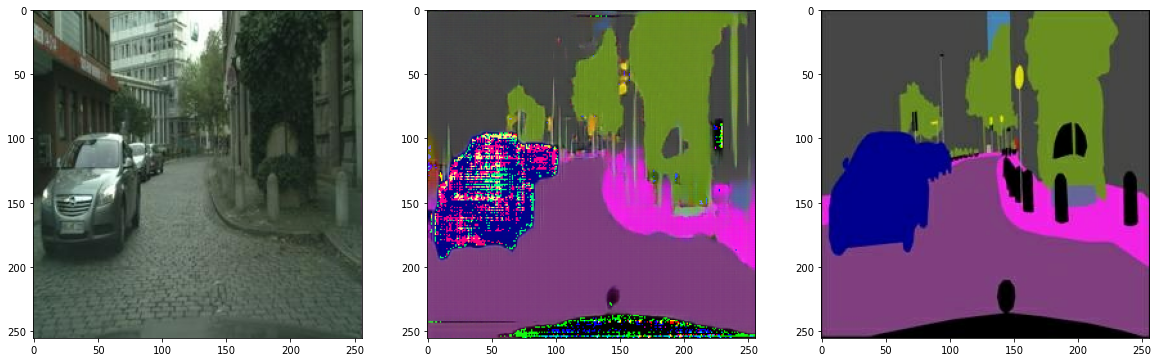

In [21]:
# 채색해보기

test_ind = 1

f = path + os.listdir(path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,3); plt.imshow(denormalize(colored))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])


# 회고
10epoch와 500epoch 사이에 약간의 차이를 본것같다.